# **EXP4 Dissociated and Classic Bulks Deconvolution by Adding More Cells**

Data downloaded from GEO Omnibus: https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE217517

Cell types per sample from original paper can be accessed here: https://github.com/greenelab/deconvolution_pilot/tree/main/data/cell_labels


**Summary:**
Evaluating the effect of (hypothesized) missing cell-types in the residual of real bulks deconvolved with a missing cell-type reference.

We are using single-cell and bulk matched samples from 8 patients. Each sample has a dissociated sample with ribosomal RNA depletion (-rRNA), non-dissociated sample with ribosomal RNA depletion (-rRNA), and dissociated sample with polyA tail capture (polyA). We are attempting to find evidence in the residual of a missing cell type (adipocyte) only in dissociated samples.

**Hypothesis:**
Dissociation process depletes the single-cell and bulk samples from adipocytes. Thus, only non-dissociated bulks show evidence of adipocytes in the residual. This will be evident by adipocyte-related gene expression in the residual of dissociates bulks compared to non-dissociated bulks.

**Deconv. Method:**
NNLS

**Factorization Methods:**
PCA, NMF

In [344]:
# import the dependencies
import sys
sys.path.insert(1, '../../')
sys.path.insert(1, '../')
sys.path.insert(1, '../../../../../')

from functions import sn_sc_preprocess
from functions import validation_processing as vp
from importlib import reload
reload(sn_sc_preprocess)
reload(vp)
# general imports
import warnings
import numpy as np
from numpy import random
from numpy import array
from numpy import diag
from numpy import dot
from numpy import zeros
import pandas as pd
import scanpy as sc
from anndata import AnnData as ad
from tabulate import tabulate

import tensorflow as tf
import sklearn as sk
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import FunctionTransformer
import scipy as sp
from scipy.stats import spearmanr, pearsonr
from scipy.sparse import coo_matrix
from scipy.sparse import csr_matrix
from scipy.stats import wilcoxon
import scipy.stats as stats
from collections import Counter
import scipy as sp
from scipy.optimize import nnls
from scipy.stats import ttest_ind
# Images, plots, display, and visualization
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import matplotlib.colors as mcolors
import seaborn as sns

import seaborn as sns
from scipy import stats
#sklearns
from sklearn.decomposition import FastICA
from sklearn.decomposition import NMF
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import adjusted_rand_score
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier

# programming stuff
import time
import os, sys
from io import StringIO 
import pickle
import requests
from pathlib import Path

In [345]:
#####################
### set the study ###
#####################
#results paths:
res_name = "MCT_hgsoc_EXP4"
actual_path = os.getcwd()
data_path = f"{actual_path}/../data/EXP4/"
cibersort_results_path = f"{actual_path}/../data/EXP4/cibersort_results/"
cibersort_path = f"{actual_path}/../data/EXP4/cibersort/"
random_seed = 88
nmf_cut = 'minimum_value'
num_samples = 10000
prop_type = "real"
bulks_type= f"{prop_type}"
use_all_genes = False

## **Reading and QCing the data:**

Classic Bulks (Not Dissociated)

In [346]:
bulks_path = os.path.join(data_path, f"{res_name}_bulks.csv")
bulks_path = Path(bulks_path)
bulks = pd.read_csv(bulks_path)
bulks = bulks.drop(labels=["Unnamed: 0"], axis = 1)
#the bulks come in this index:
bulks.index = ['2251', '2267', '2283', '2293', '2380',  '2428', '2467', '2497']
# and we'll reorderby sample type:
bulks  = bulks.reindex(index=['2497', '2467', '2380', '2293', '2283','2428','2251', '2267'])
bulks

,MIR1302-2HG,FAM138A,OR4F5,AL627309.1,AL627309.3,AL627309.2,AL627309.5,AL627309.4,AP006222.2,AL732372.1,...,AC136612.1,AC136616.1,AC136616.3,AC136616.2,AC141272.1,AC023491.2,AC007325.1,AC007325.4,AC007325.2,condition
2497,7,0,0,6,0,1,28,0,6,1,...,0,16,0,0,6,2,4,47,36,rrna_chunk
2467,1,0,0,12,0,0,77,0,10,0,...,0,81,0,0,0,2,0,18,13,rrna_chunk
2380,0,0,0,3,0,0,51,0,7,0,...,0,1,0,6,1,0,0,10,23,rrna_chunk
2293,0,0,0,2,0,0,27,0,12,0,...,0,54,0,0,0,1,0,8,0,rrna_chunk
2283,8,0,0,5,0,3,59,0,0,0,...,0,3,0,0,0,0,0,18,34,rrna_chunk
2428,0,0,0,5,0,1,26,0,10,0,...,0,8,0,0,0,0,0,46,24,rrna_chunk
2251,2,0,0,6,0,2,47,0,6,0,...,0,0,0,2,13,0,0,16,7,rrna_chunk
2267,0,0,0,5,0,0,81,1,3,0,...,0,7,0,1,3,0,0,2,3,rrna_chunk


Dissociated Bulks:

In [347]:
dbulks_path = os.path.join(data_path, f"{res_name}_dissociated_bulks.csv")
dbulks_path = Path(dbulks_path)
diss_bulks = pd.read_csv(dbulks_path)
diss_bulks = diss_bulks.drop(labels=["Unnamed: 0"], axis=1)
#the bulks come in this index:
diss_bulks.index = ['2251', '2267', '2283', '2293', '2380',  '2428', '2467', '2497']
# and we'll reorderby sample type:
diss_bulks  = diss_bulks.reindex(index=['2497', '2467', '2380', '2293', '2283','2428','2251', '2267'])
diss_bulks

,MIR1302-2HG,FAM138A,OR4F5,AL627309.1,AL627309.3,AL627309.2,AL627309.5,AL627309.4,AP006222.2,AL732372.1,...,AC136612.1,AC136616.1,AC136616.3,AC136616.2,AC141272.1,AC023491.2,AC007325.1,AC007325.4,AC007325.2,condition
2497,3,0,0,2,0,0,15,0,1,0,...,0,19,0,1,1,3,4,39,28,rrna_diss
2467,1,0,0,5,0,0,63,1,6,0,...,0,27,0,0,0,0,0,8,6,rrna_diss
2380,4,0,0,2,0,0,37,0,2,0,...,0,2,0,0,0,0,0,10,21,rrna_diss
2293,2,0,0,4,0,0,31,0,3,0,...,0,6,0,0,6,0,0,6,2,rrna_diss
2283,1,0,0,1,0,0,33,0,2,0,...,0,6,0,0,1,0,0,20,16,rrna_diss
2428,3,2,0,1,0,0,7,0,5,0,...,0,17,0,0,2,0,0,57,30,rrna_diss
2251,8,0,0,1,0,1,38,0,0,0,...,0,4,0,0,4,0,0,10,9,rrna_diss
2267,1,0,0,1,0,0,26,0,5,0,...,0,19,0,2,11,0,1,15,3,rrna_diss


Dissociated polyA:

In [348]:
disspolyA_bulks_path = os.path.join(data_path, f"{res_name}_dissociatedpolyA_bulks.csv")
disspolyA_bulks_path = Path(disspolyA_bulks_path)
disspolya_bulks = pd.read_csv(disspolyA_bulks_path)
disspolya_bulks = disspolya_bulks.drop(labels=["Unnamed: 0"], axis = 1)
#the bulks come in this index:
disspolya_bulks.index = ['2251', '2267', '2283', '2293', '2380',  '2428', '2467', '2497']
# and we'll reorderby sample type:
disspolya_bulks  = disspolya_bulks.reindex(index=['2497', '2467', '2380', '2293', '2283','2428','2251', '2267'])
disspolya_bulks

,MIR1302-2HG,FAM138A,OR4F5,AL627309.1,AL627309.3,AL627309.2,AL627309.5,AL627309.4,AP006222.2,AL732372.1,...,AC136612.1,AC136616.1,AC136616.3,AC136616.2,AC141272.1,AC023491.2,AC007325.1,AC007325.4,AC007325.2,condition
2497,17,2,0,10,0,2,66,0,15,1,...,1,35,0,0,9,9,7,56,78,polyA_diss
2467,2,1,0,7,0,3,134,0,8,0,...,4,58,0,1,2,0,0,15,11,polyA_diss
2380,5,1,0,6,0,0,159,0,16,0,...,0,2,0,2,6,0,0,27,32,polyA_diss
2293,4,0,0,13,0,4,92,0,5,0,...,0,16,0,0,1,0,0,4,6,polyA_diss
2283,7,0,0,11,0,9,114,0,12,0,...,0,9,0,0,1,0,0,10,17,polyA_diss
2428,0,0,0,1,0,0,14,0,10,0,...,0,35,0,0,6,0,0,51,27,polyA_diss
2251,2,0,0,6,0,1,93,0,9,1,...,0,6,0,2,16,0,0,10,12,polyA_diss
2267,0,0,0,5,0,1,69,0,12,0,...,1,33,0,4,30,0,0,6,3,polyA_diss


And all single-cells:

In [349]:
#saved as anndata objects
adata_path = os.path.join(data_path, f"{res_name}_adata1_notlog.h5ad")
adata_path = Path(adata_path)
adata_1 = sc.read_h5ad(adata_path)

adata_path = os.path.join(data_path, f"{res_name}_adata2_notlog.h5ad")
adata_path = Path(adata_path)
adata_2 = sc.read_h5ad(adata_path)

adata_path = os.path.join(data_path, f"{res_name}_adata3_notlog.h5ad")
adata_path = Path(adata_path)
adata_3 = sc.read_h5ad(adata_path)

adata_path = os.path.join(data_path, f"{res_name}_adata4_notlog.h5ad")
adata_path = Path(adata_path)
adata_4 = sc.read_h5ad(adata_path)

adata_path = os.path.join(data_path, f"{res_name}_adata5_notlog.h5ad")
adata_path = Path(adata_path)
adata_5 = sc.read_h5ad(adata_path)

adata_path = os.path.join(data_path, f"{res_name}_adata6_notlog.h5ad")
adata_path = Path(adata_path)
adata_6 = sc.read_h5ad(adata_path)

adata_path = os.path.join(data_path, f"{res_name}_adata7_notlog.h5ad")
adata_path = Path(adata_path)
adata_7 = sc.read_h5ad(adata_path)

adata_path = os.path.join(data_path, f"{res_name}_adata8_notlog.h5ad")
adata_path = Path(adata_path)
adata_8 = sc.read_h5ad(adata_path)

In [350]:
#attaching adatas (single-cells) into dict
adatas=dict()
adatas[1] = adata_1
adatas[2] = adata_2
adatas[3] = adata_3
adatas[4] = adata_4
adatas[5] = adata_5
adatas[6] = adata_6
adatas[7] = adata_7
adatas[8] = adata_8
#QC
for adata in adatas.items():
    print(adata[1])

AnnData object with n_obs × n_vars = 3102 × 28313
    obs: 'cell_types', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
AnnData object with n_obs × n_vars = 1039 × 28578
    obs: 'cell_types', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
AnnData object with n_obs × n_vars = 1088 × 28704
    obs: 'cell_types', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
AnnData object with n_obs × n_vars = 4329 × 24272
    obs: 'cell_types', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt',

In [351]:
#Our ground truth in this case is single cell! But'll we'll merge them to get more cells.
prop_df = dict()
for num in adatas:
    prop_df[num], adatas[num] = vp.get_prop(adatas[num])
for  adata in adatas:
    print(Counter(adatas[adata].obs["cell_types"]))
    print(" ")    

                   Num_Cells  Prop_Cells
Cell_Types                              
B cells                   62    0.019987
DC                        13    0.004191
Endothelial cells        503    0.162153
Epithelial cells          56    0.018053
Fibroblasts              206    0.066409
ILC                       24    0.007737
Macrophages              123    0.039652
Monocytes                 54    0.017408
NK cells                 114    0.036750
Plasma cells            1432    0.461638
T cells                  506    0.163121
pDC                        9    0.002901
                   Num_Cells  Prop_Cells
Cell_Types                              
B cells                   41    0.039461
DC                         6    0.005775
Endothelial cells         18    0.017324
Epithelial cells          99    0.095284
Fibroblasts               13    0.012512
Macrophages               26    0.025024
Monocytes                 17    0.016362
NK cells                  67    0.064485
Plasma cells    

Making genes the same in all single-cell datas, and merging.

In [352]:
# Extract the values (Anndata objects) from the dictionary
adatas_list = list(adatas.values())

# Concatenate the Anndata objects into a single object
merged_adata = sc.concat(adatas_list, join='inner')
merged_adata.var['gene_ids'] = merged_adata.var_names
merged_adata

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


AnnData object with n_obs × n_vars = 17438 × 13724
    obs: 'cell_types', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids'

## Adding Adipocyte and Medothelial Cells to Reference

In [353]:
#paths:
res_name_adip = f"MCT_adp_EXP3"
pseudo_name_adip = "MCT_adp_EXP3"
files_path_adip= "/../data/EXP3/"
path_results_adip = "/../results/EXP3/"
data_path_adip = "/../data/EXP3/cibersort/"
cibersort_files_adip = "/../data/EXP3/cibersort_results/realisticprop_nonoise_0missing/\
CIBERSORTx_MCT_adp_EXP3_realisticprop_nonoise_0missing_signal_inferred_phenoclasses.CIBERSORTx_\
MCT_adp_EXP3_realisticprop_nonoise_0missing_signal_inferred_refsample.bm.K999.txt"

In [354]:
#font for plots
font = {'fontname':'Arial'}

#parameters into paths
actual_path_adip = os.getcwd()
path_adip = f"{actual_path_adip}{files_path_adip}"
aug_data_path_adip = f"{actual_path_adip}{files_path_adip}"
cibersort_path_adip = f"{actual_path_adip}{cibersort_files_adip}"
path_results_adip = f"{actual_path_adip}{path_results_adip}"
data_path_adip = f"{actual_path_adip}{data_path_adip}"

#and as anndata object single nucleus 
adata_path_adip = os.path.join(path_adip, f"MCT_adp_EXP3_snadata_notlog.h5ad")
adata_path_adip = Path(adata_path_adip)
sn_adata = sc.read_h5ad(adata_path_adip)
cells_to_keep = ["fat cell"]
sn_adata = sn_adata[sn_adata.obs.cell_types.isin(cells_to_keep)]

In [355]:
genes_adatas = np.intersect1d(merged_adata.var["gene_ids"].values, sn_adata.var["gene_ids"].values)
merged_adata = merged_adata[:, genes_adatas]
sn_adata = sn_adata[:, genes_adatas]
merged_adata = sc.concat([sn_adata, merged_adata])
merged_adata.obs_names_make_unique()

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


And final formatting on the bulks:

In [356]:
#combining the dissociated and non dissociated
combo = pd.DataFrame(np.concatenate([bulks.values, diss_bulks.values]), 
index = range(1,17), columns = bulks.columns)

In [357]:
#making sure index matches:
sample_ids = ['2497', '2467', '2380', '2293', '2283','2428','2251', '2267']
bulks.index = sample_ids
diss_bulks.index = sample_ids
disspolya_bulks.index = sample_ids
combo.index = sample_ids * 2
bulks

,MIR1302-2HG,FAM138A,OR4F5,AL627309.1,AL627309.3,AL627309.2,AL627309.5,AL627309.4,AP006222.2,AL732372.1,...,AC136612.1,AC136616.1,AC136616.3,AC136616.2,AC141272.1,AC023491.2,AC007325.1,AC007325.4,AC007325.2,condition
2497,7,0,0,6,0,1,28,0,6,1,...,0,16,0,0,6,2,4,47,36,rrna_chunk
2467,1,0,0,12,0,0,77,0,10,0,...,0,81,0,0,0,2,0,18,13,rrna_chunk
2380,0,0,0,3,0,0,51,0,7,0,...,0,1,0,6,1,0,0,10,23,rrna_chunk
2293,0,0,0,2,0,0,27,0,12,0,...,0,54,0,0,0,1,0,8,0,rrna_chunk
2283,8,0,0,5,0,3,59,0,0,0,...,0,3,0,0,0,0,0,18,34,rrna_chunk
2428,0,0,0,5,0,1,26,0,10,0,...,0,8,0,0,0,0,0,46,24,rrna_chunk
2251,2,0,0,6,0,2,47,0,6,0,...,0,0,0,2,13,0,0,16,7,rrna_chunk
2267,0,0,0,5,0,0,81,1,3,0,...,0,7,0,1,3,0,0,2,3,rrna_chunk


Assigning genes: 

In [358]:
#Reading in the CIBERSORTx barcode genes
cibersort_ref = dict()
cibersort_genes = dict()
print("genes to keep per experiment:")
#name is long so we're cutting it
cut_str1 = "missing_signal_inferred_phenoclasses.CIBERSORTx_"
cut_str2 = "missing_signal_inferred_refsample.bm.K999.txt"
for num in adatas:    
    # read in cibersort genes from cibersort reference
    cibersort_path_ = os.path.join(cibersort_results_path, 
        f"CIBERSORTx_{res_name}_{bulks_type}_{num}{cut_str1}{res_name}_{bulks_type}_{num}{cut_str2}")
    cibersort_path_ = Path(cibersort_path_)
    cibersort_df = pd.read_csv(cibersort_path_, sep="\t")
    cibersort_genes[num] = pd.DataFrame(columns = cibersort_df["NAME"].values.tolist())
    cibersort_df.index = cibersort_genes[num].columns
    cibersort_ref[num] = cibersort_df.drop(columns = "NAME", inplace=False)
cibersort_genes = cibersort_genes[1].columns
cibersort_genes = cibersort_genes.tolist()
cibersort_genes

genes to keep per experiment:


['A1BG',
 'A2M',
 'AAGAB',
 'AASS',
 'AATK',
 'ABCA1',
 'ABCA10',
 'ABCA5',
 'ABCA6',
 'ABCA9',
 'ABCB1',
 'ABCC4',
 'ABCC9',
 'ABCE1',
 'ABHD12',
 'ABHD15',
 'ABHD15.AS1',
 'ABHD17A',
 'ABHD17C',
 'ABHD2',
 'ABHD3',
 'ABI2',
 'ABI3BP',
 'ABL2',
 'ABLIM1',
 'ABR',
 'ABRACL',
 'ABTB2',
 'AC002091.1',
 'AC002429.2',
 'AC004687.1',
 'AC004817.3',
 'AC004854.2',
 'AC005037.1',
 'AC005261.1',
 'AC005264.1',
 'AC005480.1',
 'AC005920.2',
 'AC006064.2',
 'AC006449.6',
 'AC007032.1',
 'AC007365.1',
 'AC007381.1',
 'AC007384.1',
 'AC007569.1',
 'AC007991.3',
 'AC008014.1',
 'AC008105.3',
 'AC008569.1',
 'AC008691.1',
 'AC008696.2',
 'AC008760.2',
 'AC008764.7',
 'AC008764.8',
 'AC009313.1',
 'AC010609.1',
 'AC010883.3',
 'AC010894.3',
 'AC011462.5',
 'AC011476.3',
 'AC011511.2',
 'AC012184.4',
 'AC012368.1',
 'AC012447.1',
 'AC013652.1',
 'AC015871.7',
 'AC015912.3',
 'AC016831.1',
 'AC017101.1',
 'AC017104.1',
 'AC018682.1',
 'AC018755.4',
 'AC018816.1',
 'AC020656.1',
 'AC021180.1',
 'AC02159

Now the other cibersort genes for the other 2 cell types

In [359]:
cibersort_df = pd.read_csv(cibersort_path_adip, sep="\t")
cibersort_genes_adip = cibersort_df["NAME"].values

cibersort_genes = np.unique(np.concatenate((cibersort_genes,cibersort_genes_adip)))
cibersort_genes.shape

(6037,)

Defining gene markers:

In [360]:
#From deconv paper: https://genomebiology.biomedcentral.com/articles/10.1186/s13059-023-03077-7
#Erythocyte markers
eryth_markers = ['ALAS2','HBB', 'HBA2','HBA1']
#Dissociation Response
diss_response = ['PYDC1', 'PRRR35', 'AGXT', 'EREG', 'CSF3', 'ASTL'
    'HSPC3', 'SELE', 'IL1B', 'TRIM72', 'CTRB2', 'RNF223', 'CSF2','CXCL8',
    'KRT17', 'PMAIP1', 'CSF2','ADRA2B','CCL3L1', 'SLC32A1','DLX2','CXCR1','LEP',
    'TEX48','FCGR3B','CXCR2','THRSP','TMC2', 'AL845331.2','SLC7A10','BOD1L2',
    'SERPINI2','BLID']
#And adipocyte markers
adipocyte_genes = ["PLIN1", "CIDEC", "GPD1", "ACVR1C"]
#adipocyte markers from CellMarker: https://academic.oup.com/nar/article/51/D1/D870/6775381
markers_path = os.path.join(data_path, f"CellMarker.csv")
markers_path = Path(markers_path)
markers = pd.read_csv(markers_path)
adip_markers = markers["Cell Marker"]
adip_markers = adip_markers.tolist()
adip_markers.append(adipocyte_genes)
#deleting genes that are also highly expressed in cancer
removed_marker = ['CD44','CD45','CD34','CD29','CD137','CD106']
for remove_gene in removed_marker:
    adip_markers.remove(remove_gene)
adip_markers

['ACRP30',
 'ADIPOR1',
 'ADIPOR2',
 'BSCL2',
 'CHC22',
 'CIDEA',
 'DLK1',
 'DLK2',
 'FABP4',
 'FATP1',
 'FATP2',
 'FATP4',
 'FATP5',
 'FATP6',
 'GLUT4',
 'Galectin-12',
 'HLA-ABC',
 'Leptin',
 'PGC-1-alpha',
 'PPARgamma',
 'Perilipin-2',
 'UCP1',
 'VSTM2A',
 'VSTM2B',
 'ZIC1',
 'gACRP30',
 ['PLIN1', 'CIDEC', 'GPD1', 'ACVR1C']]

In [361]:
#Some of the names are not in the right format, so reassigning manually
adip_markers = np.array(adip_markers)
adip_markers = ['ACRP30', 'ADIPOR1', 'ADIPOR2', 'CIDEA', 'FABP4',
       'FATP1', 'FATP2', 'FATP4', 'FATP5', 'FATP6', 'GLUT4',
       'LGALS12', 'LEP', 'PPARG',
       'PLIN1', 'UCP1', 'GACRP30','ACVR1C', 
       'CIDEC', 'GPD1', 'ADIPOQ', 'MRAP', 'TRARG1', 'ADGRL4', 'LIPE']

/projects/aivich@xsede.org/code-server/tmp/ipykernel_68498/1432233138.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  adip_markers = np.array(adip_markers)


In [362]:
#merging the cibersort, adipocyte, erythocyte, and dissociation genes:
gene_ids = list()
gene_ids.extend(cibersort_genes)
gene_ids.extend(adip_markers)
gene_ids.extend(eryth_markers)
gene_ids.extend(diss_response)
gene_ids

['A1BG',
 'A2M',
 'A2M.AS1',
 'A2ML1.AS1',
 'AADACL2.AS1',
 'AAGAB',
 'AASS',
 'AATF',
 'AATK',
 'ABAT',
 'ABCA1',
 'ABCA10',
 'ABCA5',
 'ABCA6',
 'ABCA8',
 'ABCA9',
 'ABCA9.AS1',
 'ABCB1',
 'ABCB10',
 'ABCC3',
 'ABCC4',
 'ABCC5',
 'ABCC6',
 'ABCC9',
 'ABCD2',
 'ABCE1',
 'ABCG1',
 'ABHD12',
 'ABHD12B',
 'ABHD15',
 'ABHD15.AS1',
 'ABHD17A',
 'ABHD17B',
 'ABHD17C',
 'ABHD2',
 'ABHD3',
 'ABHD5',
 'ABHD6',
 'ABI2',
 'ABI3BP',
 'ABL2',
 'ABLIM1',
 'ABLIM3',
 'ABO',
 'ABR',
 'ABRACL',
 'ABTB2',
 'AC002066.1',
 'AC002070.1',
 'AC002091.1',
 'AC002429.2',
 'AC003991.1',
 'AC004551.1',
 'AC004594.1',
 'AC004687.1',
 'AC004817.3',
 'AC004854.2',
 'AC004862.1',
 'AC004917.1',
 'AC005037.1',
 'AC005064.1',
 'AC005162.3',
 'AC005237.1',
 'AC005261.1',
 'AC005264.1',
 'AC005480.1',
 'AC005699.1',
 'AC005920.2',
 'AC006064.2',
 'AC006160.1',
 'AC006369.1',
 'AC006387.1',
 'AC006449.6',
 'AC007032.1',
 'AC007114.2',
 'AC007319.1',
 'AC007365.1',
 'AC007381.1',
 'AC007384.1',
 'AC007529.2',
 'AC007563.

In [363]:
#and set intersection of gene_ids from adata, bulks, and cibersort:
genes_in_both = np.intersect1d(gene_ids, bulks.columns)
genes_in_both = np.intersect1d(genes_in_both, diss_bulks.columns)
genes_in_both = np.intersect1d(genes_in_both, merged_adata.var_names)
gene_ids = genes_in_both.copy()
gene_ids.shape

(4584,)

In [364]:
#cutting all to only include marker genes and barcode genes from cibersort.
bulks = bulks [gene_ids]
diss_bulks= diss_bulks[gene_ids]
disspolya_bulks = disspolya_bulks[gene_ids]
combo = combo[gene_ids]
merged_adata = merged_adata[:, gene_ids]

# Prep. for Deconvolution:

Normalizing bulk counts:

In [365]:
combo_norm = pd.DataFrame(columns=bulks.columns)
for idx, bulk in combo.iterrows():
    pseudo_df = pd.DataFrame(bulk)
    clip_upper = np.quantile(pseudo_df, 0.90)
    pseudo_df = np.clip(pseudo_df, 0, clip_upper)
    #and normalize to values between 0 and 1
    scaler = MinMaxScaler()
    scaler.fit(pseudo_df)
    normalized_pseudo_df = scaler.transform(pseudo_df)
    combo_norm = combo_norm.append(pd.DataFrame(normalized_pseudo_df.T, columns = combo_norm.columns))
combo = combo_norm.copy()
combo.index = ['2497', '2467', '2380', '2293', '2283','2428','2251', '2267']*2
combo

,A1BG,A2M,AAGAB,AASS,AATF,AATK,ABAT,ABCA1,ABCA5,ABCB1,...,ZNHIT1,ZNHIT3,ZNRF1,ZNRF3,ZPR1,ZRSR2,ZSCAN18,ZSWIM8,ZXDC,ZYX
2497,0.030876,1.0,0.209729,0.335750,0.240834,0.076847,0.212703,1.0,0.231686,0.044828,...,0.279487,0.071358,0.079135,0.168332,0.300528,0.048944,0.493790,0.490588,0.408481,1.000000
2467,0.034156,1.0,0.224407,0.269735,0.326236,0.291123,0.142369,1.0,0.339005,0.010215,...,0.331982,0.091295,0.203658,0.224088,0.321767,0.071823,0.281227,0.512976,0.777285,0.691416
2380,0.006397,1.0,0.212207,0.748020,0.292061,0.061545,0.106986,1.0,0.414047,0.108751,...,0.150442,0.059780,0.067721,0.187501,0.475151,0.039486,0.128383,0.522136,0.208237,0.761476
2293,0.017374,1.0,0.336922,0.078354,0.325339,0.050419,0.252095,1.0,0.230292,0.031682,...,0.292635,0.110377,0.101519,0.059958,0.284459,0.112421,0.129795,0.516795,0.539279,0.749131
2283,0.074856,1.0,0.319635,0.234299,0.245527,0.080345,0.117524,1.0,0.272226,0.099059,...,0.355566,0.090825,0.216084,0.280959,0.429922,0.089827,0.757542,1.000000,0.515757,0.335354
2428,0.036937,1.0,0.204505,0.086486,0.375676,0.178378,0.072072,1.0,1.000000,0.018468,...,0.168468,0.100000,0.100450,0.406306,0.306757,0.031081,0.436937,0.662613,0.819820,0.253604
2251,0.021250,1.0,0.190729,0.396149,0.239788,0.079230,0.127502,1.0,0.401133,0.084214,...,0.211717,0.079492,0.086576,0.095495,0.241624,0.117533,0.266810,0.746124,0.472493,0.877299
2267,0.007981,1.0,0.254515,0.297082,0.291170,0.093115,0.103757,1.0,0.281711,0.112625,...,0.179432,0.052322,0.123563,0.145142,0.464986,0.088681,0.151645,0.549233,0.259541,1.000000
2497,0.042750,1.0,0.181850,0.461569,0.233063,0.139100,0.119352,1.0,0.170132,0.112191,...,0.331366,0.062280,0.078339,0.123910,0.418819,0.045571,0.512999,0.485439,0.358708,1.000000
2467,0.029119,1.0,0.157098,0.394004,0.248409,0.149189,0.059316,1.0,0.304850,0.103534,...,0.265305,0.078369,0.143078,0.112162,0.241579,0.092749,0.216055,0.707122,0.422763,1.000000


In [366]:
bulks_norm = pd.DataFrame(columns=bulks.columns)
for idx, bulk in bulks.iterrows():
    pseudo_df = pd.DataFrame(bulk)
    clip_upper = np.quantile(pseudo_df, 0.90)
    pseudo_df = np.clip(pseudo_df, 0, clip_upper)
    #and normalize to values between 0 and 1
    scaler = MinMaxScaler()
    scaler.fit(pseudo_df)
    normalized_pseudo_df = scaler.transform(pseudo_df)
    bulks_norm = bulks_norm.append(pd.DataFrame(normalized_pseudo_df.T, columns = bulks_norm.columns))
bulks = bulks_norm.copy()
bulks.index = ['2497', '2467', '2380', '2293', '2283','2428','2251', '2267']
bulks

,A1BG,A2M,AAGAB,AASS,AATF,AATK,ABAT,ABCA1,ABCA5,ABCB1,...,ZNHIT1,ZNHIT3,ZNRF1,ZNRF3,ZPR1,ZRSR2,ZSCAN18,ZSWIM8,ZXDC,ZYX
2497,0.030876,1.0,0.209729,0.335750,0.240834,0.076847,0.212703,1.0,0.231686,0.044828,...,0.279487,0.071358,0.079135,0.168332,0.300528,0.048944,0.493790,0.490588,0.408481,1.000000
2467,0.034156,1.0,0.224407,0.269735,0.326236,0.291123,0.142369,1.0,0.339005,0.010215,...,0.331982,0.091295,0.203658,0.224088,0.321767,0.071823,0.281227,0.512976,0.777285,0.691416
2380,0.006397,1.0,0.212207,0.748020,0.292061,0.061545,0.106986,1.0,0.414047,0.108751,...,0.150442,0.059780,0.067721,0.187501,0.475151,0.039486,0.128383,0.522136,0.208237,0.761476
2293,0.017374,1.0,0.336922,0.078354,0.325339,0.050419,0.252095,1.0,0.230292,0.031682,...,0.292635,0.110377,0.101519,0.059958,0.284459,0.112421,0.129795,0.516795,0.539279,0.749131
2283,0.074856,1.0,0.319635,0.234299,0.245527,0.080345,0.117524,1.0,0.272226,0.099059,...,0.355566,0.090825,0.216084,0.280959,0.429922,0.089827,0.757542,1.000000,0.515757,0.335354
2428,0.036937,1.0,0.204505,0.086486,0.375676,0.178378,0.072072,1.0,1.000000,0.018468,...,0.168468,0.100000,0.100450,0.406306,0.306757,0.031081,0.436937,0.662613,0.819820,0.253604
2251,0.021250,1.0,0.190729,0.396149,0.239788,0.079230,0.127502,1.0,0.401133,0.084214,...,0.211717,0.079492,0.086576,0.095495,0.241624,0.117533,0.266810,0.746124,0.472493,0.877299
2267,0.007981,1.0,0.254515,0.297082,0.291170,0.093115,0.103757,1.0,0.281711,0.112625,...,0.179432,0.052322,0.123563,0.145142,0.464986,0.088681,0.151645,0.549233,0.259541,1.000000


In [367]:
diss_bulks_norm = pd.DataFrame(columns=diss_bulks.columns)
for idx, bulk in diss_bulks.iterrows():
    pseudo_df = pd.DataFrame(bulk)
    clip_upper = np.quantile(pseudo_df, 0.90)
    pseudo_df = np.clip(pseudo_df, 0, clip_upper)
    #and normalize to values between 0 and 1
    scaler = MinMaxScaler()
    scaler.fit(pseudo_df)
    normalized_pseudo_df = scaler.transform(pseudo_df)
    diss_bulks_norm = diss_bulks_norm.append(pd.DataFrame(normalized_pseudo_df.T, columns = diss_bulks_norm.columns))
diss_bulks = diss_bulks_norm.copy()
diss_bulks.index = ['2497', '2467', '2380', '2293', '2283','2428','2251', '2267']
diss_bulks

,A1BG,A2M,AAGAB,AASS,AATF,AATK,ABAT,ABCA1,ABCA5,ABCB1,...,ZNHIT1,ZNHIT3,ZNRF1,ZNRF3,ZPR1,ZRSR2,ZSCAN18,ZSWIM8,ZXDC,ZYX
2497,0.042750,1.0,0.181850,0.461569,0.233063,0.139100,0.119352,1.0,0.170132,0.112191,...,0.331366,0.062280,0.078339,0.123910,0.418819,0.045571,0.512999,0.485439,0.358708,1.000000
2467,0.029119,1.0,0.157098,0.394004,0.248409,0.149189,0.059316,1.0,0.304850,0.103534,...,0.265305,0.078369,0.143078,0.112162,0.241579,0.092749,0.216055,0.707122,0.422763,1.000000
2380,0.022433,1.0,0.196148,0.435246,0.318433,0.368496,0.060732,1.0,0.251409,0.145265,...,0.228156,0.055534,0.090825,0.195327,0.583794,0.050610,0.157028,0.604311,0.336488,1.000000
2293,0.013316,1.0,0.295448,0.413072,0.314589,0.106528,0.092379,1.0,0.147863,0.083502,...,0.267429,0.072405,0.106528,0.212778,0.706300,0.125669,0.218326,0.407524,0.379505,1.000000
2283,0.044855,1.0,0.217488,0.316346,0.252309,0.135745,0.070233,1.0,0.163189,0.120105,...,0.317821,0.070529,0.151385,0.282999,0.832178,0.077611,0.472453,0.913625,0.583410,0.711482
2428,0.068274,1.0,0.192710,0.179496,0.329993,0.666593,0.035973,1.0,0.497375,0.082223,...,0.209962,0.041479,0.064237,0.173623,0.703667,0.027163,0.343942,0.499945,0.745880,0.601255
2251,0.017914,1.0,0.172978,0.458757,0.286058,0.187533,0.059059,1.0,0.261707,0.296414,...,0.212164,0.040586,0.096846,0.140230,0.599547,0.074453,0.268145,0.441123,0.443922,0.873009
2267,0.022504,1.0,0.190084,0.160638,0.299969,0.060808,0.077087,1.0,0.141725,0.094084,...,0.225755,0.060090,0.083551,0.017955,0.493644,0.125206,0.087860,0.470422,0.276508,1.000000


In [368]:
disspolya_bulks_norm = pd.DataFrame(columns= disspolya_bulks.columns)
for idx, bulk in disspolya_bulks.iterrows():
    pseudo_df = pd.DataFrame(bulk)
    clip_upper = np.quantile(pseudo_df, 0.90)
    pseudo_df = np.clip(pseudo_df, 0, clip_upper)
    #and normalize to values between 0 and 1
    scaler = MinMaxScaler()
    scaler.fit(pseudo_df)
    normalized_pseudo_df = scaler.transform(pseudo_df)
    disspolya_bulks_norm = disspolya_bulks_norm.append(pd.DataFrame(normalized_pseudo_df.T, columns = disspolya_bulks_norm.columns))
disspolya_bulks = disspolya_bulks_norm.copy()
disspolya_bulks.index = ['2497', '2467', '2380', '2293', '2283','2428','2251', '2267']
disspolya_bulks

,A1BG,A2M,AAGAB,AASS,AATF,AATK,ABAT,ABCA1,ABCA5,ABCB1,...,ZNHIT1,ZNHIT3,ZNRF1,ZNRF3,ZPR1,ZRSR2,ZSCAN18,ZSWIM8,ZXDC,ZYX
2497,0.022896,1.0,0.169267,0.493974,0.209695,0.059999,0.117051,0.721049,0.171837,0.085767,...,0.299845,0.057959,0.073979,0.080024,0.390222,0.062871,0.479541,0.571202,0.308006,1.000000
2467,0.028579,1.0,0.169502,0.439521,0.244398,0.100518,0.050259,1.000000,0.241638,0.077655,...,0.345704,0.089678,0.140134,0.067012,0.240061,0.182313,0.251099,0.976408,0.373100,1.000000
2380,0.010532,1.0,0.203908,0.493592,0.295521,0.072453,0.047963,1.000000,0.254790,0.107601,...,0.236899,0.057734,0.081462,0.108489,0.617942,0.106966,0.118894,0.617942,0.254663,1.000000
2293,0.006858,1.0,0.292518,0.466563,0.249716,0.046349,0.097427,1.000000,0.117054,0.064557,...,0.290863,0.057463,0.133844,0.175936,0.654086,0.188942,0.222522,0.439841,0.296302,1.000000
2283,0.016514,1.0,0.210502,0.348468,0.248338,0.053305,0.073373,0.882353,0.165559,0.109745,...,0.336134,0.069819,0.177265,0.242903,0.728082,0.119988,0.431247,1.000000,0.475145,1.000000
2428,0.028283,1.0,0.195912,0.150383,0.268574,0.154752,0.026443,1.000000,0.316172,0.074502,...,0.243050,0.059785,0.045989,0.106464,0.713744,0.033342,0.286969,0.473223,0.695118,0.986456
2251,0.009285,1.0,0.144343,0.476753,0.246480,0.068542,0.045075,1.000000,0.241753,0.233987,...,0.207820,0.043218,0.102475,0.101124,0.572138,0.101968,0.236013,0.435561,0.360097,1.000000
2267,0.012057,1.0,0.195362,0.167578,0.247785,0.036346,0.076013,1.000000,0.155346,0.068150,...,0.241494,0.065354,0.085100,0.010659,0.461670,0.200430,0.084925,0.518811,0.219127,1.000000


As it is recommended in deconvolution methods, we will delete cells that have low quantities (<50):

In [369]:
Counter(merged_adata.obs["cell_types"])

Counter({'fat cell': 24825,
         'Plasma cells': 1983,
         'Monocytes': 272,
         'T cells': 7419,
         'Endothelial cells': 1189,
         'NK cells': 842,
         'Epithelial cells': 1694,
         'ILC': 89,
         'Fibroblasts': 1587,
         'B cells': 264,
         'DC': 98,
         'Macrophages': 1116,
         'pDC': 170,
         'Mast cells': 27,
         'Unknown1': 512,
         'Unknown2': 155,
         'Erythroid': 21})

In [370]:
# remove cells that are unlabeled or unclassified
cell_type_id = merged_adata.obs["cell_types"].values
cell_type_id = np.unique(cell_type_id)
cell_type_remove = ["Unknown1", "Unknown2"]
cell_type_id = set(cell_type_id).difference(set(cell_type_remove))
merged_adata = merged_adata[merged_adata.obs["cell_types"].isin(cell_type_id)]
#matching obs
print(np.unique(merged_adata.obs["cell_types"].values))

['B cells' 'DC' 'Endothelial cells' 'Epithelial cells' 'Erythroid'
 'Fibroblasts' 'ILC' 'Macrophages' 'Mast cells' 'Monocytes' 'NK cells'
 'Plasma cells' 'T cells' 'fat cell' 'pDC']


## References

In [371]:
#Making cell type reference without scaling
ref_raw_all = dict()
idx = 1
adata = merged_adata
cell_types = adata.obs["cell_types"].unique()
ref_raw = pd.DataFrame(index = gene_ids, columns = cell_types)
for cell_type in cell_types:
    cell_df = adata[adata.obs["cell_types"].isin([cell_type])]
    cell_sample = sk.utils.resample(cell_df, n_samples = num_samples, replace=True)
    x = cell_sample.X.sum(axis=0)
    sum_over_genes = pd.DataFrame(x).T
    #and save to df dict
    ref_raw[cell_type] = sum_over_genes.values
ref_raw_all = ref_raw
ref_raw_all

,fat cell,Plasma cells,Monocytes,T cells,Endothelial cells,NK cells,Epithelial cells,ILC,Fibroblasts,B cells,DC,Macrophages,pDC,Mast cells,Erythroid
A1BG,12.0,2788.547119,2718.512207,4336.416016,1653.404785,5248.313477,4551.484375,4245.449219,4333.680664,3685.020996,2967.687500,3339.112305,13890.300781,3920.104004,1993.714355
A2M,2604.0,6448.043457,1442.861450,1632.005981,94481.531250,1645.197266,3558.708252,2545.603027,29701.359375,957.935425,4284.560547,11485.016602,675.770874,0.000000,2452.269775
AAGAB,2502.0,1569.466309,2974.806885,1555.080200,1771.628174,1691.479858,1363.162354,2115.525879,1466.091675,2768.208984,968.927734,3382.319824,730.224121,674.538086,0.000000
AASS,5757.0,1090.686035,428.303162,282.331635,3001.622070,179.296219,657.716431,669.998840,4339.311035,838.184692,0.000000,310.706177,51.475300,2313.359131,0.000000
AATF,3014.0,3012.755127,3367.056641,5673.168945,5729.394531,4744.396484,3713.536377,2835.599854,4211.972168,5352.702148,2066.433838,4641.142578,3350.208496,3673.596191,929.059509
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZRSR2,1260.0,1511.246704,2087.235352,5788.257812,1891.314087,5863.475098,1585.823730,3929.696533,2448.950928,5815.439453,2353.042725,3288.631836,1055.546997,3129.147217,0.000000
ZSCAN18,1431.0,534.781921,659.909668,799.135010,2491.620117,1732.680054,3410.196777,3736.246582,2589.092041,2725.855957,474.520447,415.139404,431.261597,826.355347,0.000000
ZSWIM8,3229.0,909.414001,834.157043,1787.146484,1753.339600,1380.582397,925.158997,1066.468750,1742.375854,1060.954102,1458.900513,2215.767822,2249.535156,3007.198730,0.000000
ZXDC,6631.0,2846.294922,2279.918457,1919.591797,1410.057129,2036.207642,2269.169189,1590.197754,1257.333984,1627.296265,1667.566895,1623.308838,1626.635376,0.000000,0.000000


In [372]:
#clippign before scaling to 95th pecentile
ref_raw_val = ref_raw_all.values
clip_upper = np.quantile(ref_raw_val, 0.90)
ref_raw_val = np.clip(ref_raw_val, 0, clip_upper)
#and scaling to be between values 0 and 1 to use for NNLS
scaler = MinMaxScaler()
scaler.fit(ref_raw_val)
ref_df = scaler.transform(ref_raw_val)
ref_df = pd.DataFrame(ref_df, index = gene_ids, columns = ref_raw_all.columns)
ref_raw = pd.DataFrame(ref_raw_val, index = gene_ids, columns = ref_raw_all.columns)
ref_df_all = ref_df
ref_raw_all = ref_raw
all_refs = ref_df_all.copy()
ref_df_all

,fat cell,Plasma cells,Monocytes,T cells,Endothelial cells,NK cells,Epithelial cells,ILC,Fibroblasts,B cells,DC,Macrophages,pDC,Mast cells,Erythroid
A1BG,0.001363,0.316718,0.308764,0.492425,0.187791,0.596095,0.516950,0.482191,0.492212,0.418538,0.337065,0.379251,1.000000,0.445239,0.226443
A2M,0.295758,0.732358,0.163878,0.185203,1.000000,0.186859,0.404192,0.289125,1.000000,0.108801,0.486633,1.000000,0.076753,0.000000,0.278525
AAGAB,0.284173,0.178257,0.337874,0.176464,0.201219,0.192115,0.154826,0.240278,0.166516,0.314409,0.110049,0.384158,0.082938,0.076613,0.000000
AASS,0.653870,0.123878,0.048646,0.031879,0.340919,0.020364,0.074702,0.076097,0.492852,0.095200,0.000000,0.035289,0.005846,0.262747,0.000000
AATF,0.342325,0.342184,0.382425,0.644280,0.650735,0.538861,0.421777,0.322063,0.478389,0.607951,0.234702,0.527133,0.380511,0.417241,0.105521
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZRSR2,0.143109,0.171645,0.237065,0.657354,0.214812,0.665964,0.180115,0.446328,0.278148,0.660508,0.267255,0.373517,0.119887,0.355403,0.000000
ZSCAN18,0.162531,0.060740,0.074951,0.090588,0.282994,0.196795,0.387324,0.424357,0.294065,0.309598,0.053895,0.047151,0.048982,0.093856,0.000000
ZSWIM8,0.366744,0.103290,0.094742,0.202827,0.199141,0.156804,0.105078,0.121128,0.197896,0.120501,0.165699,0.251663,0.255498,0.341553,0.000000
ZXDC,0.753138,0.323277,0.258949,0.217873,0.160152,0.231269,0.257728,0.180612,0.142806,0.184826,0.189399,0.184373,0.184750,0.000000,0.000000


## NNLS Deconvolution:

Here, we use the SC-reference to deconvolve the dissociated bulk and the non-dissociated bulk (from matched tissue).

In [373]:
#dissociated bulks
calc_prop_tot_dissbulks, calc_res_tot_dissbulks = vp.calc_nnls_hgsoc(all_refs, prop_df, diss_bulks, num_missing_cells = [0,1])

Sample No.:2497
Sample No.:2467
Sample No.:2380
Sample No.:2293
Sample No.:2283
Sample No.:2428
Sample No.:2251
Sample No.:2267


In [374]:
#dissociated polyA bulks
calc_prop_tot_disspolyabulks, calc_res_tot_disspolyabulks = vp.calc_nnls_hgsoc(all_refs, prop_df, disspolya_bulks, num_missing_cells = [0,1])

Sample No.:2497
Sample No.:2467
Sample No.:2380
Sample No.:2293
Sample No.:2283
Sample No.:2428
Sample No.:2251
Sample No.:2267


In [375]:
#non dissociated bulks
calc_prop_tot_bulks, calc_res_tot_bulks = vp.calc_nnls_hgsoc(all_refs, prop_df, bulks, num_missing_cells = [0,1])

Sample No.:2497
Sample No.:2467
Sample No.:2380
Sample No.:2293
Sample No.:2283
Sample No.:2428
Sample No.:2251
Sample No.:2267


In [376]:
#combination
calc_prop_tot_combo = pd.concat([calc_prop_tot_bulks, calc_prop_tot_dissbulks])
calc_prop_tot_combo

,fat cell,Plasma cells,Monocytes,T cells,Endothelial cells,NK cells,Epithelial cells,ILC,Fibroblasts,B cells,DC,Macrophages,pDC,Mast cells,Erythroid
2497,0.237570,0.097225,0.000000,0.000000,0.015176,0.000000,0.315511,0.006132,0.231435,0.00000,0.0,0.056034,0.0,0.000000,0.040918
2467,0.283245,0.086154,0.000000,0.000000,0.000000,0.000000,0.537627,0.010743,0.000000,0.00000,0.0,0.080937,0.0,0.001293,0.000000
2380,0.332473,0.000000,0.100079,0.000000,0.241784,0.000000,0.000000,0.000000,0.259319,0.00000,0.0,0.043158,0.0,0.000000,0.023186
2293,0.192281,0.007582,0.000000,0.034762,0.000000,0.000000,0.347143,0.000000,0.000000,0.00000,0.0,0.413390,0.0,0.004842,0.000000
2283,0.305113,0.042985,0.000000,0.000000,0.067185,0.000000,0.459811,0.000000,0.071633,0.00000,0.0,0.053274,0.0,0.000000,0.000000
2428,0.382356,0.069888,0.000000,0.000000,0.000000,0.000000,0.464088,0.008111,0.000000,0.02742,0.0,0.048137,0.0,0.000000,0.000000
2251,0.245521,0.226353,0.000000,0.001584,0.019971,0.000000,0.015981,0.000000,0.226106,0.00553,0.0,0.250463,0.0,0.000000,0.008490
2267,0.235040,0.018983,0.137929,0.000000,0.214126,0.000000,0.000000,0.000000,0.201944,0.00000,0.0,0.185165,0.0,0.000000,0.006813
2497,0.156500,0.125572,0.009677,0.000000,0.110356,0.000000,0.221866,0.000000,0.324268,0.00000,0.0,0.012855,0.0,0.000000,0.038906
2467,0.194221,0.150277,0.000000,0.000000,0.130755,0.000000,0.054813,0.000000,0.224444,0.00000,0.0,0.245489,0.0,0.000000,0.000000


## Evalutating NNLS Performance:

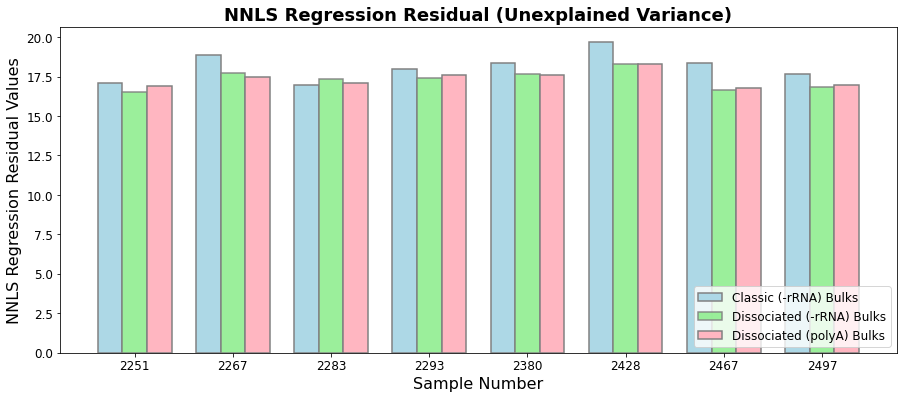

In [377]:

# Sample data for "Classic Bulks" and "Dissociated Bulks"
classic_bulks_values = calc_res_tot_bulks.values[0]
dissociated_bulks_values = calc_res_tot_dissbulks.values[0]
dissociatedpolya_bulks_values = calc_res_tot_disspolyabulks.values[0]

# Create x-coordinates for the bars
x_coordinates = np.arange(len(classic_bulks_values))
# Width of each bar
bar_width = 0.25

plt.figure(figsize=(15, 6))

# Plot "Classic Bulks" residuals
plt.bar(x_coordinates, classic_bulks_values, width=bar_width, alpha=1, label='Classic (-rRNA) Bulks',
                        color='lightblue', edgecolor='grey', linewidth=1.5)

# Plot "Dissociated Bulks" residuals next to the "Classic Bulks" bars
plt.bar(x_coordinates + bar_width, dissociated_bulks_values, width=bar_width, alpha=0.9, label='Dissociated (-rRNA) Bulks', 
                        color='lightgreen', edgecolor='grey', linewidth=1.5)

# Plot "Dissociated Bulks" residuals next to the "Classic Bulks" bars
plt.bar(x_coordinates + bar_width + bar_width, dissociatedpolya_bulks_values, width=bar_width, alpha=1, 
                label='Dissociated (polyA) Bulks', color="lightpink", edgecolor='grey', linewidth=1.5)

plt.xlabel('Sample Number', fontsize=16)
plt.ylabel('NNLS Regression Residual Values', fontsize = '16')

# Make the title bold
plt.title('NNLS Regression Residual (Unexplained Variance)', fontweight='bold', fontsize = '18')

plt.xticks(x_coordinates + bar_width, ['2251', '2267', '2283', '2293', '2380', '2428', '2467', '2497'])  # Adjust x-axis labels

# Move the legend to the upper right corner
plt.legend(loc='lower right')

plt.show()

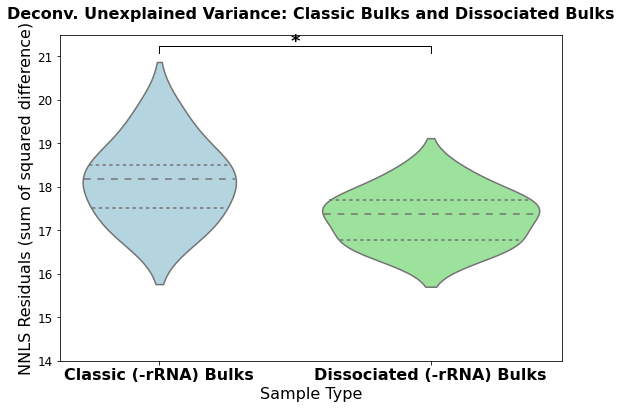

In [378]:
# Sample data for "Classic Bulks" and "Dissociated Bulks"
bulk_type_1 = calc_res_tot_bulks.values[0]
bulk_type_2 = calc_res_tot_dissbulks.values[0]

# Combine data into a DataFrame
df = pd.DataFrame({'Sample Type': ['BulkType1'] * len(bulk_type_1) +
                                  ['BulkType2'] * len(bulk_type_2),
                   'Residuals': np.concatenate([bulk_type_1, bulk_type_2])})

# Create a figure and axis for violin plots
plt.figure(figsize=(9, 6))
ax = plt.gca()

# Create violin plots for the two datasets
sns.violinplot(x='Sample Type', y='Residuals', data=df, ax=ax, inner='quartile', palette=['lightblue', 'lightgreen'])

# Add labels to the x-axis
ax.set_xticklabels(['Classic (-rRNA) Bulks', 'Dissociated (-rRNA) Bulks'], fontsize=16, fontname='Arial',fontweight='bold')

# Calculate p-value for the Wilcoxon signed-rank test
t_statistic, p_value = wilcoxon(bulk_type_1, bulk_type_2)

# Set a significance level (e.g., 0.05)
alpha = 0.05

#getting maximum value for significance line:
max_val = np.max([max(bulk_type_1),max(bulk_type_2)])

# Determine if the difference is statistically significant
if p_value < alpha:
    significance_label = f"Significant p={np.round(p_value, 3)}"
    asterisks = vp.convert_pvalue_to_asterisks(p_value)
    x1, x2 = 0, 1
    y1, y2 = max_val + 1.4, max_val +1.55
    # Add a line and asterisks to indicate statistical significance
    plt.plot([x1, x1, x2, x2], [y1, y2, y2, y1], linewidth=1, color='black')
    plt.text((x1 + x2) / 2, y2-.1, asterisks, ha='center', va='bottom', fontsize=18, fontweight='bold', 
                    fontname='Arial')
else:
    significance_label = f"Not Significant p={np.round(p_value, 3)}"
    x1, x2 = 0, 1
    y1, y2 = max_val + 1.4, max_val +1.55
    # Add a line and asterisks to indicate statistical significance
    plt.plot([x1, x1, x2, x2], [y1, y2, y2, y1], linewidth=1, color='black')
    plt.text((x1 + x2) / 2, y2-.25, "N.S.", ha='center', va='bottom', fontsize=18, fontweight='bold', 
                    fontname='Arial', x=0.5, y=1.03)

plt.xlabel('Sample Type', fontsize=16, fontname='Arial')
plt.ylabel('NNLS Residuals (sum of squared difference)', fontsize=16, fontname='Arial')
plt.title('Deconv. Unexplained Variance: Classic Bulks and Dissociated Bulks', fontsize=16, 
                fontname='Arial', fontweight='bold', x=0.5, y=1.03)
plt.ylim(14, 21.5)
plt.show()

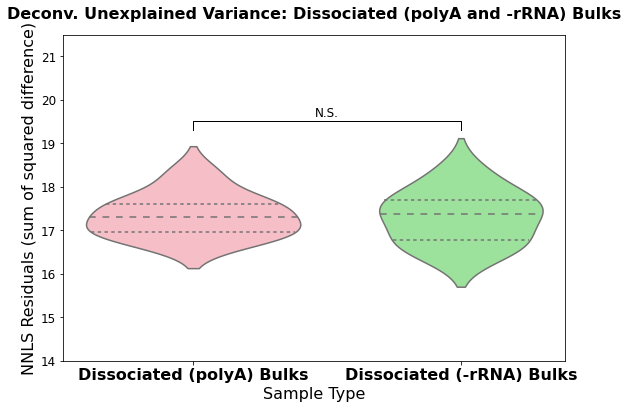

In [379]:
# Sample data for "Classic Bulks" and "Dissociated Bulks"
bulk_type_1 = calc_res_tot_disspolyabulks.values[0]
bulk_type_2 = calc_res_tot_dissbulks.values[0]

# Combine data into a DataFrame
df = pd.DataFrame({'Sample Type': ['BulkType1'] * len(bulk_type_1) +
                                  ['BulkType2'] * len(bulk_type_2),
                   'Residuals': np.concatenate([bulk_type_1, bulk_type_2])})

# Create a figure and axis for violin plots
plt.figure(figsize=(9, 6))
ax = plt.gca()

# Create violin plots for the two datasets
sns.violinplot(x='Sample Type', y='Residuals', data=df, ax=ax, inner='quartile', 
                palette=['lightpink', 'lightgreen'])

# Add labels to the x-axis
ax.set_xticklabels(['Dissociated (polyA) Bulks', 'Dissociated (-rRNA) Bulks'], fontsize=16, 
                fontname='Arial',fontweight='bold')

# Calculate p-value for the Wilcoxon signed-rank test
# Perform the paired t-test
t_statistic, p_value = wilcoxon(bulk_type_1, bulk_type_2)

# Set a significance level (e.g., 0.05)
alpha = 0.05

#getting maximum value for significance line:
max_val = np.max([max(bulk_type_1),max(bulk_type_2)])

# Determine if the difference is statistically significant
if p_value < alpha:
    significance_label = f"Significant p={np.round(p_value, 3)}"
    asterisks = vp.convert_pvalue_to_asterisks(p_value)
    x1, x2 = 0, 1
    y1, y2 = max_val + 1, max_val +1.55
    # Add a line and asterisks to indicate statistical significance
    plt.plot([x1, x1, x2, x2], [y1, y2, y2, y1], linewidth=1, color='black')
    plt.text((x1 + x2) / 2, y2, asterisks, ha='center', va='bottom', fontsize=18, fontweight='bold', 
                    fontname='Arial')
else:
    significance_label = f"Not Significant p={np.round(p_value, 3)}"
    significance_label = f"Significant p={np.round(p_value, 3)}"
    asterisks = vp.convert_pvalue_to_asterisks(p_value)
    x1, x2 = 0, 1
    y1, y2 = max_val + 1, max_val +1.2
    # Add a line and asterisks to indicate statistical significance
    plt.plot([x1, x1, x2, x2], [y1, y2, y2, y1], linewidth=1, color='black')
    plt.text((x1 + x2) / 2, y2+0.03, s='N.S.', ha='center', va='bottom', fontsize=12, 
                    fontname='Arial')
    # No asterisks for non-significant results

plt.xlabel('Sample Type', fontsize=16, fontname='Arial')
plt.ylabel('NNLS Residuals (sum of squared difference)', fontsize=16, fontname='Arial')
plt.title('Deconv. Unexplained Variance: Dissociated (polyA and -rRNA) Bulks', 
                fontsize=16, fontname='Arial', fontweight='bold', x=0.5, y=1.03)
plt.ylim(14, 21.5)
plt.show()

## Residuals Prep

Putting bulks together for multiplication:

Recreate Matrices:

In [380]:
#recreate matrix with calculated proportion nnls and multiplying by the used reference
bulks_recreated_mat_all = pd.DataFrame(all_refs @ calc_prop_tot_bulks.T)
bulks_recreated_mat_all = bulks_recreated_mat_all.T
bulks_recreated_mat_all.columns = gene_ids
bulks_recreated_mat_all   

,A1BG,A2M,AAGAB,AASS,AATF,AATK,ABAT,ABCA1,ABCA5,ABCB1,...,ZNHIT1,ZNHIT3,ZNRF1,ZNRF3,ZPR1,ZRSR2,ZSCAN18,ZSWIM8,ZXDC,ZYX
2497,0.344458,0.584808,0.198282,0.312634,0.404091,0.073345,0.098321,0.817627,0.358876,0.061496,...,0.720635,0.248992,0.274225,0.299620,0.200354,0.198814,0.244318,0.193990,0.338589,0.640848
2467,0.342051,0.448216,0.212860,0.240054,0.399866,0.056040,0.107178,0.768294,0.358476,0.046091,...,0.713117,0.245090,0.317139,0.316115,0.217581,0.187644,0.268002,0.191382,0.396599,0.613499
2380,0.226017,0.665452,0.236706,0.434021,0.458676,0.097962,0.111059,0.888082,0.446755,0.223495,...,0.679142,0.208254,0.295720,0.338478,0.164979,0.211493,0.208253,0.241743,0.360025,0.650208
2293,0.358171,0.622562,0.275051,0.169567,0.457162,0.085250,0.103741,0.824243,0.310560,0.040644,...,0.808159,0.243699,0.309145,0.230602,0.224638,0.270324,0.189264,0.220518,0.320525,0.765547
2283,0.319809,0.499663,0.211470,0.299267,0.419164,0.061767,0.106079,0.782092,0.379093,0.088115,...,0.709060,0.248248,0.326552,0.335008,0.212890,0.188117,0.272887,0.205616,0.393006,0.628284
2428,0.296210,0.405314,0.222028,0.298264,0.395203,0.045908,0.115419,0.784424,0.449206,0.050525,...,0.613380,0.224494,0.313587,0.367405,0.193455,0.190015,0.260343,0.212612,0.445577,0.519945
2251,0.295334,0.744646,0.252498,0.317434,0.426711,0.078646,0.101956,0.972839,0.438927,0.082334,...,0.691116,0.186329,0.239574,0.285821,0.153484,0.242294,0.145650,0.227845,0.345238,0.564589
2267,0.260297,0.709153,0.264624,0.341809,0.473976,0.117372,0.111453,0.914605,0.373475,0.200640,...,0.769277,0.205333,0.280211,0.267762,0.177630,0.240922,0.178404,0.230433,0.316142,0.736266


In [381]:
#recreate matrix with calculated proportion nnls and multiplying by the used reference
dissbulks_recreated_mat_all = pd.DataFrame(all_refs @ calc_prop_tot_dissbulks.T)
dissbulks_recreated_mat_all = dissbulks_recreated_mat_all.T
dissbulks_recreated_mat_all.columns = gene_ids
dissbulks_recreated_mat_all 

,A1BG,A2M,AAGAB,AASS,AATF,AATK,ABAT,ABCA1,ABCA5,ABCB1,...,ZNHIT1,ZNHIT3,ZNRF1,ZNRF3,ZPR1,ZRSR2,ZSCAN18,ZSWIM8,ZXDC,ZYX
2497,0.351684,0.687827,0.185617,0.332823,0.431642,0.085188,0.087297,0.827347,0.307709,0.130825,...,0.789887,0.259827,0.270462,0.264806,0.206958,0.204908,0.246915,0.183979,0.284499,0.695898
2467,0.304327,0.790343,0.248458,0.313564,0.462892,0.087865,0.092667,0.928977,0.373143,0.152783,...,0.770357,0.212312,0.272229,0.262564,0.181890,0.245673,0.176504,0.224747,0.307237,0.670490
2380,0.306550,0.789762,0.220269,0.364964,0.478970,0.115018,0.094122,0.907708,0.312711,0.233239,...,0.840907,0.234761,0.269650,0.241561,0.191897,0.232440,0.211310,0.201897,0.263144,0.740909
2293,0.334500,0.670580,0.236510,0.218700,0.454738,0.085881,0.089750,0.823846,0.277647,0.182774,...,0.830137,0.229222,0.287400,0.216459,0.216390,0.235304,0.214043,0.187067,0.289501,0.726798
2283,0.348422,0.611648,0.198270,0.300282,0.433190,0.073480,0.094393,0.812157,0.324161,0.117980,...,0.782110,0.257253,0.302292,0.287550,0.216231,0.200272,0.264539,0.189256,0.331270,0.666038
2428,0.348457,0.627523,0.202752,0.213640,0.423159,0.064351,0.086652,0.802248,0.280483,0.124500,...,0.791447,0.231578,0.279955,0.232979,0.210647,0.199804,0.221220,0.167603,0.307886,0.660100
2251,0.272123,0.824826,0.215106,0.302156,0.479149,0.072606,0.075944,0.881107,0.314767,0.306089,...,0.803774,0.197048,0.281740,0.225684,0.181922,0.216611,0.179497,0.190419,0.277814,0.645037
2267,0.378188,0.817161,0.280960,0.153458,0.489750,0.099079,0.092547,0.878046,0.275967,0.113298,...,0.883018,0.234429,0.255035,0.139959,0.206364,0.337401,0.110310,0.213766,0.229190,0.792911


In [382]:
#recreate matrix with calculated proportion nnls and multiplying by the used reference
disspolyabulks_recreated_mat_all = pd.DataFrame(all_refs @ calc_prop_tot_disspolyabulks.T)
disspolyabulks_recreated_mat_all = disspolyabulks_recreated_mat_all.T
disspolyabulks_recreated_mat_all.columns = gene_ids
disspolyabulks_recreated_mat_all 

,A1BG,A2M,AAGAB,AASS,AATF,AATK,ABAT,ABCA1,ABCA5,ABCB1,...,ZNHIT1,ZNHIT3,ZNRF1,ZNRF3,ZPR1,ZRSR2,ZSCAN18,ZSWIM8,ZXDC,ZYX
2497,0.360628,0.685606,0.177694,0.328365,0.432338,0.089761,0.083630,0.793851,0.276734,0.134322,...,0.804767,0.272581,0.270025,0.251355,0.216405,0.202744,0.255636,0.177478,0.262109,0.744302
2467,0.334178,0.833876,0.240186,0.300053,0.482004,0.107380,0.082865,0.873920,0.286267,0.171282,...,0.844011,0.246304,0.273397,0.216971,0.209112,0.255956,0.194030,0.214288,0.238329,0.816395
2380,0.316587,0.792036,0.217435,0.329055,0.478527,0.122053,0.089411,0.871165,0.260288,0.237246,...,0.866935,0.240377,0.260241,0.204491,0.200884,0.233287,0.204031,0.188600,0.227436,0.806780
2293,0.353292,0.656079,0.229302,0.201698,0.456943,0.094120,0.088583,0.793835,0.232922,0.178823,...,0.866298,0.245229,0.288703,0.196664,0.230333,0.233227,0.228030,0.175540,0.266772,0.783334
2283,0.365421,0.623330,0.192161,0.294416,0.440728,0.081236,0.089473,0.777445,0.282489,0.121478,...,0.814731,0.277193,0.305885,0.269609,0.231761,0.203372,0.278554,0.184274,0.300641,0.737159
2428,0.365069,0.619378,0.192535,0.172436,0.419944,0.068622,0.079013,0.741244,0.214512,0.126186,...,0.819109,0.244788,0.273536,0.193576,0.225788,0.196037,0.222789,0.149730,0.266394,0.738934
2251,0.274259,0.837405,0.202618,0.304252,0.488536,0.076670,0.068877,0.836939,0.273061,0.343621,...,0.829190,0.211186,0.287775,0.208095,0.193951,0.211809,0.192930,0.181664,0.247410,0.703127
2267,0.401299,0.845830,0.272809,0.137649,0.481231,0.109483,0.083452,0.862223,0.220514,0.105746,...,0.912290,0.244665,0.238654,0.115657,0.217243,0.325285,0.123177,0.200098,0.189930,0.874514


In [383]:
calc_prop_tot_combo

,fat cell,Plasma cells,Monocytes,T cells,Endothelial cells,NK cells,Epithelial cells,ILC,Fibroblasts,B cells,DC,Macrophages,pDC,Mast cells,Erythroid
2497,0.237570,0.097225,0.000000,0.000000,0.015176,0.000000,0.315511,0.006132,0.231435,0.00000,0.0,0.056034,0.0,0.000000,0.040918
2467,0.283245,0.086154,0.000000,0.000000,0.000000,0.000000,0.537627,0.010743,0.000000,0.00000,0.0,0.080937,0.0,0.001293,0.000000
2380,0.332473,0.000000,0.100079,0.000000,0.241784,0.000000,0.000000,0.000000,0.259319,0.00000,0.0,0.043158,0.0,0.000000,0.023186
2293,0.192281,0.007582,0.000000,0.034762,0.000000,0.000000,0.347143,0.000000,0.000000,0.00000,0.0,0.413390,0.0,0.004842,0.000000
2283,0.305113,0.042985,0.000000,0.000000,0.067185,0.000000,0.459811,0.000000,0.071633,0.00000,0.0,0.053274,0.0,0.000000,0.000000
2428,0.382356,0.069888,0.000000,0.000000,0.000000,0.000000,0.464088,0.008111,0.000000,0.02742,0.0,0.048137,0.0,0.000000,0.000000
2251,0.245521,0.226353,0.000000,0.001584,0.019971,0.000000,0.015981,0.000000,0.226106,0.00553,0.0,0.250463,0.0,0.000000,0.008490
2267,0.235040,0.018983,0.137929,0.000000,0.214126,0.000000,0.000000,0.000000,0.201944,0.00000,0.0,0.185165,0.0,0.000000,0.006813
2497,0.156500,0.125572,0.009677,0.000000,0.110356,0.000000,0.221866,0.000000,0.324268,0.00000,0.0,0.012855,0.0,0.000000,0.038906
2467,0.194221,0.150277,0.000000,0.000000,0.130755,0.000000,0.054813,0.000000,0.224444,0.00000,0.0,0.245489,0.0,0.000000,0.000000


In [384]:
#recreate matrix with calculated proportion nnls and multiplying by the used reference
combo_recreated_mat_all = pd.DataFrame(all_refs @ calc_prop_tot_combo.T)
combo_recreated_mat_all = combo_recreated_mat_all.T
combo_recreated_mat_all.columns = gene_ids
combo_recreated_mat_all 

,A1BG,A2M,AAGAB,AASS,AATF,AATK,ABAT,ABCA1,ABCA5,ABCB1,...,ZNHIT1,ZNHIT3,ZNRF1,ZNRF3,ZPR1,ZRSR2,ZSCAN18,ZSWIM8,ZXDC,ZYX
2497,0.344458,0.584808,0.198282,0.312634,0.404091,0.073345,0.098321,0.817627,0.358876,0.061496,...,0.720635,0.248992,0.274225,0.299620,0.200354,0.198814,0.244318,0.193990,0.338589,0.640848
2467,0.342051,0.448216,0.212860,0.240054,0.399866,0.056040,0.107178,0.768294,0.358476,0.046091,...,0.713117,0.245090,0.317139,0.316115,0.217581,0.187644,0.268002,0.191382,0.396599,0.613499
2380,0.226017,0.665452,0.236706,0.434021,0.458676,0.097962,0.111059,0.888082,0.446755,0.223495,...,0.679142,0.208254,0.295720,0.338478,0.164979,0.211493,0.208253,0.241743,0.360025,0.650208
2293,0.358171,0.622562,0.275051,0.169567,0.457162,0.085250,0.103741,0.824243,0.310560,0.040644,...,0.808159,0.243699,0.309145,0.230602,0.224638,0.270324,0.189264,0.220518,0.320525,0.765547
2283,0.319809,0.499663,0.211470,0.299267,0.419164,0.061767,0.106079,0.782092,0.379093,0.088115,...,0.709060,0.248248,0.326552,0.335008,0.212890,0.188117,0.272887,0.205616,0.393006,0.628284
2428,0.296210,0.405314,0.222028,0.298264,0.395203,0.045908,0.115419,0.784424,0.449206,0.050525,...,0.613380,0.224494,0.313587,0.367405,0.193455,0.190015,0.260343,0.212612,0.445577,0.519945
2251,0.295334,0.744646,0.252498,0.317434,0.426711,0.078646,0.101956,0.972839,0.438927,0.082334,...,0.691116,0.186329,0.239574,0.285821,0.153484,0.242294,0.145650,0.227845,0.345238,0.564589
2267,0.260297,0.709153,0.264624,0.341809,0.473976,0.117372,0.111453,0.914605,0.373475,0.200640,...,0.769277,0.205333,0.280211,0.267762,0.177630,0.240922,0.178404,0.230433,0.316142,0.736266
2497,0.351684,0.687827,0.185617,0.332823,0.431642,0.085188,0.087297,0.827347,0.307709,0.130825,...,0.789887,0.259827,0.270462,0.264806,0.206958,0.204908,0.246915,0.183979,0.284499,0.695898
2467,0.304327,0.790343,0.248458,0.313564,0.462892,0.087865,0.092667,0.928977,0.373143,0.152783,...,0.770357,0.212312,0.272229,0.262564,0.181890,0.245673,0.176504,0.224747,0.307237,0.670490


## **Calculate Residuals:**

1. Residual uses:

pseudobulks - recreated_mat_all (reference used normalized (all_refs) * calculated proportions (calc_prop_tot))

In [385]:
#Classic Bulks: Residual as the the difference between the recreated matrix and pseudobulks.
res = bulks.values - bulks_recreated_mat_all.values
residuals_bulks = pd.DataFrame(res, columns = bulks_recreated_mat_all.columns, index = sample_ids)
residuals_bulks

,A1BG,A2M,AAGAB,AASS,AATF,AATK,ABAT,ABCA1,ABCA5,ABCB1,...,ZNHIT1,ZNHIT3,ZNRF1,ZNRF3,ZPR1,ZRSR2,ZSCAN18,ZSWIM8,ZXDC,ZYX
2497,-0.313582,0.415192,0.011447,0.023116,-0.163257,0.003503,0.114382,0.182373,-0.127190,-0.016668,...,-0.441148,-0.177634,-0.195090,-0.131288,0.100174,-0.149870,0.249472,0.296599,0.069892,0.359152
2467,-0.307895,0.551784,0.011547,0.029682,-0.073629,0.235083,0.035191,0.231706,-0.019471,-0.035876,...,-0.381135,-0.153795,-0.113481,-0.092027,0.104186,-0.115821,0.013225,0.321594,0.380686,0.077918
2380,-0.219620,0.334548,-0.024498,0.314000,-0.166615,-0.036418,-0.004073,0.111918,-0.032708,-0.114744,...,-0.528700,-0.148474,-0.227999,-0.150976,0.310171,-0.172007,-0.079870,0.280393,-0.151788,0.111268
2293,-0.340797,0.377438,0.061870,-0.091213,-0.131823,-0.034831,0.148354,0.175757,-0.080267,-0.008961,...,-0.515524,-0.133323,-0.207626,-0.170644,0.059820,-0.157903,-0.059469,0.296277,0.218754,-0.016416
2283,-0.244953,0.500337,0.108165,-0.064968,-0.173637,0.018578,0.011445,0.217908,-0.106868,0.010945,...,-0.353495,-0.157423,-0.110468,-0.054049,0.217032,-0.098290,0.484655,0.794384,0.122751,-0.292930
2428,-0.259273,0.594686,-0.017524,-0.211777,-0.019527,0.132470,-0.043347,0.215576,0.550794,-0.032056,...,-0.444912,-0.124494,-0.213136,0.038901,0.113301,-0.158934,0.176594,0.450001,0.374243,-0.266342
2251,-0.274084,0.255354,-0.061770,0.078714,-0.186923,0.000584,0.025546,0.027161,-0.037794,0.001881,...,-0.479399,-0.106837,-0.152998,-0.190325,0.088140,-0.124761,0.121160,0.518278,0.127254,0.312710
2267,-0.252316,0.290847,-0.010109,-0.044727,-0.182805,-0.024256,-0.007696,0.085395,-0.091764,-0.088015,...,-0.589845,-0.153011,-0.156648,-0.122620,0.287355,-0.152241,-0.026759,0.318800,-0.056601,0.263734


In [386]:
#Dissociated dissbulks: Residual as the the difference between the recreated matrix and pseudodissbulks.
res = diss_bulks.values - dissbulks_recreated_mat_all.values
residuals_dissbulks = pd.DataFrame(res, columns = dissbulks_recreated_mat_all.columns, index = sample_ids)
residuals_dissbulks

,A1BG,A2M,AAGAB,AASS,AATF,AATK,ABAT,ABCA1,ABCA5,ABCB1,...,ZNHIT1,ZNHIT3,ZNRF1,ZNRF3,ZPR1,ZRSR2,ZSCAN18,ZSWIM8,ZXDC,ZYX
2497,-0.308934,0.312173,-0.003767,0.128746,-0.198579,0.053911,0.032056,0.172653,-0.137578,-0.018634,...,-0.458521,-0.197546,-0.192124,-0.140897,0.211861,-0.159337,0.266084,0.301460,0.074210,0.304102
2467,-0.275208,0.209657,-0.091359,0.080440,-0.214483,0.061324,-0.033350,0.071023,-0.068293,-0.049249,...,-0.505052,-0.133943,-0.129151,-0.150402,0.059689,-0.152924,0.039551,0.482374,0.115526,0.329510
2380,-0.284117,0.210238,-0.024121,0.070282,-0.160537,0.253478,-0.033390,0.092292,-0.061302,-0.087974,...,-0.612751,-0.179227,-0.178826,-0.046233,0.391897,-0.181830,-0.054282,0.402414,0.073345,0.259091
2293,-0.321184,0.329420,0.058938,0.194372,-0.140149,0.020647,0.002630,0.176154,-0.129785,-0.099272,...,-0.562709,-0.156816,-0.180873,-0.003681,0.489910,-0.109635,0.004283,0.220456,0.090003,0.273202
2283,-0.303567,0.388352,0.019217,0.016063,-0.180881,0.062265,-0.024160,0.187843,-0.160971,0.002125,...,-0.464289,-0.186724,-0.150907,-0.004551,0.615947,-0.122661,0.207914,0.724368,0.252139,0.045444
2428,-0.280183,0.372477,-0.010042,-0.034144,-0.093166,0.602242,-0.050679,0.197752,0.216893,-0.042277,...,-0.581485,-0.190100,-0.215718,-0.059356,0.493020,-0.172641,0.122722,0.332342,0.437994,-0.058845
2251,-0.254209,0.175174,-0.042128,0.156601,-0.193091,0.114927,-0.016885,0.118893,-0.053060,-0.009675,...,-0.591609,-0.156463,-0.184895,-0.085454,0.417625,-0.142158,0.088648,0.250704,0.166108,0.227972
2267,-0.355684,0.182839,-0.090876,0.007180,-0.189781,-0.038271,-0.015460,0.121954,-0.134241,-0.019214,...,-0.657263,-0.174339,-0.171484,-0.122004,0.287280,-0.212195,-0.022450,0.256656,0.047317,0.207089


In [387]:
#Dissociated dissbulks: Residual as the the difference between the recreated matrix and pseudodissbulks.
residuals_disspolyabulks = pd.DataFrame()
res = disspolya_bulks.values - disspolyabulks_recreated_mat_all.values
residuals_disspolyabulks = pd.DataFrame(res, columns = disspolyabulks_recreated_mat_all.columns, index = sample_ids)
residuals_disspolyabulks

,A1BG,A2M,AAGAB,AASS,AATF,AATK,ABAT,ABCA1,ABCA5,ABCB1,...,ZNHIT1,ZNHIT3,ZNRF1,ZNRF3,ZPR1,ZRSR2,ZSCAN18,ZSWIM8,ZXDC,ZYX
2497,-0.337731,0.314394,-0.008427,0.165609,-0.222643,-0.029762,0.033421,-0.072803,-0.104897,-0.048555,...,-0.504922,-0.214622,-0.196046,-0.171331,0.173817,-0.139873,0.223905,0.393724,0.045898,0.255698
2467,-0.305600,0.166124,-0.070685,0.139468,-0.237607,-0.006861,-0.032606,0.126080,-0.044629,-0.093626,...,-0.498307,-0.156626,-0.133263,-0.149959,0.030949,-0.073644,0.057069,0.762120,0.134771,0.183605
2380,-0.306056,0.207964,-0.013527,0.164537,-0.183006,-0.049600,-0.041448,0.128835,-0.005498,-0.129645,...,-0.630036,-0.182643,-0.178779,-0.096002,0.417058,-0.126321,-0.085137,0.429342,0.027227,0.193220
2293,-0.346434,0.343921,0.063216,0.264864,-0.207226,-0.047771,0.008844,0.206165,-0.115867,-0.114266,...,-0.575435,-0.187766,-0.154859,-0.020728,0.423753,-0.044284,-0.005508,0.264301,0.029529,0.216666
2283,-0.348907,0.376670,0.018341,0.054051,-0.192389,-0.027931,-0.016100,0.104908,-0.116930,-0.011732,...,-0.478597,-0.207375,-0.128620,-0.026706,0.496322,-0.083384,0.152693,0.815726,0.174504,0.262841
2428,-0.336786,0.380622,0.003377,-0.022053,-0.151370,0.086130,-0.052570,0.258756,0.101660,-0.051684,...,-0.576059,-0.185003,-0.227548,-0.087112,0.487956,-0.162696,0.064180,0.323493,0.428724,0.247522
2251,-0.264974,0.162595,-0.058276,0.172502,-0.242056,-0.008128,-0.023802,0.163061,-0.031308,-0.109634,...,-0.621371,-0.167968,-0.185300,-0.106971,0.378186,-0.109841,0.043083,0.253897,0.112687,0.296873
2267,-0.389241,0.154170,-0.077446,0.029929,-0.233446,-0.073137,-0.007439,0.137777,-0.065168,-0.037597,...,-0.670796,-0.179312,-0.153555,-0.104997,0.244427,-0.124856,-0.038252,0.318713,0.029197,0.125486


In [388]:
#Dissociated combo: Residual as the the difference between the recreated matrix and pseudocombo.
residuals_combo = pd.DataFrame()
res = combo.values - combo_recreated_mat_all.values
residuals_combo = pd.DataFrame(res, columns = combo_recreated_mat_all.columns)
residuals_combo.index = np.concatenate([residuals_bulks.index.values, residuals_dissbulks.index.values])
residuals_combo

,A1BG,A2M,AAGAB,AASS,AATF,AATK,ABAT,ABCA1,ABCA5,ABCB1,...,ZNHIT1,ZNHIT3,ZNRF1,ZNRF3,ZPR1,ZRSR2,ZSCAN18,ZSWIM8,ZXDC,ZYX
2497,-0.313582,0.415192,0.011447,0.023116,-0.163257,0.003503,0.114382,0.182373,-0.127190,-0.016668,...,-0.441148,-0.177634,-0.195090,-0.131288,0.100174,-0.149870,0.249472,0.296599,0.069892,0.359152
2467,-0.307895,0.551784,0.011547,0.029682,-0.073629,0.235083,0.035191,0.231706,-0.019471,-0.035876,...,-0.381135,-0.153795,-0.113481,-0.092027,0.104186,-0.115821,0.013225,0.321594,0.380686,0.077918
2380,-0.219620,0.334548,-0.024498,0.314000,-0.166615,-0.036418,-0.004073,0.111918,-0.032708,-0.114744,...,-0.528700,-0.148474,-0.227999,-0.150976,0.310171,-0.172007,-0.079870,0.280393,-0.151788,0.111268
2293,-0.340797,0.377438,0.061870,-0.091213,-0.131823,-0.034831,0.148354,0.175757,-0.080267,-0.008961,...,-0.515524,-0.133323,-0.207626,-0.170644,0.059820,-0.157903,-0.059469,0.296277,0.218754,-0.016416
2283,-0.244953,0.500337,0.108165,-0.064968,-0.173637,0.018578,0.011445,0.217908,-0.106868,0.010945,...,-0.353495,-0.157423,-0.110468,-0.054049,0.217032,-0.098290,0.484655,0.794384,0.122751,-0.292930
2428,-0.259273,0.594686,-0.017524,-0.211777,-0.019527,0.132470,-0.043347,0.215576,0.550794,-0.032056,...,-0.444912,-0.124494,-0.213136,0.038901,0.113301,-0.158934,0.176594,0.450001,0.374243,-0.266342
2251,-0.274084,0.255354,-0.061770,0.078714,-0.186923,0.000584,0.025546,0.027161,-0.037794,0.001881,...,-0.479399,-0.106837,-0.152998,-0.190325,0.088140,-0.124761,0.121160,0.518278,0.127254,0.312710
2267,-0.252316,0.290847,-0.010109,-0.044727,-0.182805,-0.024256,-0.007696,0.085395,-0.091764,-0.088015,...,-0.589845,-0.153011,-0.156648,-0.122620,0.287355,-0.152241,-0.026759,0.318800,-0.056601,0.263734
2497,-0.308934,0.312173,-0.003767,0.128746,-0.198579,0.053911,0.032056,0.172653,-0.137578,-0.018634,...,-0.458521,-0.197546,-0.192124,-0.140897,0.211861,-0.159337,0.266084,0.301460,0.074210,0.304102
2467,-0.275208,0.209657,-0.091359,0.080440,-0.214483,0.061324,-0.033350,0.071023,-0.068293,-0.049249,...,-0.505052,-0.133943,-0.129151,-0.150402,0.059689,-0.152924,0.039551,0.482374,0.115526,0.329510


## Comparing Residuals

In [389]:
adip_markers = np.intersect1d(adip_markers, residuals_bulks.columns)
diss_response= np.intersect1d(diss_response, residuals_bulks.columns)
cibersort_genes= np.intersect1d(cibersort_genes, residuals_bulks.columns)

Residual Correlation: Classic vs. Dissociated

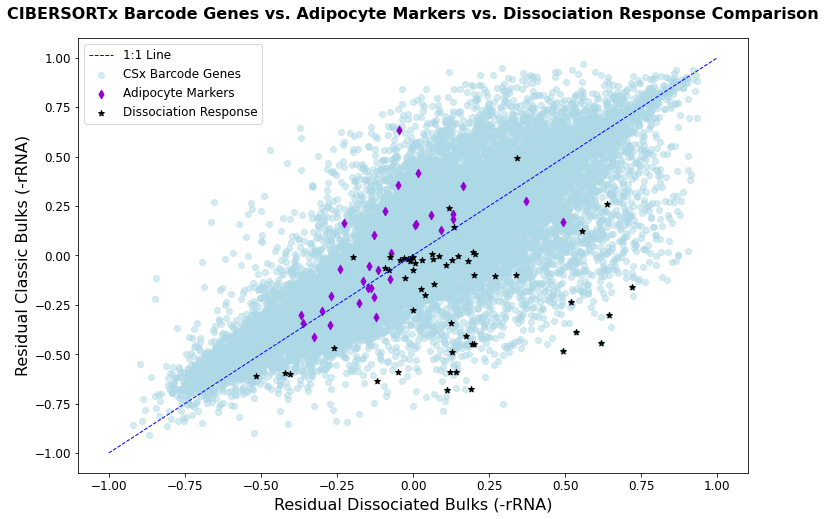

In [390]:
# Create a scatter plot with labels for multiple genes
plt.figure(figsize=(12, 8))

# Plot CIBERSORT genes
genes_of_interest = cibersort_genes
for gene in genes_of_interest:
    gene_data_bulks = residuals_bulks[gene]
    gene_data_dissbulks = residuals_dissbulks[gene]
    plt.scatter(gene_data_dissbulks, gene_data_bulks, alpha=0.5, c='lightblue',
                    label='CSx Barcode Genes' if gene == genes_of_interest[0] else "")

# Plot Adipocyte markers
for gene in adip_markers:
    gene_data_bulks = residuals_bulks[gene]
    gene_data_dissbulks = residuals_dissbulks[gene]
    plt.scatter(gene_data_dissbulks, gene_data_bulks, alpha=1, c='darkviolet', marker='d', 
                    label='Adipocyte Markers' if gene == adip_markers[0] else "")

# Plot Dissociation Response genes
for gene in diss_response:
    gene_data_bulks = residuals_bulks[gene]
    gene_data_dissbulks = residuals_dissbulks[gene]
    plt.scatter(gene_data_dissbulks, gene_data_bulks, alpha=1, c='black', marker='*', 
                    label='Dissociation Response' if gene == diss_response[0] else "")

# Plot 1:1 Line
plt.plot([-1, 1], [-1, 1], label='1:1 Line', color='blue', linewidth=1, linestyle='--')

# Set axis labels and title
plt.title('CIBERSORTx Barcode Genes vs. Adipocyte Markers vs. Dissociation Response Comparison', 
                fontsize=16, fontname='Arial', fontweight='bold', x=0.5, y=1.03)
plt.ylabel('Residual Classic Bulks (-rRNA)', fontsize=16, fontname='Arial')
plt.xlabel('Residual Dissociated Bulks (-rRNA)', fontsize=16, fontname='Arial')


# Add legend
plt.legend()

# Show the plot
plt.show()

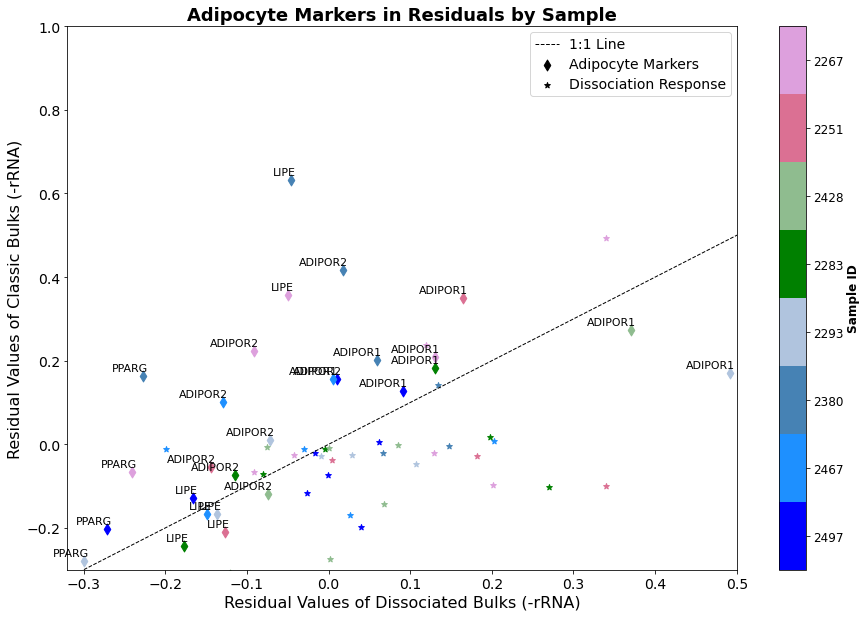

In [391]:
#making copy for numerated index:
res_dissbulks_copy = residuals_dissbulks.copy()
res_bulks_copy = residuals_bulks.copy()

res_dissbulks_copy.index = range(0,8)
res_bulks_copy.index = range(0,8)

row_indices = sample_ids *2
# Define custom colors
custom_colors = ['blue', 'dodgerblue','steelblue','lightsteelblue','green','darkseagreen', 'palevioletred', 'plum']

# Create a custom colormap
cmap_custom = mcolors.ListedColormap(custom_colors)
marker_size = 100

# Create a sc_atter plot with labels for multiple genes
plt.figure(figsize=(15, 10))

# Get unique colors for each sample using the previously defined custom colormap
unique_colors = mcolors.ListedColormap(custom_colors)(np.arange(len(res_bulks_copy)))
# Plot each gene for both bulks and dissbulks
for sample_idx, sample_color in enumerate(unique_colors):

    # Plot Adipocyte markers
    for gene in adip_markers:

        gene_data_bulks = res_bulks_copy.at[sample_idx, gene]
        gene_data_dissbulks = res_dissbulks_copy.at[sample_idx, gene]
        marker_size = 60  # Increase size for the first Adipocyte marker
        plt.scatter(gene_data_dissbulks, gene_data_bulks, alpha=1, c=[sample_color], marker='d', s=marker_size,
                    label='Adipocyte Markers' if gene == adip_markers[0] and sample_idx == 0 else "")
        plt.annotate(str(gene), (gene_data_dissbulks, gene_data_bulks), textcoords="offset points", xytext=(5, 5),
                     ha='right', fontsize=11)

    # Plot Dissociation Response genes
    for gene in diss_response:
        gene_data_bulks = res_bulks_copy.at[sample_idx, gene]
        gene_data_dissbulks = res_dissbulks_copy.at[sample_idx, gene]
        plt.scatter(gene_data_dissbulks, gene_data_bulks, alpha=1, c=[sample_color], marker='*',
                    label='Dissociation Response' if gene == diss_response[0] and sample_idx == 0 else "")

# Plot 1:1 Line
plt.plot([-1, 1], [-1, 1], label='1:1 Line', color='black', linewidth=1, linestyle='--')

# Set axis labels and title
plt.title('Adipocyte Markers in Residuals by Sample', fontsize=18, fontname='Arial', fontweight='bold')
plt.ylabel('Residual Values of Classic Bulks (-rRNA)', fontsize=16, fontname='Arial')
plt.xlabel('Residual Values of Dissociated Bulks (-rRNA)', fontsize=16, fontname='Arial')

# Add legend
legend = plt.legend()
plt.xlim(-0.32, 0.5)
plt.ylim(-0.3, 1)
ax = plt.gca()
leg = ax.get_legend()
leg.legendHandles[1].set_color('black')
leg.legendHandles[2].set_color('black')

# Set font size and font family for legend
for text in legend.get_texts():
    text.set_fontsize(14)
    text.set_fontname('Arial')

# Set font size for tick labels
plt.xticks(fontsize=14, fontname='Arial')
plt.yticks(fontsize=14, fontname='Arial')

#add colorbar 
sc_ = plt.scatter([], [], c=[], cmap=cmap_custom, marker='d', s=marker_size)
colorbar = plt.colorbar(sc_, ticks=np.arange(len(custom_colors)), label='Sample Index', orientation='vertical')
colorbar.set_label("Sample ID", fontweight='bold')
colorbar.set_ticks([0+1/16,1/8+1/16,2/8+1/16,3/8+1/16,4/8+1/16,5/8+1/16,6/8+1/16,7/8+1/16,8/8+1/16])
colorbar.set_ticklabels(sample_ids)
# Show the plot
plt.show()


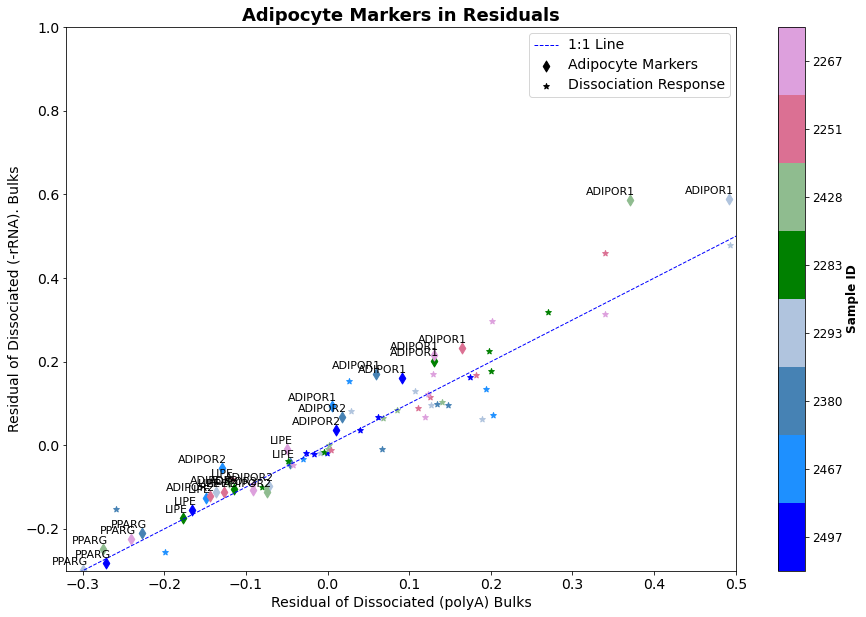

In [392]:
#making copy for numerated index:
res_dissbulks_copy = residuals_dissbulks.copy()
res_bulks_copy = residuals_disspolyabulks.copy()

res_dissbulks_copy.index = range(0,8)
res_bulks_copy.index = range(0,8)

row_indices = sample_ids *2
# Define custom colors
custom_colors = ['blue', 'dodgerblue','steelblue','lightsteelblue','green','darkseagreen', 'palevioletred', 'plum']

# Create a custom colormap
cmap_custom = mcolors.ListedColormap(custom_colors)
marker_size = 100

# Create a scatter plot with labels for multiple genes
plt.figure(figsize=(15, 10))

# Get unique colors for each sample using the previously defined custom colormap
unique_colors = mcolors.ListedColormap(custom_colors)(np.arange(len(res_bulks_copy)))
# Plot each gene for both bulks and dissbulks
for sample_idx, sample_color in enumerate(unique_colors):

    # Plot Adipocyte markers
    for gene in adip_markers:

        gene_data_bulks = res_bulks_copy.at[sample_idx, gene]
        gene_data_dissbulks = res_dissbulks_copy.at[sample_idx, gene]
        marker_size = 60  # Increase size for the first Adipocyte marker
        plt.scatter(gene_data_dissbulks, gene_data_bulks, alpha=1, c=[sample_color], marker='d', s=marker_size,
                    label='Adipocyte Markers' if gene == adip_markers[0] and sample_idx == 0 else "")
        plt.annotate(str(gene), (gene_data_dissbulks, gene_data_bulks), textcoords="offset points", xytext=(5, 5),
                     ha='right', fontsize=11)

    # Plot Dissociation Response genes
    for gene in diss_response:
        gene_data_bulks = res_bulks_copy.at[sample_idx, gene]
        gene_data_dissbulks = res_dissbulks_copy.at[sample_idx, gene]
        plt.scatter(gene_data_dissbulks, gene_data_bulks, alpha=1, c=[sample_color], marker='*',
                    label='Dissociation Response' if gene == diss_response[0] and sample_idx == 0 else "")

# Plot 1:1 Line
plt.plot([-1, 1], [-1, 1], label='1:1 Line', color='blue', linewidth=1, linestyle='--')

# Set axis labels and title
plt.title('Adipocyte Markers in Residuals', fontsize=18, fontname='Arial', fontweight='bold')
plt.ylabel('Residual of Dissociated (-rRNA). Bulks', fontsize=14, fontname='Arial')
plt.xlabel('Residual of Dissociated (polyA) Bulks', fontsize=14, fontname='Arial')

# Add legend
legend = plt.legend()
plt.xlim(-0.32, 0.5)
plt.ylim(-0.3, 1)

ax = plt.gca()
leg = ax.get_legend()
leg.legendHandles[1].set_color('black')
leg.legendHandles[2].set_color('black')

# Set font size and font family for legend
for text in legend.get_texts():
    text.set_fontsize(14)
    text.set_fontname('Arial')

# Set font size for tick labels
plt.xticks(fontsize=14, fontname='Arial')
plt.yticks(fontsize=14, fontname='Arial')
#add colorbar 
sc_ = plt.scatter([], [], c=[], cmap=cmap_custom, marker='d', s=marker_size)
colorbar = plt.colorbar(sc_, ticks=np.arange(len(custom_colors)), label='Sample Index', orientation='vertical')
colorbar.set_label("Sample ID", fontweight='bold')
colorbar.set_ticks([0+1/16,1/8+1/16,2/8+1/16,3/8+1/16,4/8+1/16,5/8+1/16,6/8+1/16,7/8+1/16,8/8+1/16])
colorbar.set_ticklabels(sample_ids)
# Show the plot
plt.show()


## Top Genes per Sample's Residual:

Analyzing the main genes in the Residual of the samples with high adipocyte markers:

In [393]:
# Extract the top genes
top_genes_per_sample_bulk = pd.DataFrame()

for num in range(0,8):

    row = residuals_bulks.values[num, :]  

    # Get the indices of the top 15 genes with the highest expression
    top_10_genes_indices = np.argsort(row)[::-1][:10]

    # Extract the gene names corresponding to the top 15 indices
    gene_names_top_10 = residuals_bulks.columns[top_10_genes_indices]  
    top_genes_per_sample_bulk[num] = gene_names_top_10
top_genes_per_sample_bulk.columns = sample_ids
top_genes_per_sample_bulk                                

,2497,2467,2380,2293,2283,2428,2251,2267
0,F13A1,AC136475.3,TNFSF14,NUP210,F13A1,ACPP,ATP8B2,ITPR3
1,NBEAL2,LY75,SLCO2B1,HID1,SRC,B4GALNT3,ITGB4,SIGLEC1
2,RAPGEF3,PLEKHA6,PPL,LY75,SDC1,FGD5,NBEAL2,MUC16
3,STAB1,CIITA,MRC1,NBEAL2,DTX4,NUP210,TEP1,NBEAL2
4,CD163,OBSCN,FAM110C,ITGB4,MEG8,CRB2,MEGF6,IL7R
5,PLCG1,TBC1D2,F13A1,CELSR1,OBSCN,ANPEP,OBSCN,SLC7A2
6,MYRF,TNC,MUC16,PSD4,NBEAL2,CLCN5,FUCA1,COL27A1
7,CD93,STAB1,CSF1R,NADSYN1,WDR91,LDB1,ABCC5,KMT2D
8,KMT2D,WDR91,KMT2D,ITGA3,STAB1,TFCP2L1,WDFY4,CHI3L1
9,CGN,PVR,C1QC,KMT2D,PLCG1,CMYA5,RASSF2,RASSF2


In [394]:
# Extract the top genes
top_genes_per_sample_dissbulk = pd.DataFrame()

for num in range(0,8):

    row = residuals_dissbulks.values[num, :]

    # Get the indices of the top 15 genes with the highest expression
    top_10_genes_indices = np.argsort(row)[::-1][:10]

    # Extract the gene names corresponding to the top 15 indices
    gene_names_top_10 = residuals_bulks.columns[top_10_genes_indices] 

    top_genes_per_sample_dissbulk[num] = gene_names_top_10
top_genes_per_sample_dissbulk.columns = sample_ids
top_genes_per_sample_dissbulk       

,2497,2467,2380,2293,2283,2428,2251,2267
0,STAB1,CELSR1,PPL,OBSCN,TFCP2L1,TFCP2L1,ITGA3,HK3
1,NBEAL2,OBSCN,TNFSF14,TUFT1,SEMA7A,NECTIN4,NBEAL2,NBEAL2
2,MYRF,RAPGEF3,OBSCN,CELSR1,LDB1,OBSCN,PLCG1,ARHGEF17
3,PLCG1,NBEAL2,MEGF6,PLCG1,OBSCN,PSD4,FAM110C,PSD4
4,RAPGEF3,ITGA3,ITGA3,YOD1,NBEAL2,PLCG1,KMT2D,THSD4
5,MFSD2A,PLCG1,ITPR3,NUP210,STAB1,TUFT1,TTN,KMT2D
6,FLT1,MICAL1,ITGB4,PSD4,CELSR1,CELSR1,NADSYN1,AMOTL2
7,CLSTN3,ABCC5,SLC12A7,SLC7A2,WDR91,YOD1,AMOTL2,CP
8,ITPR3,TEP1,SEMA3B,NBEAL2,PLCG1,PRSS22,H6PD,LTBP2
9,ITGA3,SIGLEC1,LAMA3,LAMB3,PLEKHG5,PLEKHG3,SH3TC1,MUC16


## Distributions of Residuals

Classic (-rRNA) Bulks and Dissociated (-rRNA) Bulks

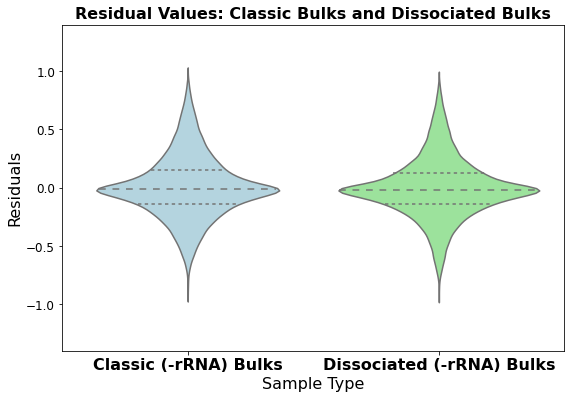

In [395]:
# Sample data for "Classic Bulks" and "Dissociated Bulks"
classic_bulks_values = residuals_bulks.values.flatten()
dissociated_bulks_values = residuals_dissbulks.values.flatten()

# Combine data into a DataFrame
df = pd.DataFrame({'Sample Type': ['Classic Bulks'] * len(classic_bulks_values) +
                                  ['Dissociated Bulks'] * len(dissociated_bulks_values),
                   'Residuals': np.concatenate([classic_bulks_values, dissociated_bulks_values])})

# Create a figure and axis for violin plots
plt.figure(figsize=(9, 6))
ax = plt.gca()

# Create violin plots for the two datasets
sns.violinplot(x='Sample Type', y='Residuals', data=df, ax=ax, inner='quartile', palette=['lightblue', 'lightgreen'])

# Add labels to the x-axis
ax.set_xticklabels(['Classic (-rRNA) Bulks', 'Dissociated (-rRNA) Bulks'], fontsize=16, fontweight='bold', fontname='Arial')

plt.xlabel('Sample Type', fontsize=16, fontname='Arial')
plt.ylabel('Residuals', fontsize=16, fontname='Arial')
plt.title('Residual Values: Classic Bulks and Dissociated Bulks', fontsize=16, fontname='Arial', fontweight='bold')
plt.ylim(-1.4, 1.4)
plt.show()

#These plots look very similar: could be due to certain genes being high in one distribution but low in the other one, 
#and the other way around, making them look visually the same but it's a different set of genes driving the high and lows.

Dissociated (polyA) Bulks and Dissociated (-rRNA) Bulks

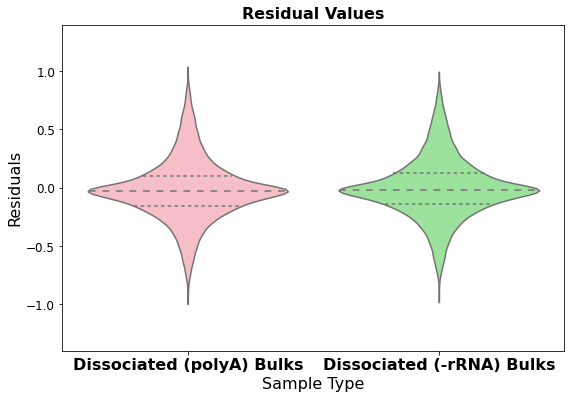

In [396]:
# Sample data for "Classic Bulks" and "Dissociated Bulks"
bulk_type_1 = residuals_disspolyabulks.values.flatten()
bulk_type_2 = residuals_dissbulks.values.flatten()

# Combine data into a DataFrame
df = pd.DataFrame({'Sample Type': ['Bulktype1'] * len(bulk_type_1) +
                                  ['Bulktype2'] * len(bulk_type_2),
                   'Residuals': np.concatenate([bulk_type_1, bulk_type_2])})

# Create a figure and axis for violin plots
plt.figure(figsize=(9, 6))
ax = plt.gca()

# Create violin plots for the two datasets
sns.violinplot(x='Sample Type', y='Residuals', data=df, ax=ax, inner='quartile', palette=[ 'lightpink','lightgreen'])
# Add labels to the x-axis
ax.set_xticklabels(['Dissociated (polyA) Bulks', 'Dissociated (-rRNA) Bulks'], fontsize=16, fontweight='bold', fontname='Arial')

plt.xlabel('Sample Type', fontsize=16, fontname='Arial')
plt.ylabel('Residuals', fontsize=16, fontname='Arial')
plt.title('Residual Values', fontsize=16, fontname='Arial', fontweight='bold')
plt.ylim(-1.4, 1.4)
plt.show()

#These plots look very similar: could be due to certain genes being high in one distribution but low in the other one, 
#and the other way around, making them look visually the same but it's a different set of genes driving the high and lows.

**Distributions: Only Adipocyte Markers**

Classic (-rRNA) Bulks and Dissociated (-rRNA) Bulks

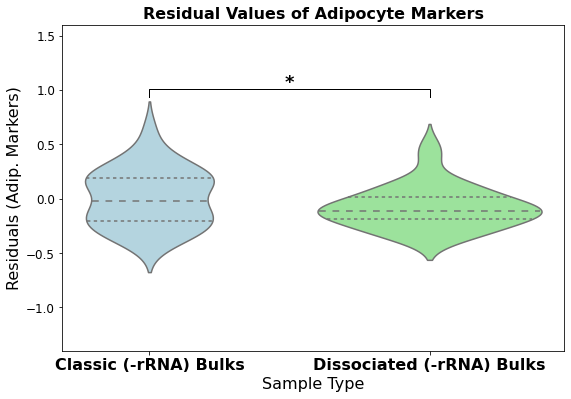

In [397]:
# Sample data for "Classic Bulks" and "Dissociated Bulks"
adip_intersect = np.intersect1d(residuals_bulks.columns, adip_markers)

bulk_type_1 = residuals_bulks[adip_intersect].values.flatten()
bulk_type_2 = residuals_dissbulks[adip_intersect].values.flatten()

# Combine data into a DataFrame
df = pd.DataFrame({'Sample Type': ['Bulktype1'] * len(bulk_type_1) +
                                  ['Bulktype2'] * len(bulk_type_2),
                   'Residuals (Adip. Markers)': np.concatenate([bulk_type_1, bulk_type_2])})

# Create a figure and axis for violin plots
plt.figure(figsize=(9, 6))
ax = plt.gca()

# Create violin plots for the two datasets
sns.violinplot(x='Sample Type', y='Residuals (Adip. Markers)', data=df, ax=ax, inner='quartile', palette=['lightblue','lightgreen'])

# Add labels to the x-axis
ax.set_xticklabels(['Classic (-rRNA) Bulks', 'Dissociated (-rRNA) Bulks'], fontsize=16, fontweight='bold')

# Calculate p-value for the Wilcoxon signed-rank test
# Perform the paired t-test
t_statistic, p_value = stats.wilcoxon(bulk_type_1, bulk_type_2)

# Set a significance level (e.g., 0.05)
alpha = 0.05
#getting maximum value for significance line:
max_val = np.max([max(bulk_type_1), max(bulk_type_2)])

# Determine if the difference is statistically significant
if p_value < alpha:
    significance_label = f"Significant p={np.round(p_value, 3)} (p < 0.05)"
    asterisks = vp.convert_pvalue_to_asterisks(p_value)
    x1, x2 = 0, 1
    y1, y2 = max_val + 0.3, max_val+0.38
    # Add a line and asterisks to indicate statistical significance
    plt.plot([x1, x1, (x1 + x2) / 2, x2, x2], [y1, y2, y2, y2, y1], linewidth=1, color='black')
    plt.text((x1 + x2) / 2, y2-0.03 , asterisks, ha='center', va='bottom', fontsize=18, fontweight='bold', fontname='Arial')
else:
    significance_label = f"Not Significant p={np.round(p_value, 3)}"
    asterisks = vp.convert_pvalue_to_asterisks(p_value)
    x1, x2 = 0, 1
    y1, y2 = max_val + 0.15, max_val+0.22
    # Add a line and asterisks to indicate statistical significance
    plt.plot([x1, x1, x2, x2], [y1, y2, y2, y1], linewidth=1, color='black')
    plt.text((x1 + x2) / 2, y2, s='N.S.', ha='center', va='bottom', fontsize=12, fontname='Arial')
    # No asterisks for non-significant results

plt.xlabel('Sample Type', fontsize=16, fontname='Arial')
plt.ylabel('Residuals (Adip. Markers)', fontsize=16, fontname='Arial')
plt.title('Residual Values of Adipocyte Markers', fontsize=16, fontname='Arial', fontweight='bold')
plt.ylim(-1.4, 1.6)
plt.show()

Dissociated (-rRNA) Bulks and Dissociated (polyA) Bulks

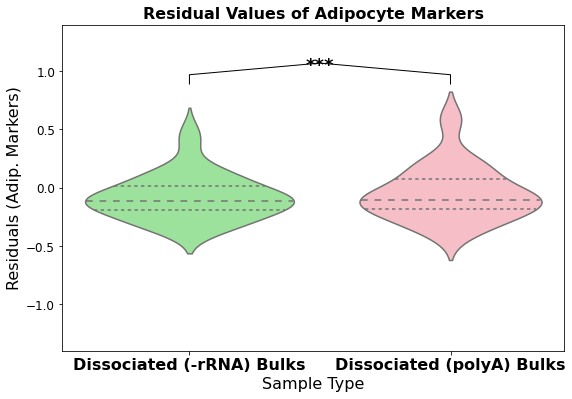

In [398]:
# Sample data for "Classic Bulks" and "Dissociated Bulks"
adip_intersect = np.intersect1d(residuals_bulks.columns, adip_markers)

bulk_type_1 = residuals_dissbulks[adip_intersect].values.flatten()
bulk_type_2 = residuals_disspolyabulks[adip_intersect].values.flatten()

# Combine data into a DataFrame
df = pd.DataFrame({'Sample Type': ['Classic Bulks'] * len(bulk_type_1) +
                                  ['Dissociated Bulks'] * len(bulk_type_2),
                   'Residuals (Adip. Markers)': np.concatenate([bulk_type_1, bulk_type_2])})

# Create a figure and axis for violin plots
plt.figure(figsize=(9, 6))
ax = plt.gca()

# Create violin plots for the two datasets
sns.violinplot(x='Sample Type', y='Residuals (Adip. Markers)', data=df, ax=ax, inner='quartile', palette=['lightgreen', 'lightpink'])

# Add labels to the x-axis
ax.set_xticklabels(['Dissociated (-rRNA) Bulks', 'Dissociated (polyA) Bulks'], fontsize=16, fontweight='bold')

# Calculate p-value for the Wilcoxon signed-rank test
# Perform the paired t-test
t_statistic, p_value = stats.wilcoxon(bulk_type_1, bulk_type_2)

# Set a significance level (e.g., 0.05)
alpha = 0.05
#getting maximum value for significance line:
max_val = np.max([max(bulk_type_1), max(bulk_type_2)])

# Determine if the difference is statistically significant
if p_value < alpha:
    significance_label = f"Significant p={np.round(p_value, 3)} (p < 0.05)"
    asterisks = vp.convert_pvalue_to_asterisks(p_value)
    x1, x2 = 0, 1
    y1, y2 = max_val + 0.3, max_val+0.38# Adjusted higher y-coordinate
    # Add a line and asterisks to indicate statistical significance
    plt.plot([x1, x1, (x1 + x2) / 2, x2, x2], [y1, y2, y2 + 0.1, y2, y1], linewidth=1, color='black')
    plt.text((x1 + x2) / 2, y2 , asterisks, ha='center', va='bottom', fontsize=18, fontweight='bold', fontname='Arial')
else:
    significance_label = f"Not Significant p={np.round(p_value, 3)}"
    asterisks = vp.convert_pvalue_to_asterisks(p_value)
    x1, x2 = 0, 1
    y1, y2 = max_val + 0.3, max_val+0.38
    # Add a line and asterisks to indicate statistical significance
    plt.plot([x1, x1, x2, x2], [y1, y2, y2, y1], linewidth=1, color='black')
    plt.text((x1 + x2) / 2, y2, s='N.S.', ha='center', va='bottom', fontsize=12, fontname='Arial')
    # No asterisks for non-significant results

plt.xlabel('Sample Type', fontsize=16, fontname='Arial')
plt.ylabel('Residuals (Adip. Markers)', fontsize=16, fontname='Arial')
plt.title('Residual Values of Adipocyte Markers', fontsize=16, fontname='Arial', fontweight='bold')
plt.ylim(-1.4, 1.4)
plt.show()


Classic (-rRNA) Bulks and Dissociated (polyA) Bulks

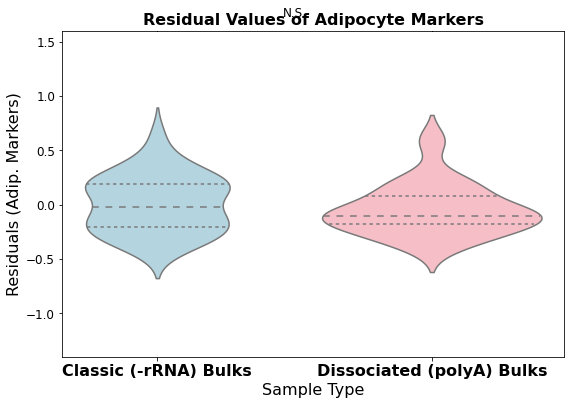

In [399]:
# Sample data for "Classic Bulks" and "Dissociated Bulks"
adip_intersect = np.intersect1d(residuals_bulks.columns, adip_markers)

classic_bulks_values = residuals_bulks[adip_intersect].values.flatten()
dissociated_bulks_values = residuals_disspolyabulks[adip_intersect].values.flatten()

# Combine data into a DataFrame
df = pd.DataFrame({'Sample Type': ['Bulktype1'] * len(classic_bulks_values) +
                                  ['Bulktype2'] * len(dissociated_bulks_values),
                   'Residuals (Adip. Markers)': np.concatenate([classic_bulks_values, dissociated_bulks_values])})

# Create a figure and axis for violin plots
plt.figure(figsize=(9, 6))
ax = plt.gca()

# Create violin plots for the two datasets
sns.violinplot(x='Sample Type', y='Residuals (Adip. Markers)', data=df, ax=ax, inner='quartile', palette=['lightblue', 'lightpink'])

# Add labels to the x-axis
ax.set_xticklabels(['Classic (-rRNA) Bulks', 'Dissociated (polyA) Bulks'], fontsize=16, fontweight='bold')

# Calculate p-value for the Wilcoxon signed-rank test
# Perform the paired t-test
t_statistic, p_value = stats.wilcoxon(classic_bulks_values, dissociated_bulks_values)

# Set a significance level (e.g., 0.05)
alpha = 0.05

#getting maximum value for significance line:
max_val = np.max([max(bulk_type_1), max(bulk_type_2)])
# Determine if the difference is statistically significant
if p_value < alpha:
    significance_label = f"Significant p={np.round(p_value, 3)} (p < 0.05)"
    asterisks = vp.convert_pvalue_to_asterisks(p_value)
    x1, x2 = 0, 1
    y1, y2 = 1.3, 1.4 # Adjusted higher y-coordinate
    # Add a line and asterisks to indicate statistical significance
    plt.plot([x1, x1, (x1 + x2) / 2, x2, x2], [y1, y2, y2, y2, y1], linewidth=1, color='black')
    plt.text((x1 + x2) / 2, y2-0.03 , asterisks, ha='center', va='bottom', fontsize=18, fontweight='bold', fontname='Arial')
else:
    significance_label = f"Not Significant p={np.round(p_value, 3)}"
    asterisks = vp.convert_pvalue_to_asterisks(p_value)
    x1, x2 = 0, 1
    y1, y2 = 1.6, 1.7
    # Add a line and asterisks to indicate statistical significance
    plt.plot([x1, x1, x2, x2], [y1, y2, y2, y1], linewidth=1, color='black')
    plt.text((x1 + x2) / 2, y2, s='N.S.', ha='center', va='bottom', fontsize=12, fontname='Arial')
    # No asterisks for non-significant results

plt.xlabel('Sample Type', fontsize=16, fontname='Arial')
plt.ylabel('Residuals (Adip. Markers)', fontsize=16, fontname='Arial')
plt.title('Residual Values of Adipocyte Markers', fontsize=16, fontname='Arial', fontweight='bold')
plt.ylim(-1.4, 1.6)
plt.show()

**Distributions: Only Dissociation Markers**

Classic (-rRNA) Bulks and Dissociated (-rRNA) Bulks

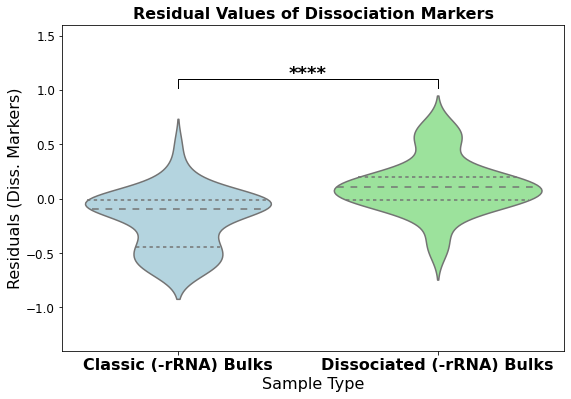

In [400]:
# Sample data for "Classic Bulks" and "Dissociated Bulks"
adip_intersect = np.intersect1d(residuals_bulks.columns, diss_response)

bulk_type_1 = residuals_bulks[adip_intersect].values.flatten()
bulk_type_2 = residuals_dissbulks[adip_intersect].values.flatten()

# Combine data into a DataFrame
df = pd.DataFrame({'Sample Type': ['Bulktype1'] * len(bulk_type_1) +
                                  ['Bulktype2'] * len(bulk_type_2),
                   'Residuals (Diss. Markers)': np.concatenate([bulk_type_1, bulk_type_2])})

# Create a figure and axis for violin plots
plt.figure(figsize=(9, 6))
ax = plt.gca()

# Create violin plots for the two datasets
sns.violinplot(x='Sample Type', y='Residuals (Diss. Markers)', data=df, ax=ax, inner='quartile', palette=['lightblue', 'lightgreen'])

# Add labels to the x-axis
ax.set_xticklabels(['Classic (-rRNA) Bulks', 'Dissociated (-rRNA) Bulks'], fontsize=16, fontname='Arial', fontweight='bold')

# Calculate p-value for the Wilcoxon signed-rank test
# Perform the paired t-test
t_statistic, p_value = stats.wilcoxon(bulk_type_1, bulk_type_2)

# Set a significance level (e.g., 0.05)
alpha = 0.05
#getting maximum value for significance line:
max_val = np.max([max(bulk_type_1), max(bulk_type_2)])
# Determine if the difference is statistically significant
if p_value < alpha:
    significance_label = f"Significant p={np.round(p_value, 3)} (p < 0.05)"
    asterisks = vp.convert_pvalue_to_asterisks(p_value)
    x1, x2 = 0, 1
    y1, y2 = max_val + 0.3, max_val+0.38
    # Add a line and asterisks to indicate statistical significance
    plt.plot([x1, x1, x2, x2], [y1, y2, y2, y1], linewidth=1, color='black')
    plt.text((x1 + x2) / 2, y2-0.03, asterisks, ha='center', va='bottom', fontsize=18, fontweight='bold', fontname='Arial')
else:
    significance_label = f"Not Significant p={np.round(p_value, 3)}"
    asterisks = vp.convert_pvalue_to_asterisks(p_value)
    x1, x2 = 0, 1
    y1, y2 = 1.6, 1.7
    # Add a line and asterisks to indicate statistical significance
    plt.plot([x1, x1, x2, x2], [y1, y2, y2, y1], linewidth=1, color='black')
    plt.text((x1 + x2) / 2, y2, s='N.S.', ha='center', va='bottom', fontsize=12, fontname='Arial')
    # No asterisks for non-significant results
    
plt.xlabel('Sample Type', fontsize=16, fontname='Arial')
plt.ylabel('Residuals (Diss. Markers)', fontsize=16, fontname='Arial')
plt.title('Residual Values of Dissociation Markers', fontsize=16, fontname='Arial', fontweight='bold')
plt.ylim(-1.4, 1.6)
plt.show()


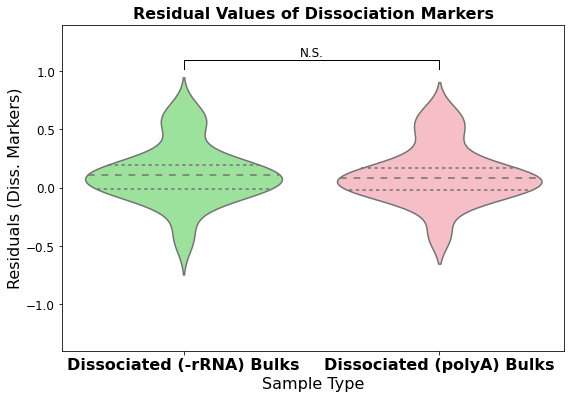

In [401]:
# Sample data for "Classic Bulks" and "Dissociated Bulks"
diss_intersect = np.intersect1d(residuals_bulks.columns, diss_response)

bulk_type_1 = residuals_dissbulks[diss_intersect].values.flatten()
bulk_type_2 = residuals_disspolyabulks[diss_intersect].values.flatten()

# Combine data into a DataFrame
df = pd.DataFrame({'Sample Type': ['Classic Bulks'] * len(bulk_type_1) +
                                  ['Dissociated Bulks'] * len(bulk_type_2),
                   'Residuals (diss. Markers)': np.concatenate([bulk_type_1, bulk_type_2])})

# Create a figure and axis for violin plots
plt.figure(figsize=(9, 6))
ax = plt.gca()

# Create violin plots for the two datasets
sns.violinplot(x='Sample Type', y='Residuals (diss. Markers)', data=df, ax=ax, inner='quartile', palette=['lightgreen', 'lightpink'])

# Add labels to the x-axis
ax.set_xticklabels(['Dissociated (-rRNA) Bulks', 'Dissociated (polyA) Bulks'], fontsize=16, fontweight='bold')

# Calculate p-value for the Wilcoxon signed-rank test
# Perform the paired t-test
t_statistic, p_value = stats.wilcoxon(bulk_type_1, bulk_type_2)

# Set a significance level (e.g., 0.05)
alpha = 0.05
#getting maximum value for significance line:
max_val = np.max([max(bulk_type_1), max(bulk_type_2)])
# Determine if the difference is statistically significant
if p_value < alpha:
    significance_label = f"Significant p={np.round(p_value, 3)} (p < 0.05)"
    asterisks = vp.convert_pvalue_to_asterisks(p_value)
    x1, x2 = 0, 1
    y1, y2 = max_val + 0.3, max_val+0.38
    # Add a line and asterisks to indicate statistical significance
    plt.plot([x1, x1, (x1 + x2) / 2, x2, x2], [y1, y2, y2 + 0.1, y2, y1], linewidth=1, color='black')
    plt.text((x1 + x2) / 2, y2 , asterisks, ha='center', va='bottom', fontsize=18, fontweight='bold', fontname='Arial')
else:
    significance_label = f"Not Significant p={np.round(p_value, 3)}"
    asterisks = vp.convert_pvalue_to_asterisks(p_value)
    x1, x2 = 0, 1
    y1, y2 = max_val + 0.3, max_val+0.38
    # Add a line and asterisks to indicate statistical significance
    plt.plot([x1, x1, x2, x2], [y1, y2, y2, y1], linewidth=1, color='black')
    plt.text((x1 + x2) / 2, y2, s='N.S.', ha='center', va='bottom', fontsize=12, fontname='Arial')
    # No asterisks for non-significant results

plt.xlabel('Sample Type', fontsize=16, fontname='Arial')
plt.ylabel('Residuals (Diss. Markers)', fontsize=16, fontname='Arial')
plt.title('Residual Values of Dissociation Markers', fontsize=16, fontname='Arial', fontweight='bold')
plt.ylim(-1.4, 1.4)
plt.show()

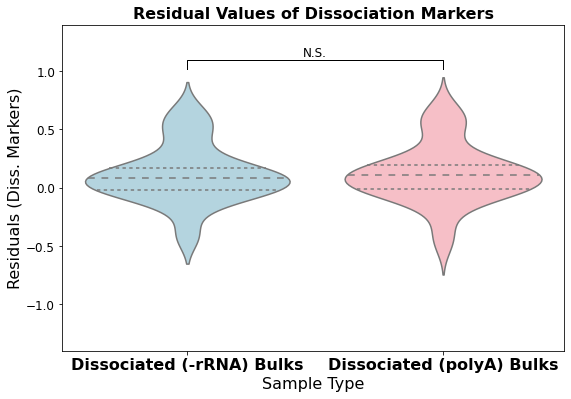

In [402]:
# Sample data for "Classic Bulks" and "Dissociated Bulks"
diss_intersect = np.intersect1d(residuals_bulks.columns, diss_response)

bulk_type_1 = residuals_disspolyabulks[diss_intersect].values.flatten()
bulk_type_2 = residuals_dissbulks[diss_intersect].values.flatten()

# Combine data into a DataFrame
df = pd.DataFrame({'Sample Type': ['Classic Bulks'] * len(bulk_type_1) +
                                  ['Dissociated Bulks'] * len(bulk_type_2),
                   'Residuals (diss. Markers)': np.concatenate([bulk_type_1, bulk_type_2])})

# Create a figure and axis for violin plots
plt.figure(figsize=(9, 6))
ax = plt.gca()

# Create violin plots for the two datasets
sns.violinplot(x='Sample Type', y='Residuals (diss. Markers)', data=df, ax=ax, inner='quartile', palette=['lightblue', 'lightpink'])

# Add labels to the x-axis
ax.set_xticklabels(['Dissociated (-rRNA) Bulks', 'Dissociated (polyA) Bulks'], fontsize=16, fontweight='bold')

# Calculate p-value for the Wilcoxon signed-rank test
# Perform the paired t-test
t_statistic, p_value = stats.wilcoxon(bulk_type_1, bulk_type_2)

# Set a significance level (e.g., 0.05)
alpha = 0.05
#getting maximum value for significance line:
max_val = np.max([max(bulk_type_1), max(bulk_type_2)])
# Determine if the difference is statistically significant
if p_value < alpha:
    significance_label = f"Significant p={np.round(p_value, 3)} (p < 0.05)"
    asterisks = vp.convert_pvalue_to_asterisks(p_value)
    x1, x2 = 0, 1
    y1, y2 = max_val + 0.3, max_val+0.38
    # Add a line and asterisks to indicate statistical significance
    plt.plot([x1, x1, (x1 + x2) / 2, x2, x2], [y1, y2, y2 + 0.1, y2, y1], linewidth=1, color='black')
    plt.text((x1 + x2) / 2, y2 , asterisks, ha='center', va='bottom', fontsize=18, fontweight='bold', fontname='Arial')
else:
    significance_label = f"Not Significant p={np.round(p_value, 3)}"
    asterisks = vp.convert_pvalue_to_asterisks(p_value)
    x1, x2 = 0, 1
    y1, y2 = max_val + 0.3, max_val+0.38
    # Add a line and asterisks to indicate statistical significance
    plt.plot([x1, x1, x2, x2], [y1, y2, y2, y1], linewidth=1, color='black')
    plt.text((x1 + x2) / 2, y2, s='N.S.', ha='center', va='bottom', fontsize=12, fontname='Arial')
    # No asterisks for non-significant results

plt.xlabel('Sample Type', fontsize=16, fontname='Arial')
plt.ylabel('Residuals (Diss. Markers)', fontsize=16, fontname='Arial')
plt.title('Residual Values of Dissociation Markers', fontsize=16, fontname='Arial', fontweight='bold')
plt.ylim(-1.4, 1.4)
plt.show()

## PCA

Combo (Classic and Dissociated (-rRNA together))

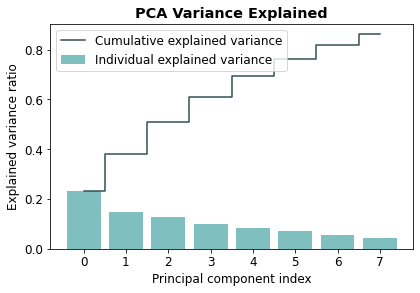

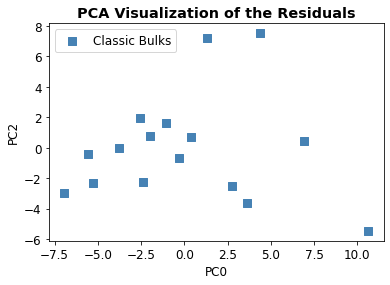

,Component_0,Component_1,Component_2,Component_3,Component_4,Component_5,Component_6,Component_7
0,VTCN1,FAM107A,SDC1,PLK2,KIF26B,LAMA3,CLDN1,EYA2
1,PELI2,IRS2,PLEKHG5,RELT,INHBA,NAV2,MYH11,RNF152
2,SPINT2,TFCP2L1,MEG8,AC245014.3,PDLIM3,AC136475.3,KCNMA1,CDH6
3,HID1,B3GNT5,KCNMA1,IFRD1,UNC5B,RASSF8,MERTK,IFI44L
4,XAF1,MFSD2A,CADM1,LINC00511,BHLHE41,NRXN3,IGLC3,ESR1
...,...,...,...,...,...,...,...,...
4579,MGP,SLFN11,SULF1,FAM168B,MEST,NET1,STON2,EPHB6
4580,RND3,BTN3A1,USP53,PIK3R3,FAM107A,PGRMC1,STMN1,FBXO32
4581,PLAT,BIRC3,CHI3L1,DNAJC5,FAM110C,CREBZF,DSG2,CGN
4582,CLDN1,LY75,IGHG1,CHST15,CCL2,PTGDS,CD36,ASS1


In [403]:
# Set font to Arial
font = {'family': 'Arial', 'weight': 'normal', 'size': 12}
plt.rc('font', **font)
num_pca_components_combo = 8
pca_res = dict()
df = residuals_combo  # transposing to get length of genes instead of samples
pca_fit = PCA(n_components=num_pca_components_combo)
pca_results = pca_fit.fit_transform(df.values)

exp_var_pca = pca_fit.explained_variance_ratio_
cum_sum_eigenvalues = np.cumsum(exp_var_pca)

# Plot variance explained
plt.bar(range(0, len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', color='teal', label='Individual explained variance')
plt.step(range(0, len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid', color='darkslategrey', label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.title("PCA Variance Explained", fontweight='bold')
plt.show()

# PCA Visualization
plt.scatter(pca_results[:, 0], pca_results[:, 2], label="Classic Bulks", c='steelblue', marker='s', s=marker_size)
plt.legend()
plt.title("PCA Visualization of the Residuals", fontweight='bold')
plt.xlabel("PC0")
plt.ylabel("PC2")
plt.show()

# 'residuals_all.columns' contains the names of the genes
comp_genes= []
pca_genes = pd.DataFrame()
# Iterate through each component
for component_idx in range(num_pca_components_combo):
    # Calculate loadings for the current component
    loadings = pca_fit.components_.T * np.sqrt(pca_fit.explained_variance_)

    # Sort genes by their influence on the current component
    sorted_genes = residuals_bulks.columns[np.argsort(loadings[:, component_idx])]

    # Visualize the top N genes that contribute the most to the current component
    N = pca_fit.components_.shape[1]
    top_genes = sorted_genes[-N:]

    pca_genes[component_idx] = top_genes[::-1]
    comp_genes = np.append(comp_genes, top_genes)
pca_genes.columns = ["Component_0","Component_1","Component_2", "Component_3",
                     "Component_4",  "Component_5", "Component_6", "Component_7"]                      
pca_genes   


In [404]:
#and exporting PCA genes per component for gene ontology analysis.

''' NOTE: You'll need to run GOrilla on these lists for the next part!'''

pca_name_path = Path(f"{os.getcwd()}/../results/EXP5/", "PCA_genes_residuals_combo_ADIP.xlsx")
pca_genes.to_excel(pca_name_path, sheet_name = "PCA_Components_Genes")

In [405]:
# Separate the first and last 8 samples (by sample type)
first_half_samples = pca_results[:8]
second_half_samples = pca_results[-8:]

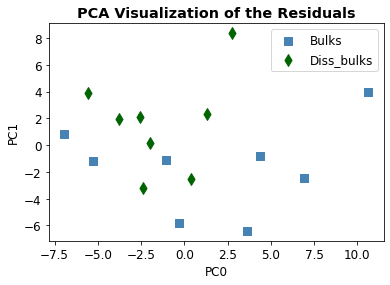

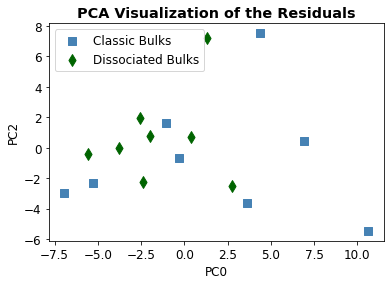

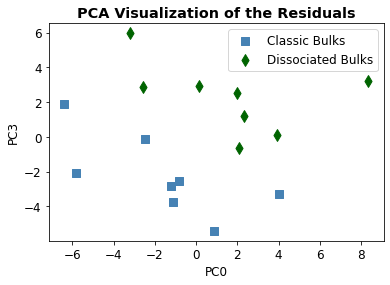

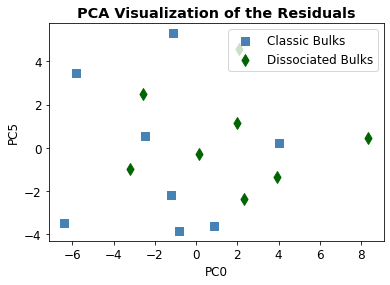

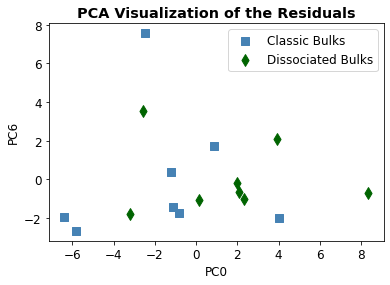

In [406]:
marker_size = 70

# Set font to Arial
font = {'family': 'Arial', 'weight': 'normal', 'size': 12}
plt.rc('font', **font)

# PCA Visualization of the Residuals
plt.scatter(first_half_samples[:, 0], first_half_samples[:, 1], label="Bulks", c='steelblue', marker='s', s=marker_size)
plt.scatter(second_half_samples[:, 0], second_half_samples[:, 1], label="Diss_bulks", c='darkgreen', marker='d', s=marker_size)
plt.legend()
plt.title("PCA Visualization of the Residuals", fontweight='bold')
plt.xlabel("PC0")
plt.ylabel("PC1")
plt.show()

# PCA Visualization
plt.scatter(first_half_samples[:, 0], first_half_samples[:, 2], label="Classic Bulks", c='steelblue', marker='s', s=marker_size)
plt.scatter(second_half_samples[:, 0], second_half_samples[:, 2], label="Dissociated Bulks", c='darkgreen', marker='d', s=marker_size)
plt.legend()
plt.title("PCA Visualization of the Residuals", fontweight='bold')
plt.xlabel("PC0")
plt.ylabel("PC2")
plt.show()

# PCA Visualization
plt.scatter(first_half_samples[:, 1], first_half_samples[:, 3], label="Classic Bulks", c='steelblue', marker='s', s=marker_size)
plt.scatter(second_half_samples[:, 1], second_half_samples[:, 3], label="Dissociated Bulks", c='darkgreen', marker='d', s=marker_size)
plt.legend()
plt.title("PCA Visualization of the Residuals", fontweight='bold')
plt.xlabel("PC0")
plt.ylabel("PC3")
plt.show()

# PCA Visualization
plt.scatter(first_half_samples[:, 1], first_half_samples[:, 4], label="Classic Bulks", c='steelblue', marker='s', s=marker_size)
plt.scatter(second_half_samples[:, 1], second_half_samples[:, 4], label="Dissociated Bulks", c='darkgreen', marker='d', s=marker_size)
plt.legend()
plt.title("PCA Visualization of the Residuals", fontweight='bold')
plt.xlabel("PC0")
plt.ylabel("PC5")
plt.show()

# PCA Visualization
plt.scatter(first_half_samples[:, 1], first_half_samples[:, 5], label="Classic Bulks", c='steelblue', marker='s', s=marker_size)
plt.scatter(second_half_samples[:, 1], second_half_samples[:, 5], label="Dissociated Bulks", c='darkgreen', marker='d', s=marker_size)
plt.legend()
plt.title("PCA Visualization of the Residuals", fontweight='bold')
plt.xlabel("PC0")
plt.ylabel("PC6")
plt.show()



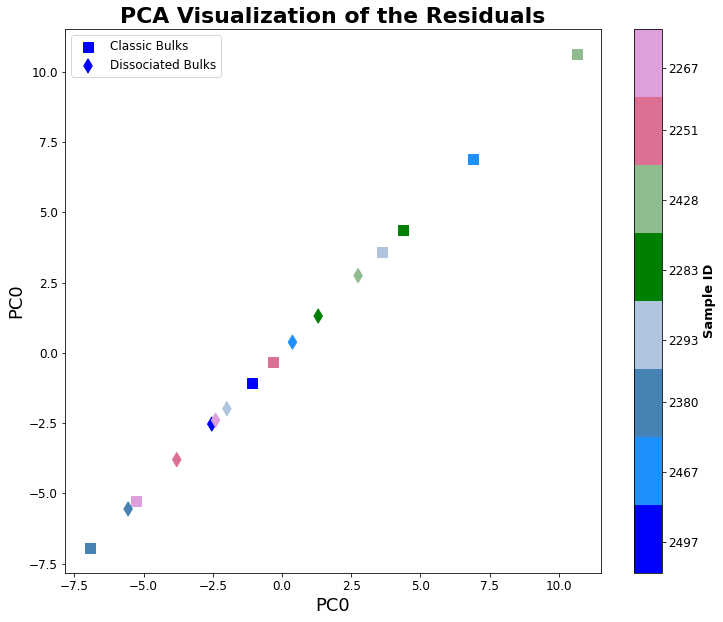

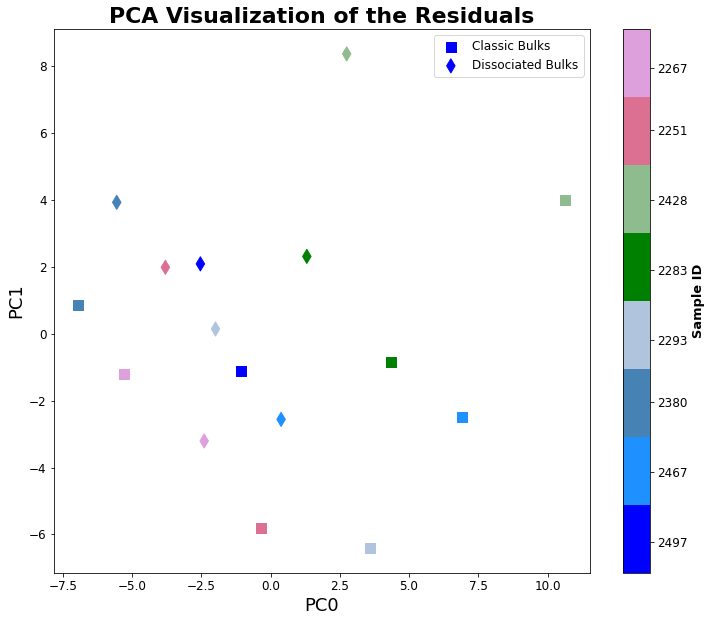

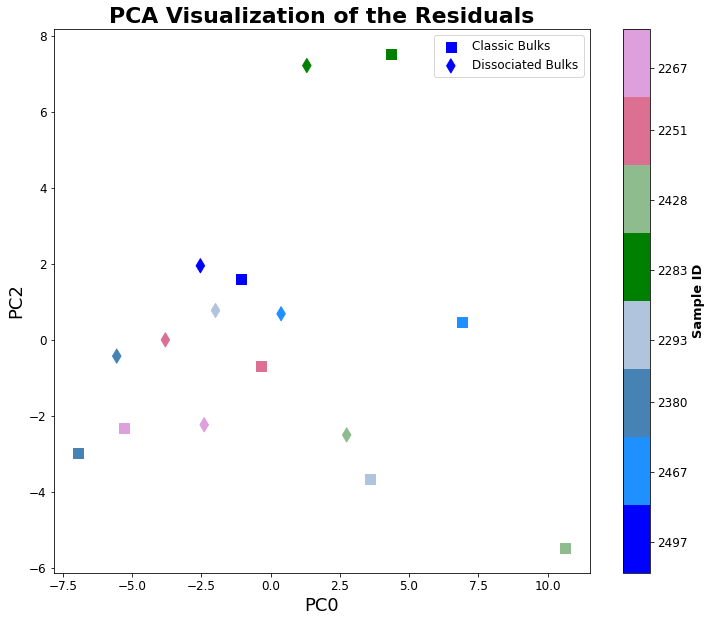

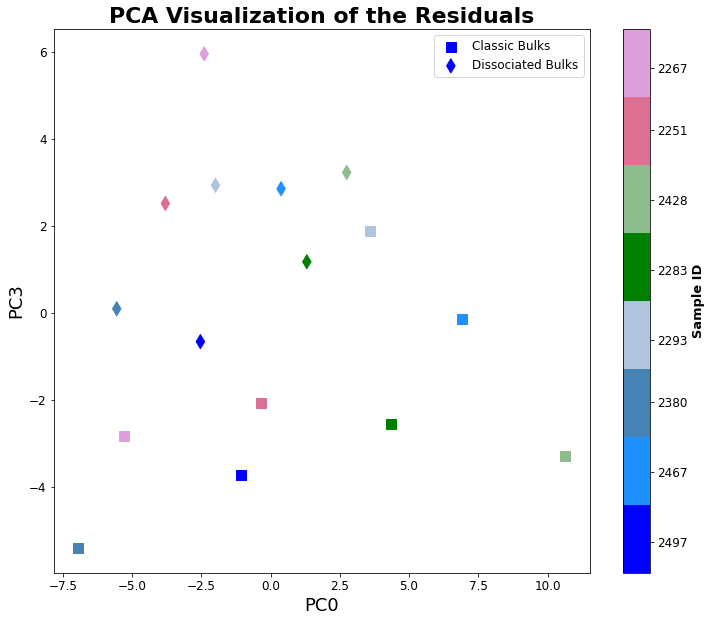

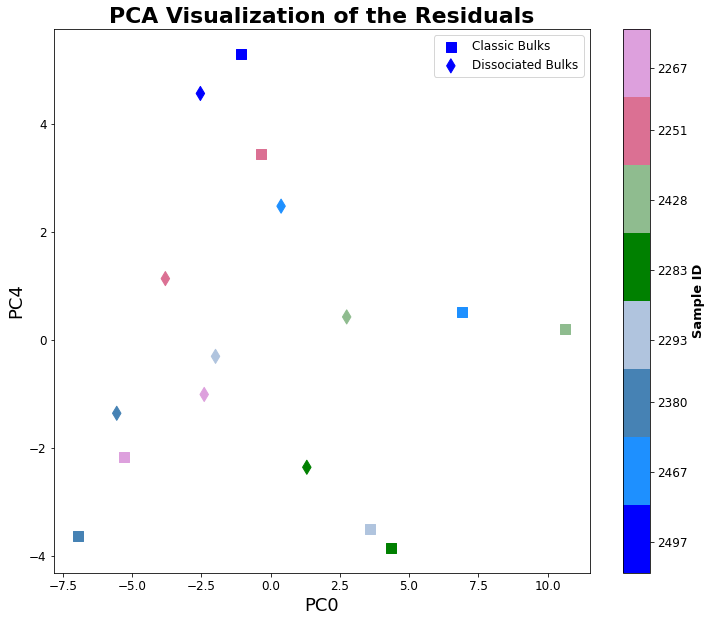

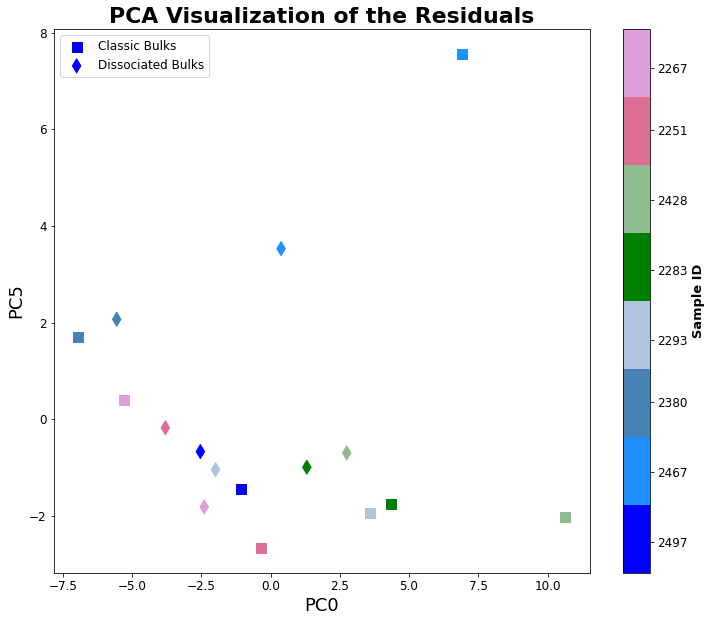

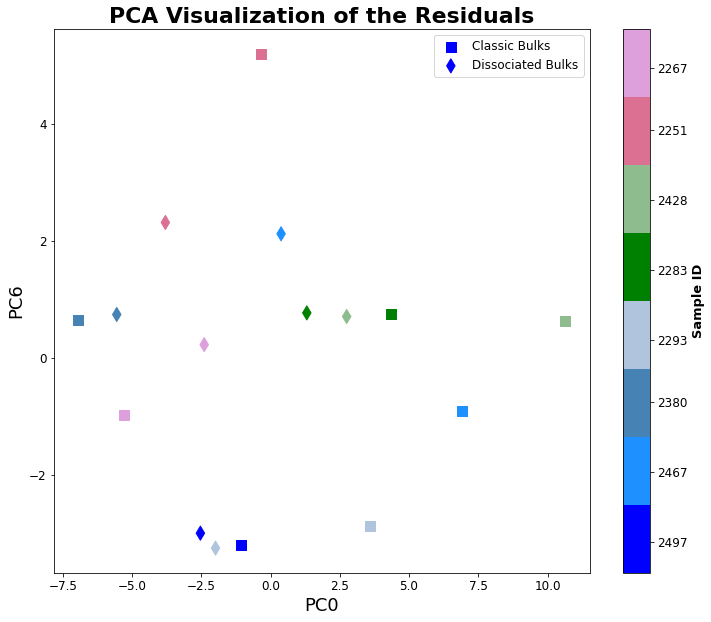

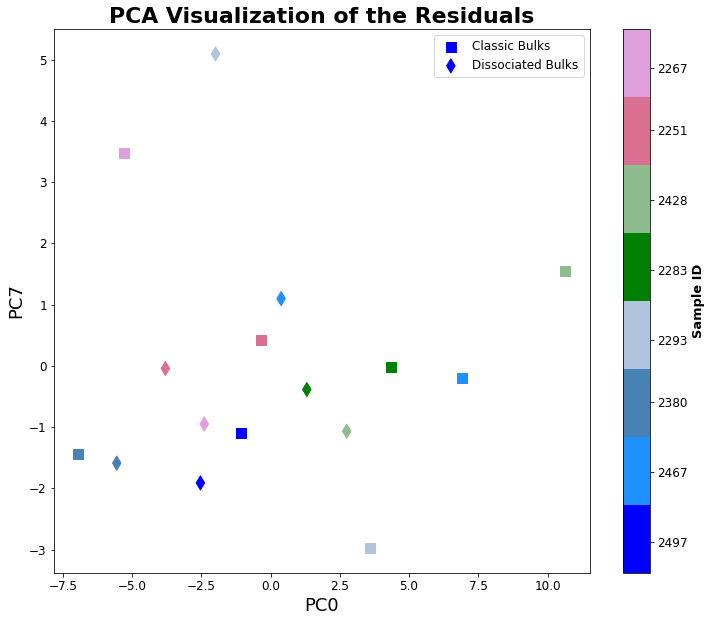

In [407]:
for idx in [0,1,2,3,4,5,6,7]:
    # Assuming `row_indices` contains the row indices of your samples
    row_indices = np.tile(range(1, 9), 2)
    plt.figure(figsize = (12,10))
    # Define custom colors
    custom_colors = ['blue','dodgerblue','steelblue','lightsteelblue','green','darkseagreen','palevioletred','plum']

    # Create a custom colormap
    cmap_custom = mcolors.ListedColormap(custom_colors)
    marker_size = 100

    # PCA Visualization
    scatter1 = plt.scatter(first_half_samples[:, 0], first_half_samples[:, idx], label="Classic Bulks", c=row_indices[:len(first_half_samples)], 
                                cmap=cmap_custom, marker='s', s=marker_size)
    scatter2 = plt.scatter(second_half_samples[:, 0], second_half_samples[:, idx], label="Dissociated Bulks", c=row_indices[len(first_half_samples):], 
                                cmap=cmap_custom, marker='d', s=marker_size)

    # Add colorbar for reference
    cbar = plt.colorbar()
    cbar.set_label('Sample ID', fontsize=13, fontweight='bold')

    # Adjust colorbar ticks to be centered between colors
    cbar.set_ticks([1.4, 2.3 ,3.2 ,4, 4.9 , 5.8 ,6.7 ,7.5])
    cbar.set_ticklabels(sample_ids)

    # Change the color of the little marker in the legend
    # Change the color of the marker in the legend using a custom handler
    legend = plt.legend()

    plt.title("PCA Visualization of the Residuals", fontweight='bold', fontsize=22, fontname='Arial')
    plt.xlabel("PC0", fontsize=18, fontname='Arial')
    plt.ylabel(f"PC{idx}", fontsize=18, fontname='Arial')
    plt.show()

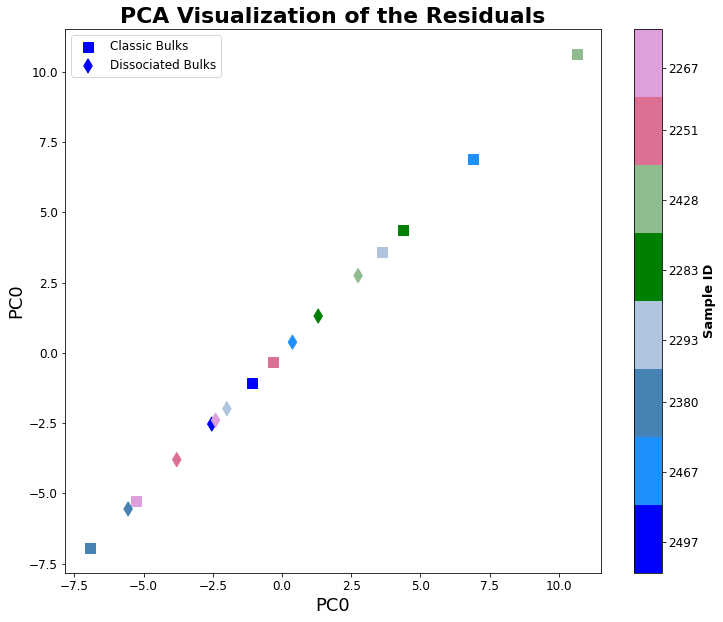

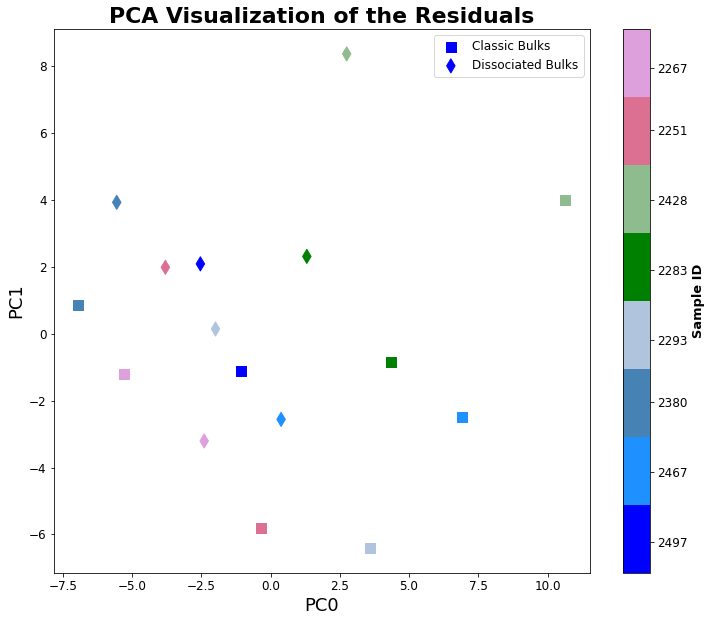

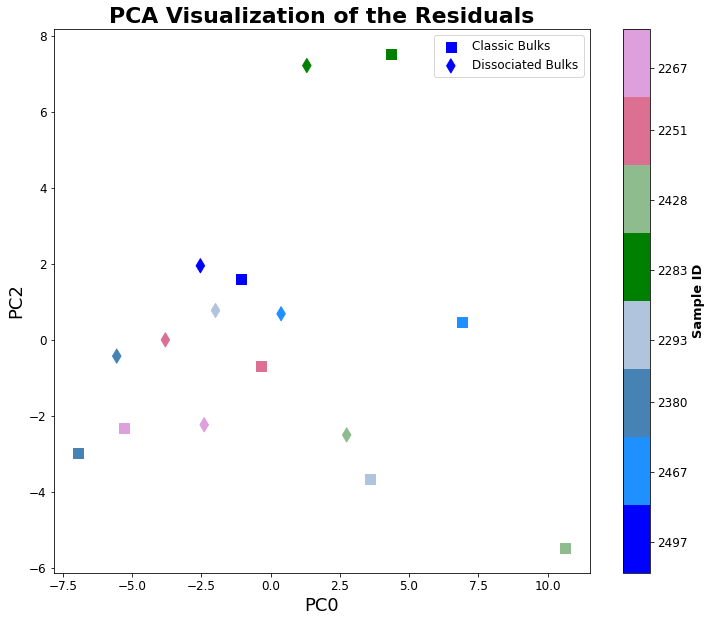

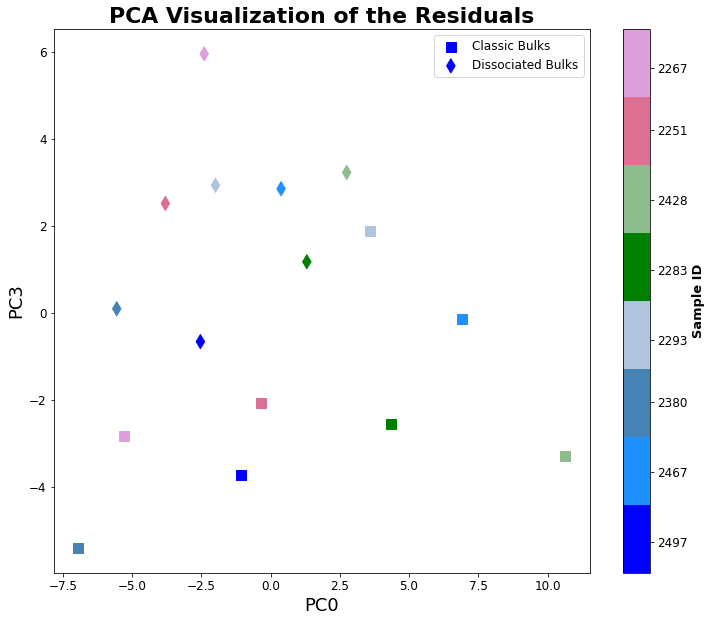

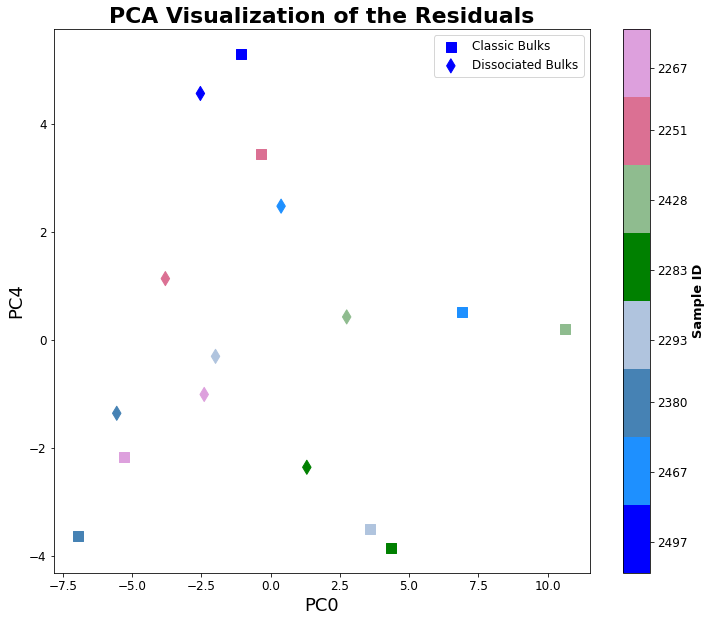

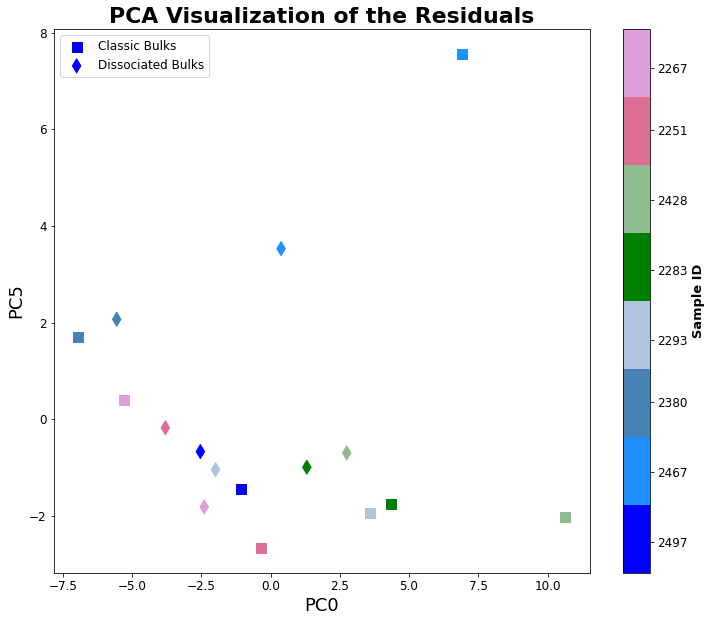

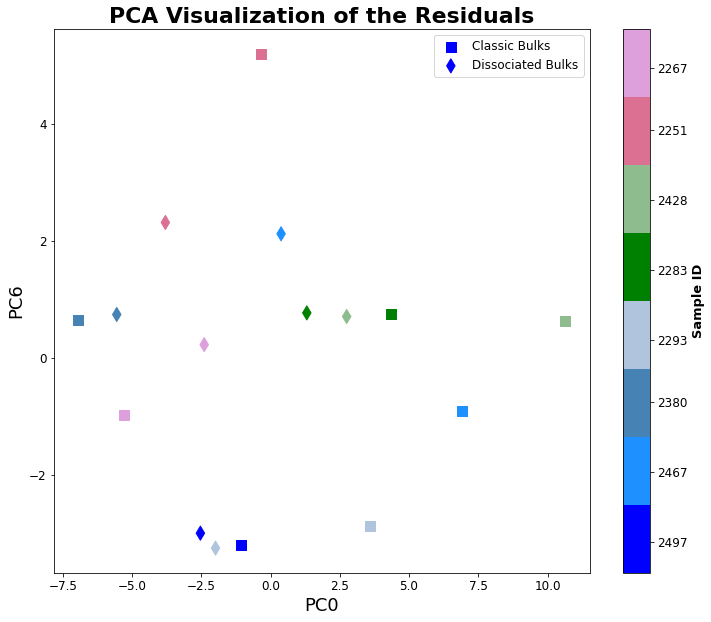

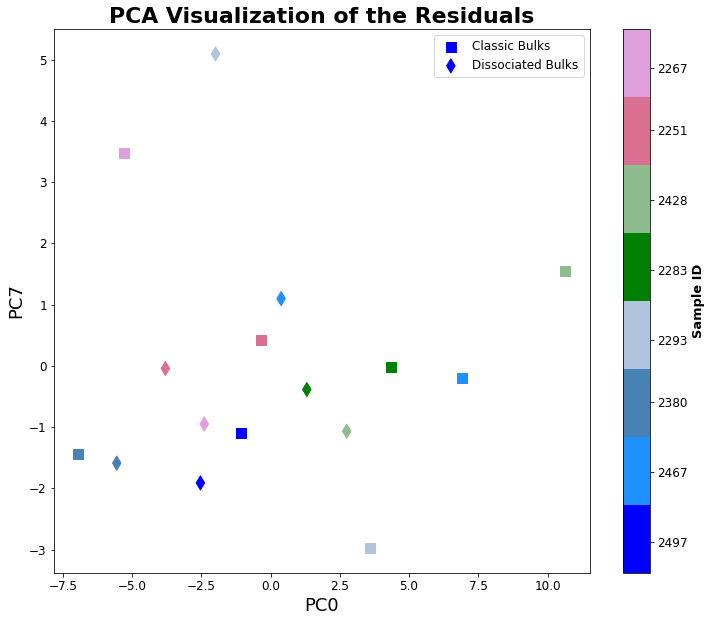

In [408]:
for idx in [0,1,2,3,4,5,6,7]:

    row_indices = np.tile(range(1, 9), 2)
    plt.figure(figsize = (12,10))

    # Create a custom colormap
    cmap_custom = mcolors.ListedColormap(custom_colors)
    marker_size = 100

    # PCA Visualization
    scatter1 = plt.scatter(first_half_samples[:, 0], first_half_samples[:, idx], label="Classic Bulks", c=row_indices[:len(first_half_samples)], 
                                cmap=cmap_custom, marker='s', s=marker_size)
    scatter2 = plt.scatter(second_half_samples[:, 0], second_half_samples[:, idx], label="Dissociated Bulks", c=row_indices[len(first_half_samples):], 
                                cmap=cmap_custom, marker='d', s=marker_size)

    # Add colorbar for reference
    cbar = plt.colorbar()
    cbar.set_label('Sample ID', fontsize=13, fontweight='bold')

    # Adjust colorbar ticks to be centered between colors
    cbar.set_ticks([1.4, 2.3 ,3.2 ,4, 4.9 , 5.8 ,6.7 ,7.5])
    cbar.set_ticklabels(sample_ids)

    legend = plt.legend()

    plt.title("PCA Visualization of the Residuals", fontweight='bold', fontsize=22, fontname='Arial')
    plt.xlabel("PC0", fontsize=18, fontname='Arial')
    plt.ylabel(f"PC{idx}", fontsize=18, fontname='Arial')
    plt.show()

In [409]:
# Separate the data into "classic bulks" and "dissociated bulks"
df = pd.DataFrame(pca_results)
classic_bulks = df.iloc[:8, :]
dissociated_bulks = df.iloc[8:, :]

# Perform t-test for each component
results = pd.DataFrame(columns=['Component', 'T-Statistic', 'P-Value'])

for column in df.columns:
    t_statistic, p_value = stats.ttest_ind(classic_bulks[column], dissociated_bulks[column])
    results = results.append({'Component': column, 'T-Statistic': t_statistic, 'P-Value': p_value}, ignore_index=True)

# Print the results
print(results)

# Identify components with significantly different means
significantly_different = results[results['P-Value'] < 0.05]
print("Components with significantly different means:")
print(significantly_different)

   Component  T-Statistic   P-Value
0        0.0     1.267823  0.225542
1        1.0    -1.843089  0.086588
2        2.0    -0.769196  0.454559
3        3.0    -4.203285  0.000885
4        4.0    -0.623612  0.542910
5        5.0    -0.034477  0.972984
6        6.0    -0.141485  0.889502
7        7.0    -0.060269  0.952793
Components with significantly different means:
   Component  T-Statistic   P-Value
3        3.0    -4.203285  0.000885


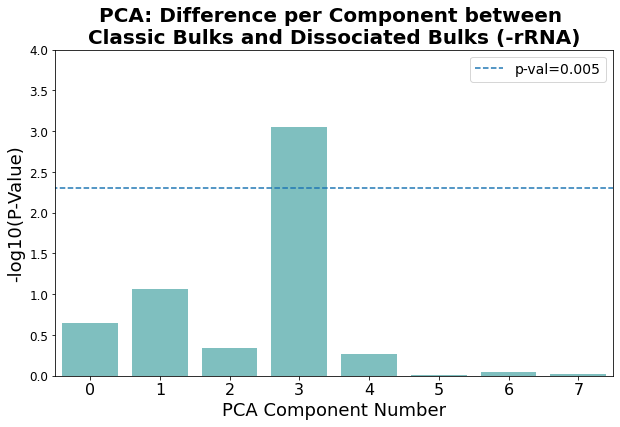

In [410]:
# Bar plot for each component
plt.figure(figsize=(10, 6))
plt.bar(results['Component'], -np.log10(results['P-Value']), color='teal', alpha=0.5)

plt.xlabel('PCA Component Number', fontsize=18, fontname='Arial')
plt.ylabel('-log10(P-Value)', fontsize=18, fontname='Arial')
plt.plot([-1,0,1,2,3,4,5,6,7,8],np.repeat(-np.log10(0.005),10),linestyle='--', label='p-val=0.005')
plt.title('PCA: Difference per Component between \nClassic Bulks and Dissociated Bulks (-rRNA)', 
            fontsize=20, fontname='Arial', fontweight='bold')
plt.xticks([0,1,2,3,4,5,6,7], fontsize=16)
plt.ylim(0,4)
plt.legend(fontsize=14)
plt.xlim(-0.5,7.5)
plt.show()

And evaluating the GOrilla results (of combo residual):

filtered: (27, 11)


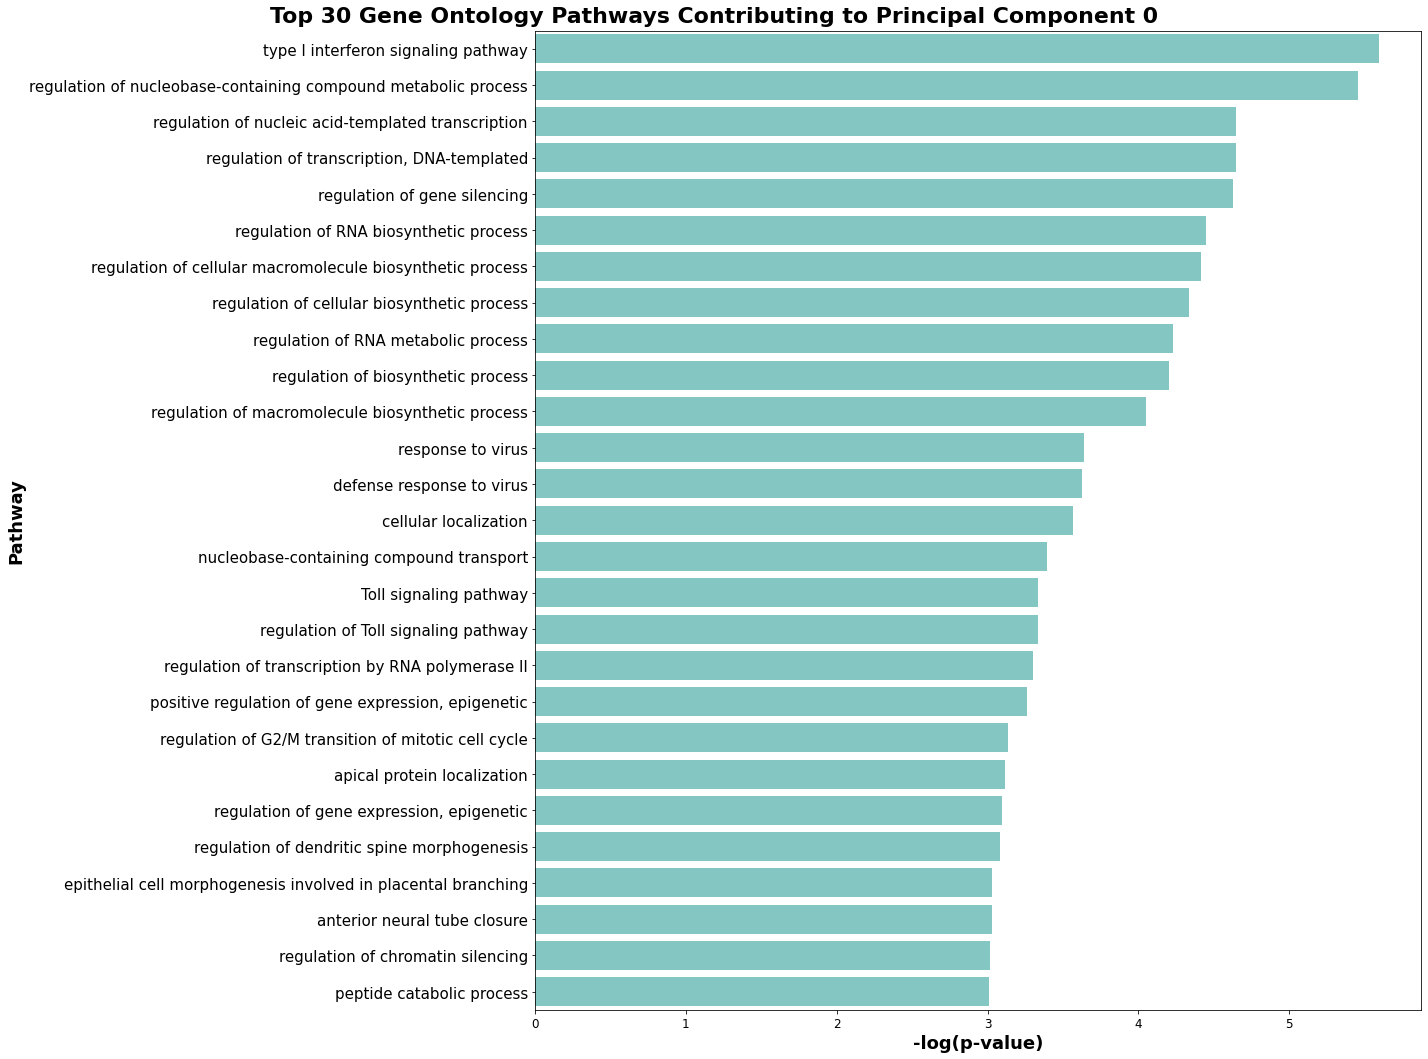

filtered: (30, 11)


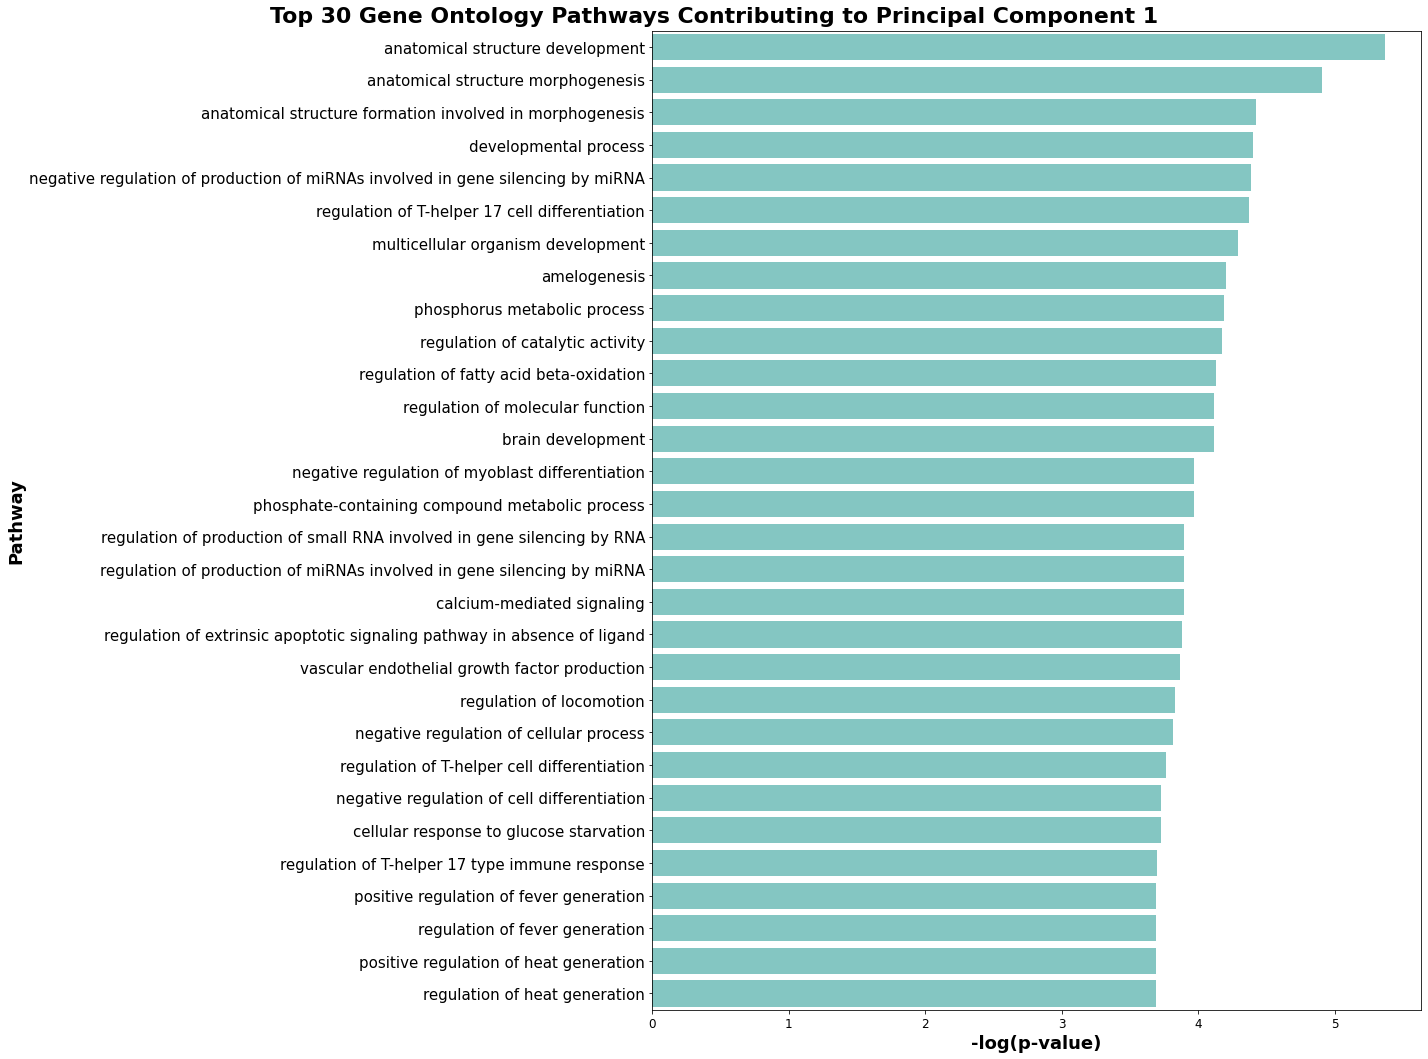

filtered: (30, 11)


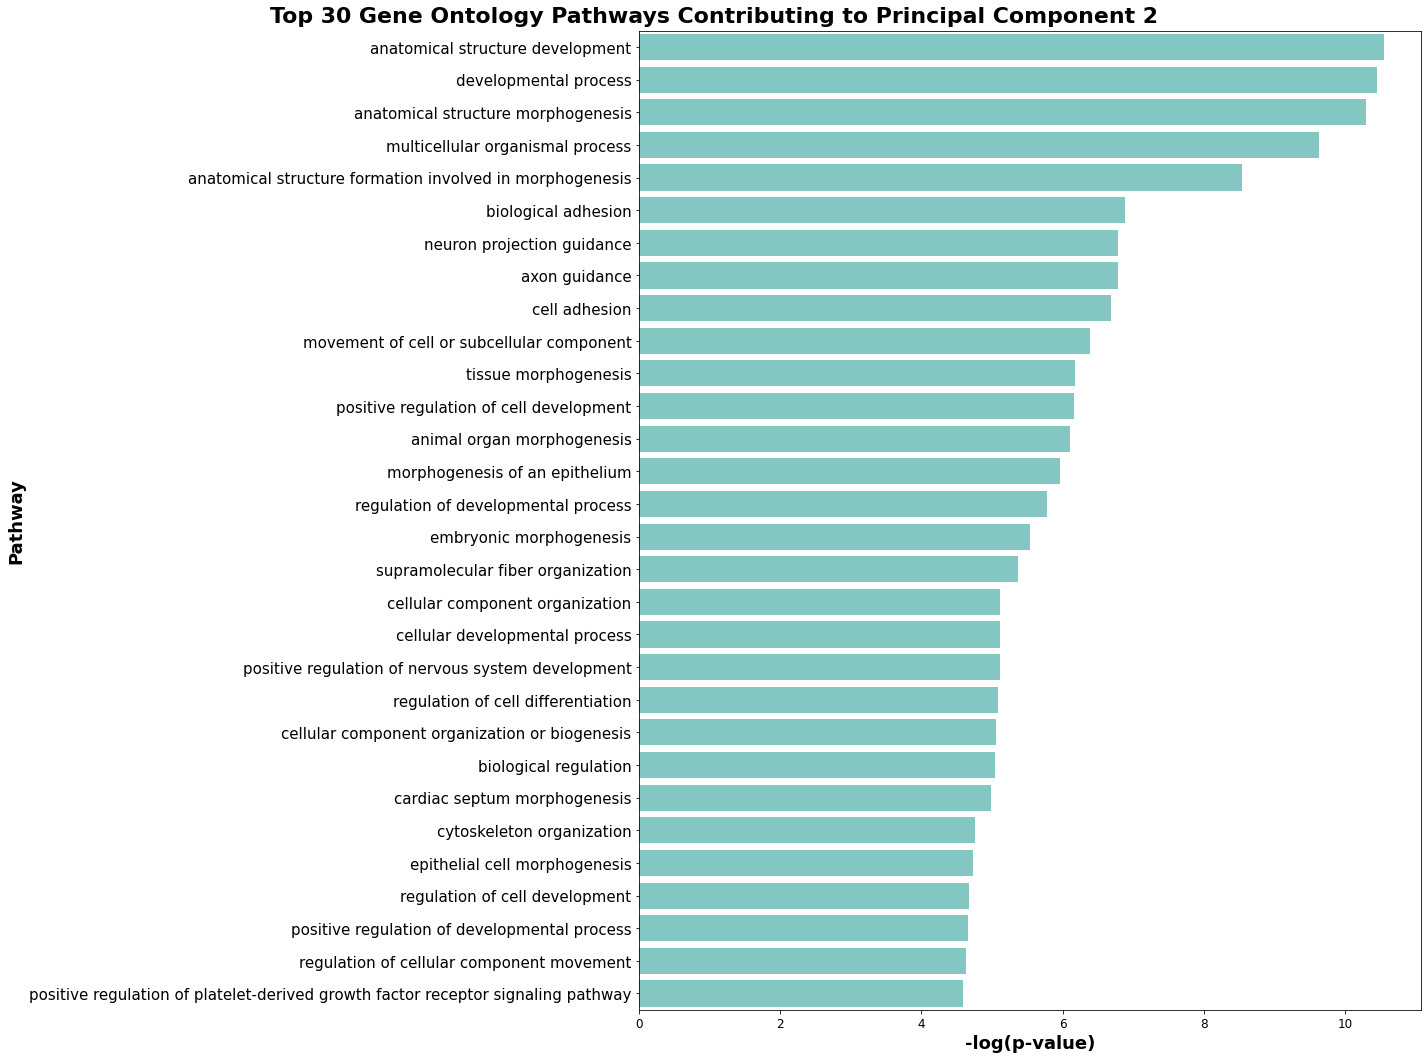

filtered: (30, 11)


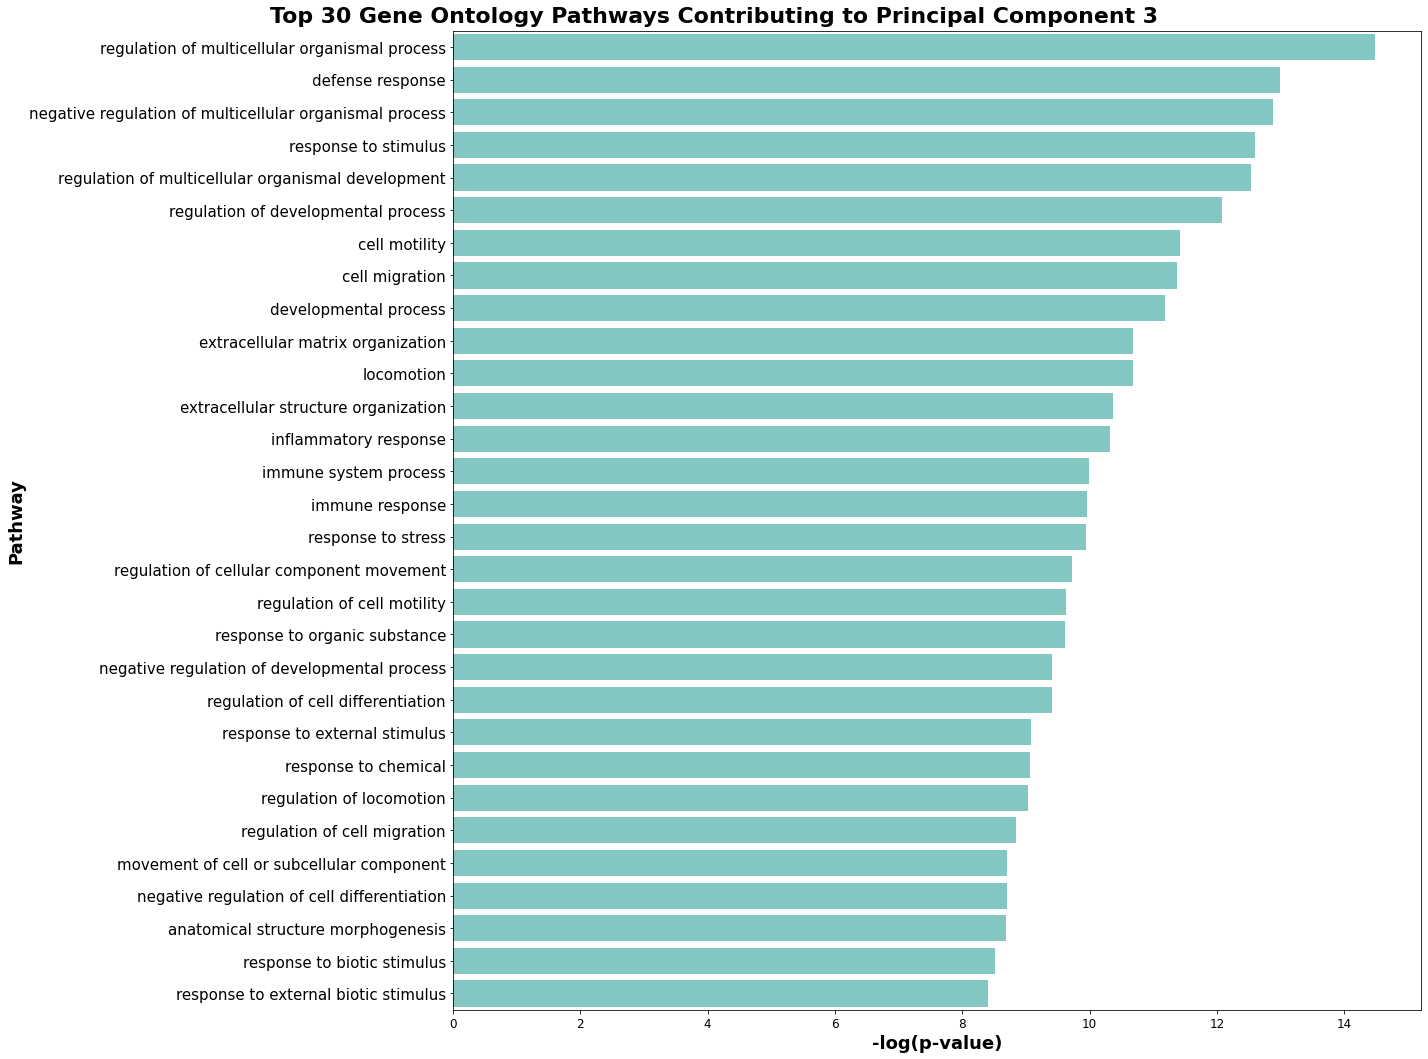

filtered: (30, 11)


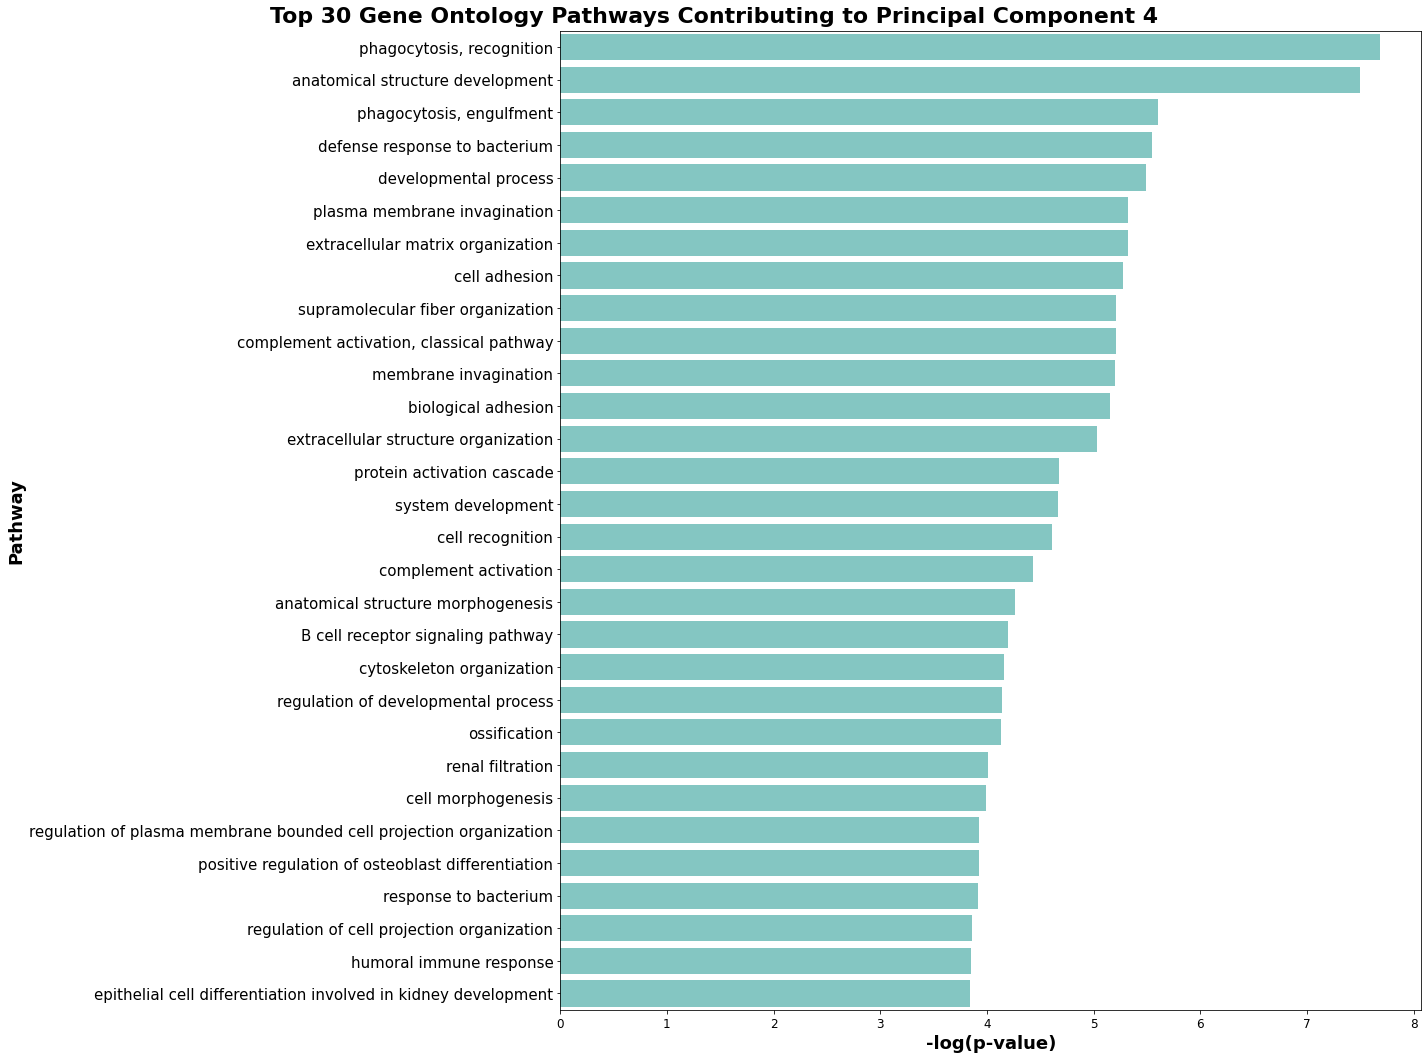

filtered: (30, 11)


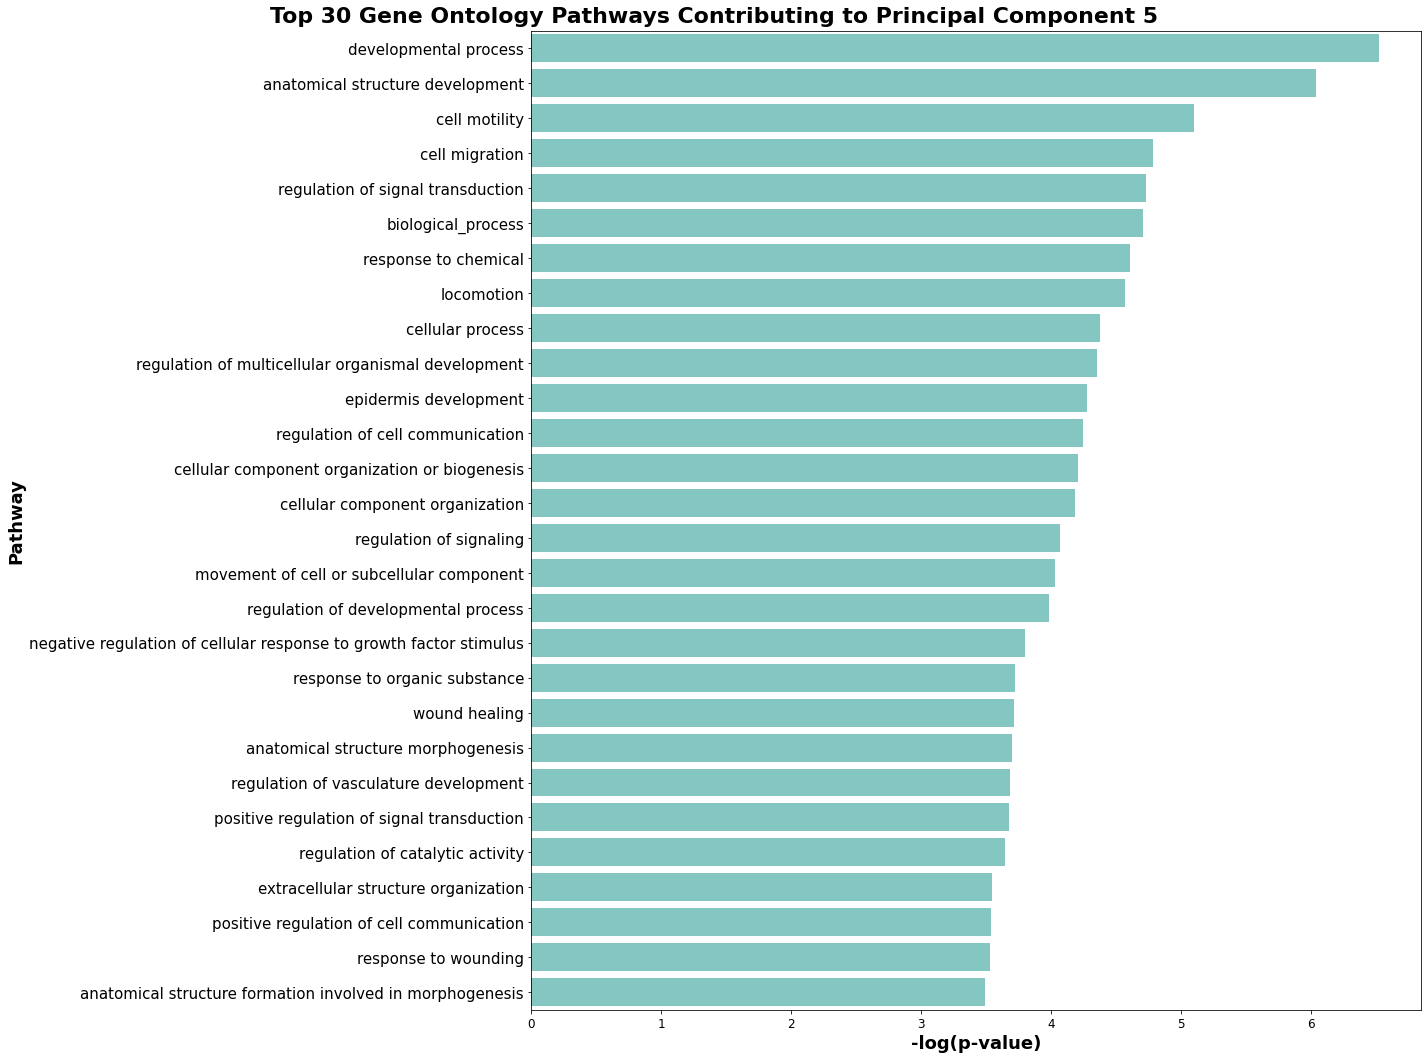

filtered: (30, 11)


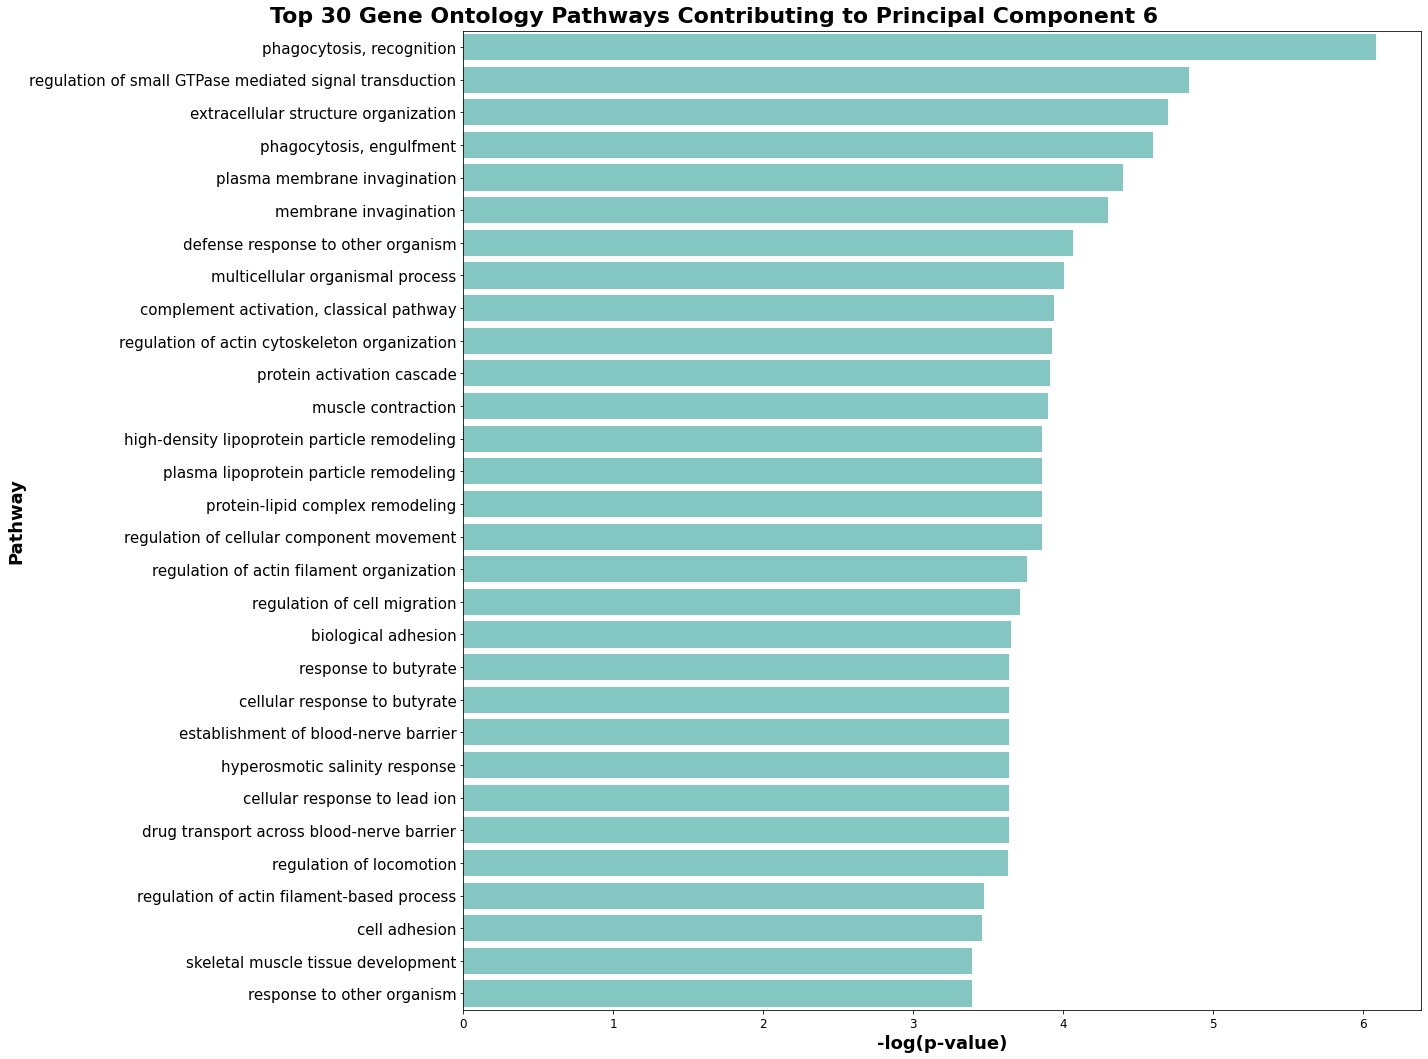

filtered: (30, 11)


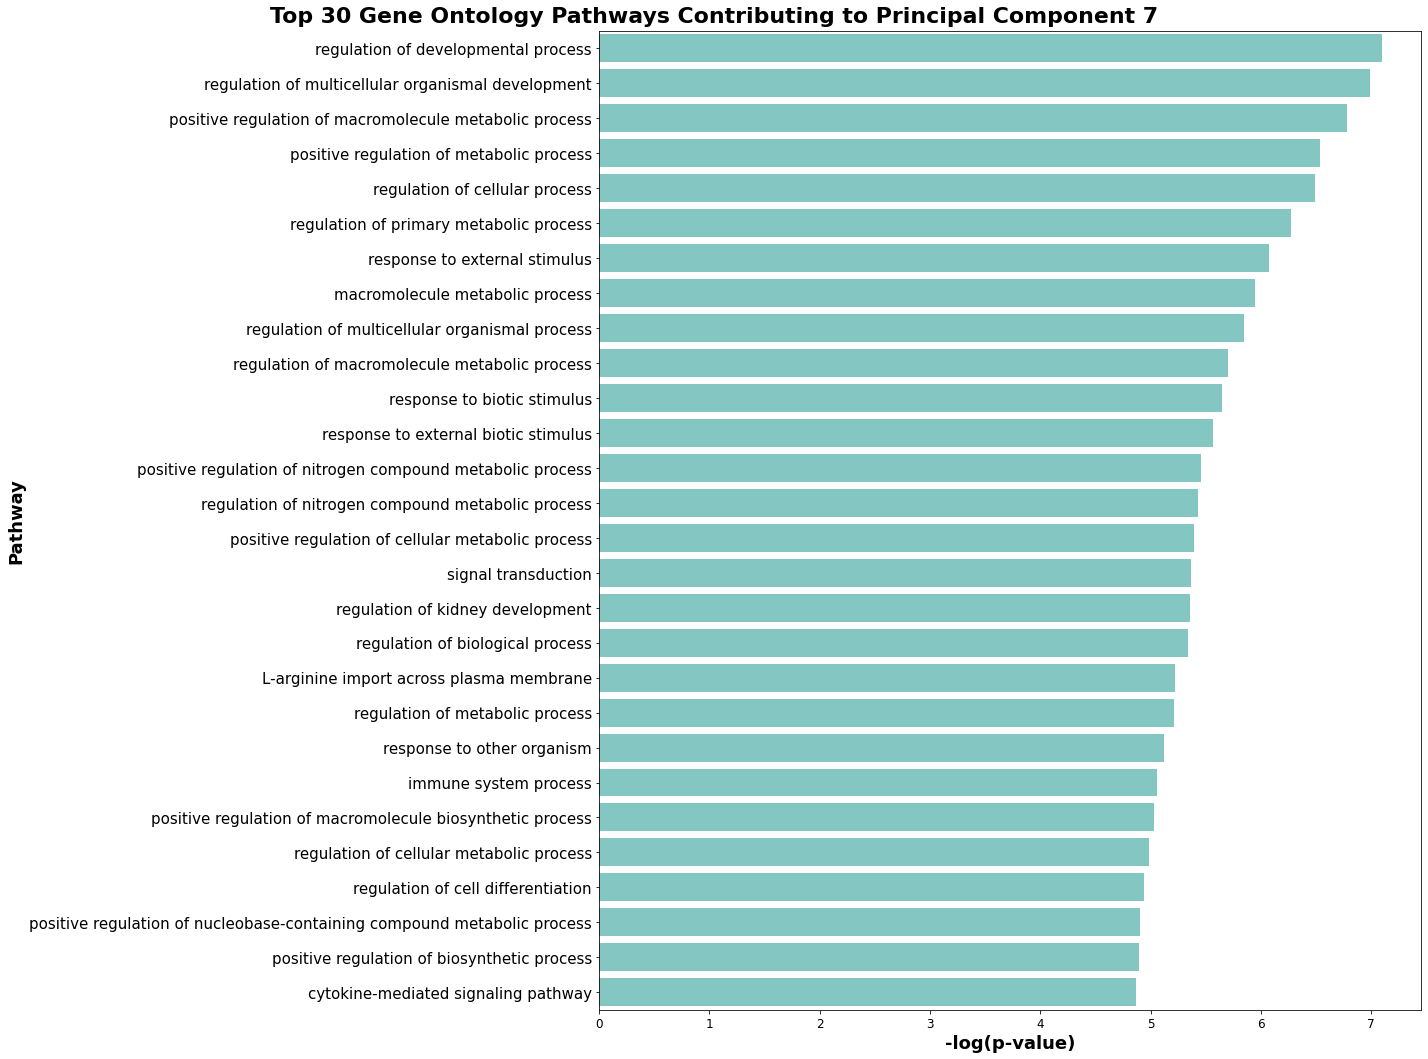

In [411]:
# The sheets on the Excel
sheet_names = ['Component_0','Component_1','Component_2','Component_3', 'Component_4', 'Component_5', 'Component_6', 'Component_7']  

#for figure sized
num=0
for sheet_name in sheet_names:
    
    # Reading the Excel sheet into a DataFrame
    pca_name_path = Path(f"{os.getcwd()}/../results/EXP5/", "GOPROCESS_PCA_genes_residuals_combo_ADIP.xlsx")
    data = pd.read_excel(pca_name_path, sheet_name = sheet_name)
    data["-logpvalue"] = -np.log10(data["P-value"])
    # Filter the DataFrame for pathways related to adipocyte functions
    # This assumes you have a column 'Pathway' containing the names of the pathways
    # and 'p-value' containing the p-values
    
    filtered_data = data.loc[0:29]
    print(f"filtered: {filtered_data.shape}")

    # Plotting the data

    num = num+1
    plt.figure(figsize=(20,15))  
    bar_plot = sns.barplot(x='-logpvalue', y='Description', data=filtered_data, color='lightseagreen',alpha=0.6)
    plt.xlabel('-log(p-value)', fontsize=18, fontweight='bold')
    plt.ylabel('Pathway', fontsize=18, fontweight='bold')
    plt.suptitle(f'Top 30 Gene Ontology Pathways Contributing to Principal Component {sheet_name[-1]}',
               fontname = 'Arial',fontweight='bold', fontsize=22)
    # Set the weight of the y-axis labels to bold
    for label in bar_plot.get_yticklabels():
        label.set_fontsize(15)

    plt.tight_layout()
    plt.show()

## NMF

Analyzing how close to negative the distributions of each residual are:

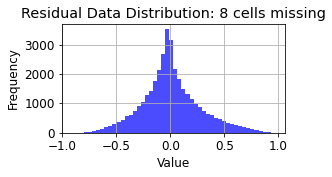

In [412]:
data = residuals_bulks.values
plt.figure(figsize=(4, 2)) 
plt.hist(data.flatten(), bins=50, color='blue', alpha=0.7)
plt.title(f'Residual Data Distribution: {num} cells missing')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

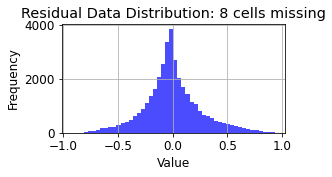

In [413]:
data = residuals_dissbulks.values
plt.figure(figsize=(4, 2)) 
plt.hist(data.flatten(), bins=50, color='blue', alpha=0.7)
plt.title(f'Residual Data Distribution: {num} cells missing')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

Shifting distributions according to above plots, and calculating NMF:

0.9108239334776178


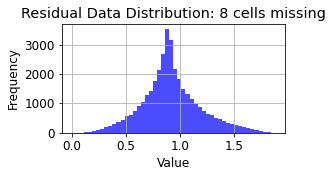

In [414]:
residuals_bulks_shift=residuals_bulks
if nmf_cut == "minimum_value":
    #calculate value to shift distributions minimally:
    min_val = abs(np.min(np.min(residuals_bulks)))
    print(min_val)
    residuals_bulks_shift= residuals_bulks + min_val
elif nmf_cut == "at_0":
    #cutting distribution at 0
    residuals_bulks_shift[residuals_bulks_shift.values <= 0] = 0
data = residuals_bulks_shift.values
plt.figure(figsize=(4, 2)) 
plt.hist(data.flatten(), bins=50, color='blue', alpha=0.7)
plt.title(f'Residual Data Distribution: {num} cells missing')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

0.9198850546588563


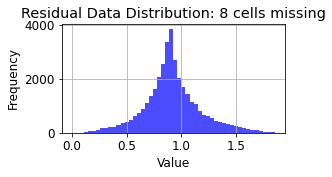

In [415]:
residuals_dissbulks_shift=residuals_dissbulks
if nmf_cut == "minimum_value":
    #calculate value to shift distributions minimally:
    min_val = abs(np.min(np.min(residuals_dissbulks)))
    print(min_val)
    residuals_dissbulks_shift= residuals_dissbulks + min_val
elif nmf_cut == "at_0":
    #cutting distribution at 0
    residuals_dissbulks_shift[residuals_dissbulks_shift.values <= 0] = 0
data = residuals_dissbulks_shift.values
plt.figure(figsize=(4, 2)) 
plt.hist(data.flatten(), bins=50, color='blue', alpha=0.7)
plt.title(f'Residual Data Distribution: {num} cells missing')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

0.9198850546588563


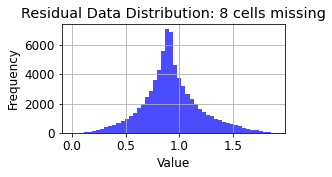

In [416]:
residuals_combo_shift=residuals_combo
if nmf_cut == "minimum_value":
    #calculate value to shift distributions minimcomboy:
    min_val = abs(np.min(np.min(residuals_combo)))
    print(min_val)
    residuals_combo_shift= residuals_combo + min_val
elif nmf_cut == "at_0":
    #cutting distribution at 0
    residuals_combo_shift[residuals_combo_shift.values <= 0] = 0
data = residuals_combo_shift.values
plt.figure(figsize=(4, 2)) 
plt.hist(data.flatten(), bins=50, color='blue', alpha=0.7)
plt.title(f'Residual Data Distribution: {num} cells missing')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

### The combined residuals (classic and dissociated)

In [417]:
#nmf on residual combined
num_nmf_comp_combo = 4
nmf = NMF(n_components = num_nmf_comp_combo, init='nndsvd', max_iter=10000)
res_nmf_df = nmf.fit_transform(residuals_combo_shift)
res_nmf_combo = pd.DataFrame(res_nmf_df)
components_combo = pd.DataFrame(nmf.components_)
components_combo.columns = gene_ids
components_combo

,A1BG,A2M,AAGAB,AASS,AATF,AATK,ABAT,ABCA1,ABCA5,ABCB1,...,ZNHIT1,ZNHIT3,ZNRF1,ZNRF3,ZPR1,ZRSR2,ZSCAN18,ZSWIM8,ZXDC,ZYX
0,0.080779,0.178458,0.123285,0.116758,0.107129,0.095131,0.144088,0.141209,0.117498,0.125685,...,0.062637,0.114259,0.106119,0.095371,0.093987,0.106522,0.115288,0.167768,0.143783,0.149741
1,0.063041,0.149961,0.089195,0.067544,0.091388,0.140138,0.082784,0.115681,0.149434,0.085481,...,0.043387,0.073767,0.067042,0.094893,0.116634,0.073072,0.104934,0.125135,0.148460,0.053738
2,0.104915,0.150994,0.132040,0.192524,0.107353,0.178600,0.128843,0.151921,0.121810,0.122166,...,0.029457,0.109666,0.105248,0.130346,0.252345,0.111556,0.133356,0.164955,0.119049,0.217657
3,0.059313,0.131625,0.096307,0.089737,0.067442,0.088175,0.090285,0.109359,0.055628,0.091428,...,0.057691,0.070256,0.079927,0.083542,0.121825,0.080566,0.134680,0.168741,0.108054,0.087763


In [418]:
# Separate the data into "classic bulks" and "dissociated bulks"
df = res_nmf_combo
classic_bulks = df.iloc[:8, :]
dissociated_bulks = df.iloc[8:, :]

# Perform t-test for each component
results = pd.DataFrame(columns=['Component', 'T-Statistic', 'P-Value'])

for column in df.columns:
    t_statistic, p_value = stats.ttest_ind(classic_bulks[column], dissociated_bulks[column])
    results = results.append({'Component': column, 'T-Statistic': t_statistic, 'P-Value': p_value}, ignore_index=True)

# Print the results
print(results)

# Identify components with significantly different means
significantly_different = results[results['P-Value'] < 0.05]
print("Components with significantly different means:")
print(significantly_different)

   Component  T-Statistic   P-Value
0        0.0     1.859352  0.084121
1        1.0     0.175088  0.863518
2        2.0    -1.482472  0.160373
3        3.0    -0.484956  0.635208
Components with significantly different means:
Empty DataFrame
Columns: [Component, T-Statistic, P-Value]
Index: []


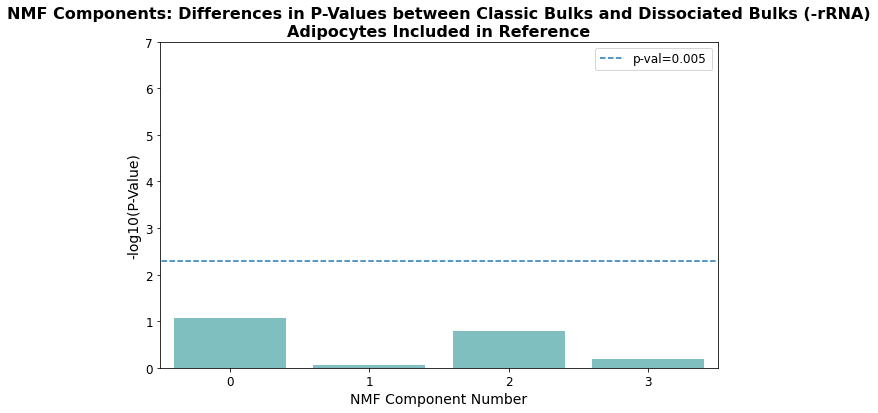

In [419]:
# Bar plot for each component
plt.figure(figsize=(10, 6))
plt.bar(results['Component'], -np.log10(results['P-Value']), color='teal', alpha=0.5)

plt.xlabel('NMF Component Number', fontsize=14, fontname='Arial')
plt.ylabel('-log10(P-Value)', fontsize=14, fontname='Arial')
plt.plot([-1,0,1,2,3,4],np.repeat(-np.log10(0.005),6),linestyle='--', label='p-val=0.005')
plt.title('NMF Components: Differences in P-Values between Classic Bulks and Dissociated Bulks (-rRNA)\nAdipocytes Included in Reference', fontsize=16, fontname='Arial', fontweight='bold')
plt.xticks([0,1,2,3])
plt.ylim(0,7)
plt.xlim(-0.5,3.5)
plt.legend()
plt.show()

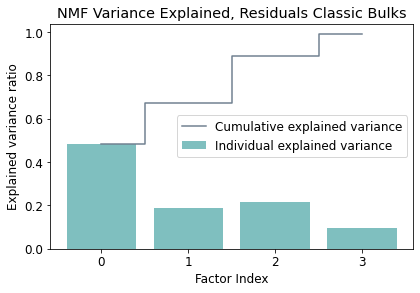

In [420]:
# W and H are your NMF results
V = residuals_combo_shift.values
W = res_nmf_combo.values
H = components_combo.values # Solve for H using least squares

# Calculate the explained variance for each component
explained_variance = []
for i in range(W.shape[1]):
    WH = np.dot(W[:, :i+1], H[:i+1, :])
    explained_variance.append(1 - np.linalg.norm(V - WH, 'fro')**2 / np.linalg.norm(V, 'fro')**2)

cum_sum = explained_variance

indiv_variance =  [cum_sum[0], 
                cum_sum[1] - cum_sum[0],
                cum_sum[2]- cum_sum[1],
                cum_sum[3] - cum_sum[2],
]


## plot variance explained
plt.bar(range(0,len(indiv_variance)), indiv_variance, alpha=0.5, align='center', label='Individual explained variance', color='teal')
plt.step(range(0,len(cum_sum)), cum_sum, where='mid',label='Cumulative explained variance', color='slategrey')
plt.ylabel('Explained variance ratio')
plt.xlabel('Factor Index')
plt.legend(loc='best')
plt.xticks([0,1,2,3])
plt.tight_layout()
plt.title(f"NMF Variance Explained, Residuals Classic Bulks")
plt.show()

In [421]:
W = res_nmf_combo.values
H = components_combo.values

nmf_genes_combo = pd.DataFrame()
num_components = num_nmf_comp_combo

# Iterate through each component
for component_idx in range(num_components):

    # Sort genes by their influence on the current component
    sorted_genes = residuals_combo.columns[np.argsort(H[component_idx])]

    # Visualize the top N genes that contribute the most to the current component
    N = len(sorted_genes)
    top_genes = sorted_genes[-N:]

    nmf_genes_combo[component_idx] = top_genes[::-1]
    
nmf_genes_combo.columns = ["Component_0","Component_1","Component_2","Component_3"]
nmf_genes_combo

,Component_0,Component_1,Component_2,Component_3
0,CIITA,TFCP2L1,LIF,PLEKHG5
1,LY75,ACPP,ZC3H12A,SDC1
2,TAP2,ANPEP,RND3,PPL
3,SIGLEC1,RAPGEF3,KLHL21,WDR91
4,SLFN11,VTCN1,CDH5,LAMB3
...,...,...,...,...
4579,CKB,GNG12,HIST1H4C,IGLC2
4580,AREG,AKAP12,ADIRF,IGKC
4581,MGP,MGST1,TCF7L2,SAA1
4582,MT1M,CLDN1,PSMB9,IGHG1


And plotting gene ontology analysis pathways.

NOTE: You'll have to run GOrilla for this part!

In [422]:
#Exporting NMF genes per component.
nmf_name_path = Path(f"{os.getcwd()}/../results/EXP5/", "NMF_genes_residuals_combo_ADIP.xlsx")
nmf_genes_combo.to_excel(nmf_name_path, sheet_name = "NMF_Components_Genes")

filtered: (30, 11)


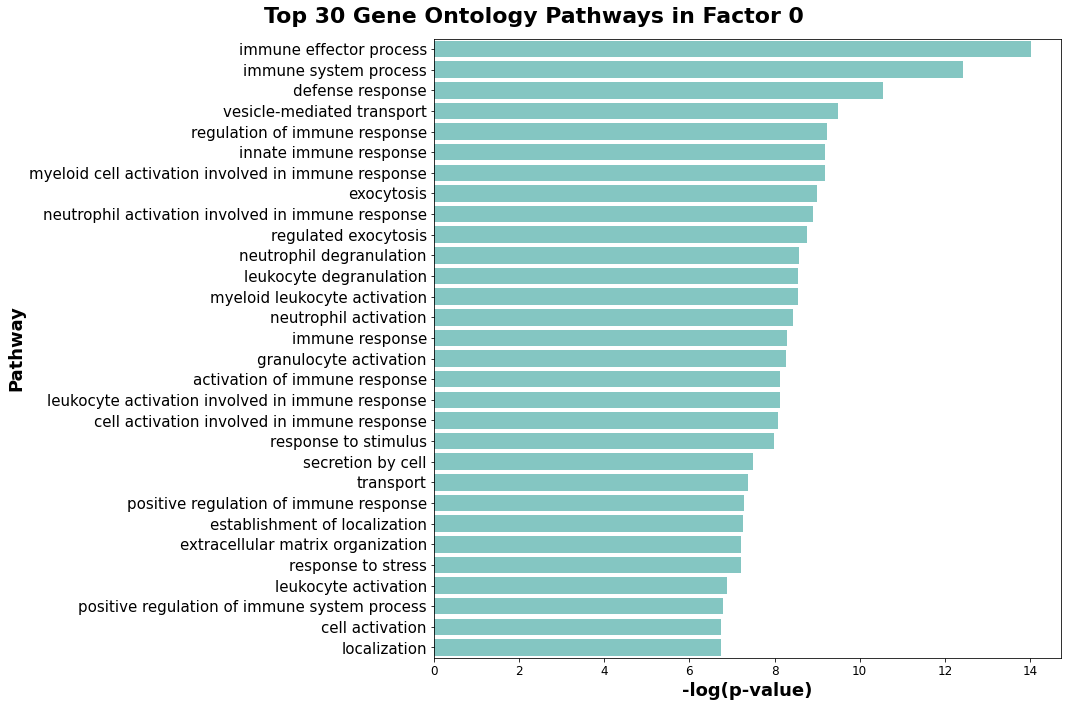

filtered: (21, 11)


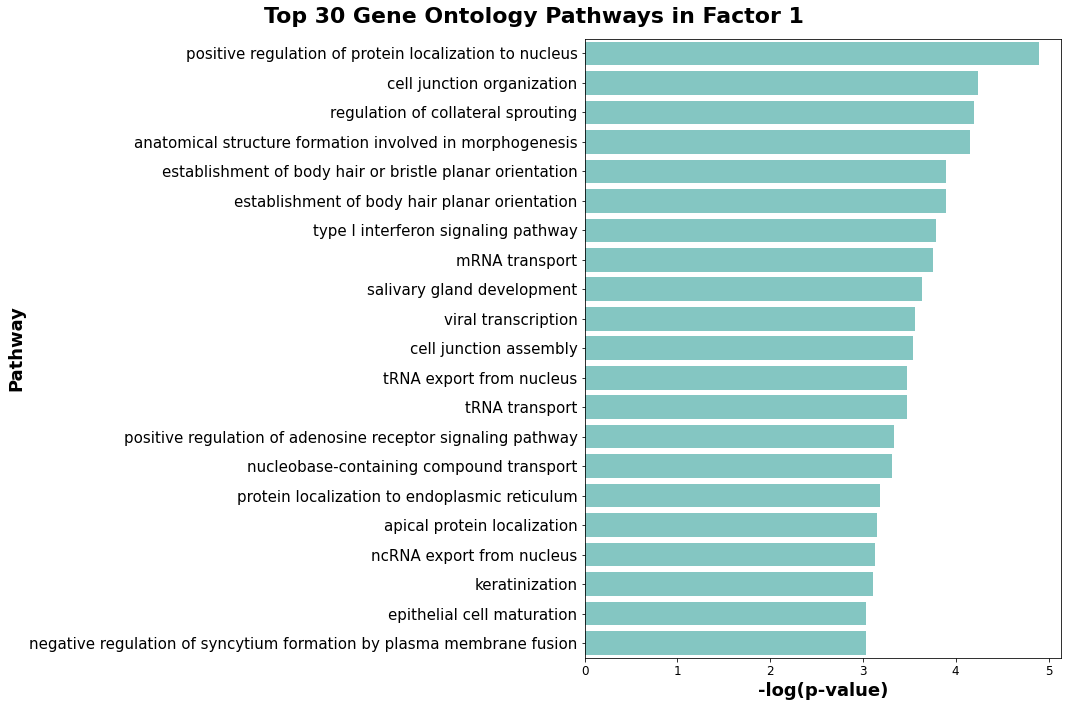

filtered: (30, 11)


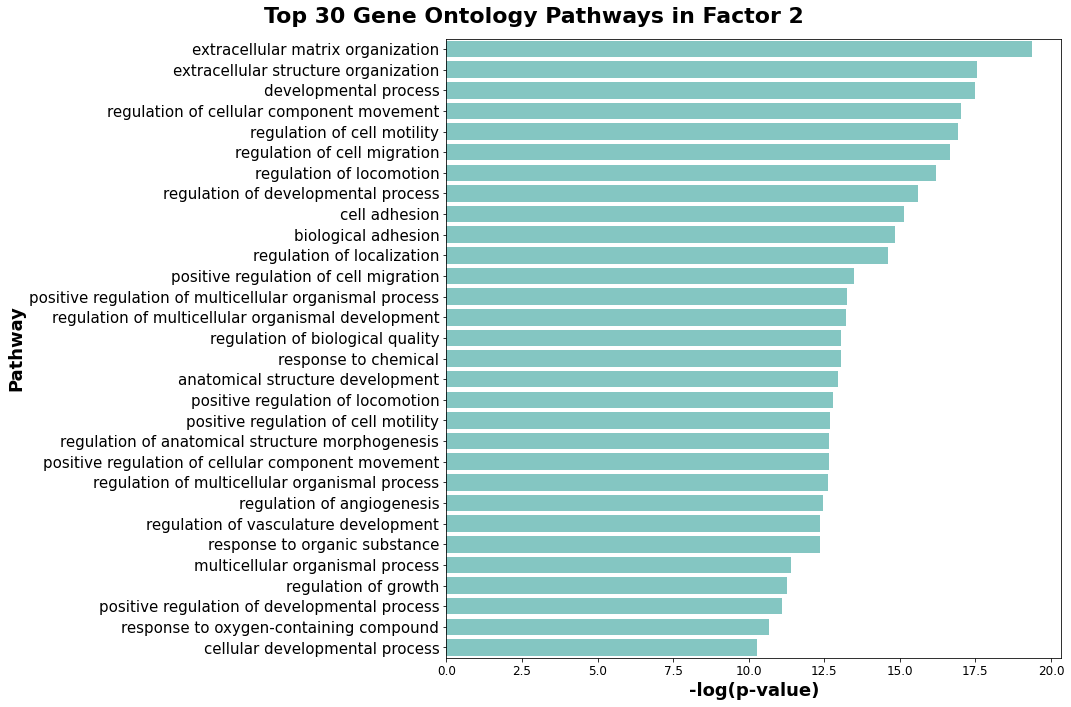

filtered: (30, 11)


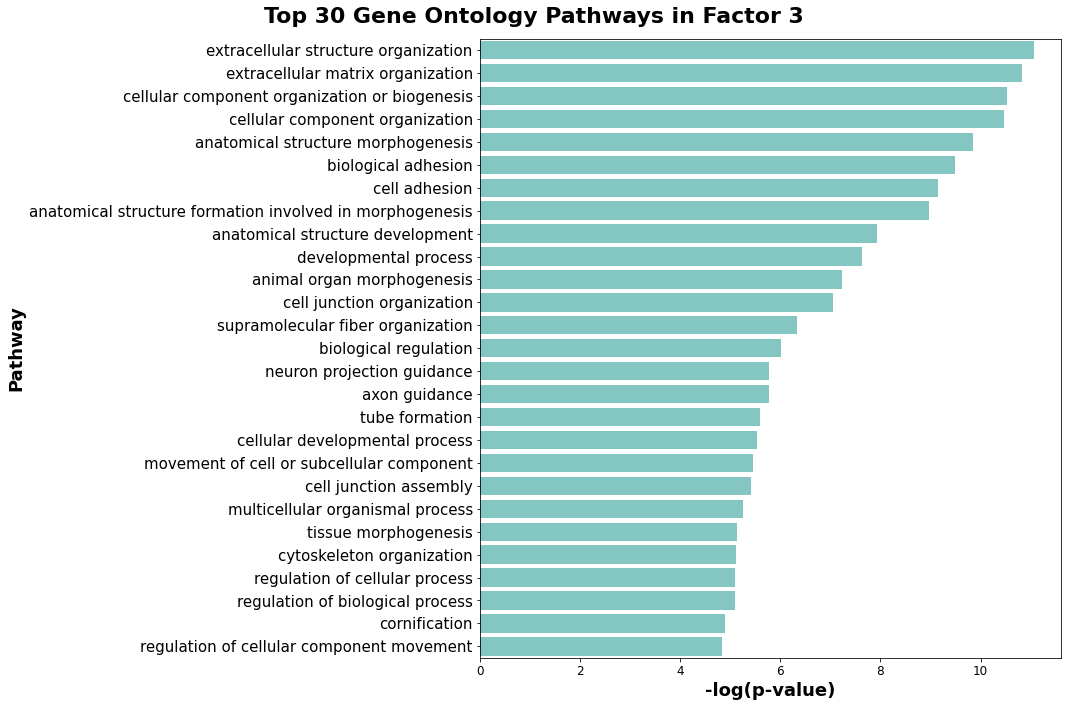

In [423]:
''' NOTE: You'll need to run GOrilla on these lists for this part!'''

# Load the data from the Excel file
sheet_names = ['Component_0','Component_1','Component_2','Component_3']
                # Sheet name containing the relevant NMF component

for sheet_name in sheet_names:
    # Reading the Excel sheet into a DataFrame
    pca_name_path = Path(f"{os.getcwd()}/../results/EXP5/", "GOPROCESS_NMF_genes_residuals_combo_ADIP.xlsx")
    data = pd.read_excel(pca_name_path, sheet_name = sheet_name)
    # Filter the DataFrame for pathways related to adipocyte functions
    # This assumes you have a column 'Pathway' containing the names of the pathways
    # and 'p-value' containing the p-values
    data["-logpvalue"] = -np.log10(data["P-value"])
    filtered_data = data.loc[0:29]
    print(f"filtered: {filtered_data.shape}")

    # Plotting the data
    plt.figure(figsize=(15, 10))  # Adjust size as needed
    bar_plot = sns.barplot(x='-logpvalue', y='Description', data=filtered_data, color='lightseagreen',alpha=0.6)
    plt.xlabel('-log(p-value)', fontsize=18, fontweight='bold')
    plt.ylabel('Pathway', fontsize=18, fontweight='bold')
    plt.suptitle(f'Top 30 Gene Ontology Pathways in Factor {sheet_name[-1]}', fontname = 'Arial',fontweight='bold', fontsize=22)
    # Set the weight of the y-axis labels to bold
    for label in bar_plot.get_yticklabels():
        label.set_fontsize(15)

    plt.tight_layout()
    plt.show()